In [1]:
## Imports
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

from itertools import chain 


print(sys.version)


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
## Inputs
#labels
tags = []
tags = [
#         'QCD_HT_all, background',
#         'WLNu, background',
#         'ZNunu_HT_all, background',
#         'TT_Lep, background',
#         'All, background',
#         'QCD_HT50to100, background',
        'H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/'

# file names

fnames = {}

fnames['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-hbb-hbb_mh175_pl1000_ev100000_1pb_weighted.root'
fnames['H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-hbb-hbb_mh150_pl1000_ev100000_1pb_weighted.root'
fnames['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] =  'testrun/SusyLLP_n3n2-n1-hbb-hbb_mh127_pl1000_ev100000_1pb_weighted.root'
# fnames['QCD_HT50to100, background'] = 'normalized/QCD_HT50to100_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_v6-v1_v2_v1_1pb_weighted.root'
# fnames['QCD_HT_all, background'] = 'skimmed/skim_qcd_ht_all.root'
fnames['QCD_HT_all, background'] = 'normalized/QCD_HTbinned_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['WLNu, background'] = 'normalized/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root'
fnames['ZNunu_HT_all, background'] = 'normalized/ZJetsToNuNu_HTbinned__13TeV-madgraph_1pb_weighted.root'
fnames['TT_Lep, background'] = 'normalized/TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['All, background'] = 'normalized/Bkg_1pb_weighted.root'
# fnames['QCD_HT_all, background'] = 'skimmed/SSSSSS.root'


# output plots directory
# out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/'
# out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200121/'
out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/'


# colors
cols = {}

# cols['QCD_HT50to100, background'] = 215
cols['QCD_HT_all, background'] = 215
cols['WLNu, background'] = 227
cols['ZNunu_HT_all, background'] = 221
cols['TT_Lep, background'] = 209
cols['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] = 207
cols['H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m'] = 205
cols['H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m'] = 94
cols['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] = 79
cols['All, background'] = 1
#cols['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 221
#cols['W(lv)Jets, background'] = 209


#styles
stys = {}

# stys['QCD_HT50to100, background'] = 3
stys['QCD_HT_all, background'] = 3
stys['WLNu, background'] = 4
stys['ZNunu_HT_all, background'] = 2
stys['TT_Lep, background'] = 7
stys['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'] = 5
stys['H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m'] = 6
stys['H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m'] = 8
stys['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'] = 9
stys['All, background'] = 1
#stys['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 2
#stys['W(lv)Jets, background'] = 1


# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    if 'back' not in tag:
        calo_jet_amax = v['gLLP0_EB'].array()
        print(calo_jet_amax[:10])



/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/SusyLLP_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root
Open ready
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7f266b4d7a90> OrderedDict([('H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7f266b4d7a90>)])
[[0.009129958 0.0 0.0 0.6193744] [0.0119053675 0.0 0.0 0.20475802 0.37917507] [] ... [0.0] [0.37371102 0.030051181 0.21926512 0.08870697] [0.46424305 0.0]]
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
[ True  True  True False False  True  True False  True  True]
/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/SusyLLP_n3n2-n1-hbb-hbb_mh175_pl1000_ev100000_1pb_weighted.root
Open ready
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7f266558de80> OrderedDict([('H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree'

In [17]:
## Variables
trg_path = 310
# trg_path = 0
# 310 HLT_PFMET120_PFMHT120_IDTight

met_cut = 150
jet_pt_cut = 30
njet_cut = 1
nlep_cut = 0

# pf_jet_pt = {}
# pf_jet_met = {}
# pf_jet_w = {}
# pf_flat_w = {}

trg_jet_pt = {}
trg_jet_met = {}
trg_jet_ht = {}
trg_jet_w = {}
trg_flat_w = {}

# pf_jet_t = {}
# pf_jet_tmf = {}
# pf_jet_chef = {}
# pf_jet_dr = {}

# pf_jet_nj = {}

trg_jet_t = {}
trg_jet_tmf = {}
trg_jet_chef = {}
trg_jet_dr = {}

trg_jet_nj = {}

for k,v in tree.items():
    print(k,v)

#     pf_jet_pt[k] = {}
#     pf_jet_met[k] = {}
#     pf_jet_w[k] = {}
#     pf_flat_w[k] = {}

    trg_jet_pt[k] = {}
    trg_jet_met[k] = {}
    trg_jet_ht[k] = {}
    trg_jet_w[k] = {}
    trg_flat_w[k] = {}

    # branches
    hlt = v['HLTDecision'].array()[:,trg_path]
#     hlt = v['HLTDecision'].array()
   
    met = v['met'].array()

    nl = v['nLeptons'].array()
    nj = v['nJets'].array()
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    t = v['jetTime'].array()
    tmf = v['jetGammaMax_ET'].array()
    chef = v['jetChargedHadronEnergyFraction'].array()
    dr = v['jetMinDeltaRAllTracks'].array()
    
    weight = v['weight'].array()
    
    print(weight.shape)
    print(pt.shape)
    
    
    #ht
    print('PT ',pt[:10])
    print('LEN ',len(pt)[:10])
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
#     sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt[:,trg_path])
    
    basic_met_str = np.logical_and(nj>=njet_cut, met>met_cut)   #before/after trigger case
    basic_met_str = np.logical_and(basic_met_str, nl==nlep_cut)
#     basic_met_str = np.logical_and(nj>=0, met>0)   # before/after pre-selection case
    
    basic_jet_str = np.logical_and(abs(eta)<1.48, pt>jet_pt_cut)   

    # matched requirement
    if 'background' not in k:
        matched0 = v['jet_matched_gLLP0_grandaughter'].array()
        matched1 = v['jet_matched_gLLP1_grandaughter'].array()

        matched_str = np.logical_or(matched0==1, matched1==1)

        acc0_eb = v['gLLP0_EB'].array()
        acc1_eb = v['gLLP1_EB'].array()

        acc_eb_str = np.logical_or(acc0_eb==1, acc1_eb==1)

        basic_met_str = np.logical_and(basic_met_str, acc_eb_str)

        basic_jet_str = np.logical_and(basic_jet_str, matched_str)
        
#     basic_trg_str = np.logical_and(basic_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    

    #apply basic cut string
    # separate jagged jet array req. and event level req.
#     pf_jet_pt[k] = pt[basic_jet_str][basic_met_str]
#     pf_jet_met[k] = met[basic_met_str]
#     pf_jet_w[k] = weight[basic_met_str]
#     pf_jet_nj[k] = nj[basic_met_str]
    
#     pf_jet_t[k] = t[basic_jet_str][basic_met_str]
#     pf_jet_tmf[k] = tmf[basic_jet_str][basic_met_str]
#     pf_jet_chef[k] = chef[basic_jet_str][basic_met_str]
#     pf_jet_dr[k] = dr[basic_jet_str][basic_met_str]
    
    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    
    trg_jet_t[k] = t[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    
    #remove empty part in jet
#     pf_jet_met[k] = pf_jet_met[k][pf_jet_pt[k].count()>0]
#     pf_jet_w[k] = pf_jet_w[k][pf_jet_pt[k].count()>0]
#     pf_jet_nj[k] = pf_jet_nj[k][pf_jet_pt[k].count()>0]
    
#     pf_jet_t[k] = pf_jet_t[k][pf_jet_pt[k].count()>0]
#     pf_jet_tmf[k] = pf_jet_tmf[k][pf_jet_pt[k].count()>0]
#     pf_jet_chef[k] = pf_jet_chef[k][pf_jet_pt[k].count()>0]
#     pf_jet_dr[k] = pf_jet_dr[k][pf_jet_pt[k].count()>0]
    
#     pf_jet_pt[k] = pf_jet_pt[k][pf_jet_pt[k].count()>0]
    
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>0]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>0]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>0]
    
    trg_jet_t[k] = trg_jet_t[k][trg_jet_pt[k].count()>0]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>0]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>0]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>0]
    
    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>0]
    
    
#     #flat weight

#     pf_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(pf_jet_w[k],pf_jet_pt[k])]
#     pf_flat_w[k] = list(chain.from_iterable(pf_flat_w[k])) 
    
    trg_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    trg_flat_w[k] = list(chain.from_iterable(trg_flat_w[k])) 
 

    
    #print out check
#     print(pf_jet_pt[k][:10])
#     print(pf_jet_t[k][:10])
#     print(pf_jet_tmf[k][:10])
#     print(pf_jet_chef[k][:10])
#     print(pf_jet_dr[k][:10])
#     print(pf_jet_met[k][:10])
#     print(pf_jet_w[k][:10])
#     print(pf_jet_nj[k][:10])
#     print(sum(pf_jet_w[k]))
#     print(len(pf_jet_w[k]))
#     print(len(pf_jet_met[k]))
#     print(len(pf_jet_pt[k]))
#     print(len(pf_jet_w[k][pf_jet_pt[k].count()>0]))
#     print(len(pf_jet_pt[k][pf_jet_pt[k].count()>0]))
    print(hlt[basic_met_str][:10])

#     print(len(weight[sel_hlt_str]))

#     print(trg_jet_pt[k][:10])
#     print(trg_jet_met[k][:10])
    print(trg_jet_w[k][:10])
#     print(trg_jet_nj[k][:10])
#     print(len(trg_jet_pt[k]))
#     print(len(trg_jet_met[k]))
    print(len(trg_jet_w[k]))
    print(trg_jet_t[k][:10])
    print(trg_jet_tmf[k][:10])
    print(trg_jet_chef[k][:10])
    print(trg_jet_dr[k][:10])
    print(sum(trg_jet_w[k]))
    print(len(trg_jet_w[k]))
    print(hlt[met_trg_str][:10])
    
#     print(pf_flat_w[k][:10])
#     print(trg_flat_w[k][:10])
    

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
(55819,)
(55819,)
PT  [[142.18288 69.390236 23.193693 22.358913] [132.2285 114.73132 56.957115 51.77135 28.722202] [] ... [66.97349] [171.35086 111.894775 78.5331 39.33307] [70.35419 39.745846]]


TypeError: 'int' object is not subscriptable

# ALL BKG & SIG

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[280.2716  156.49886 164.48952 242.15868 192.62206 296.15747 401.75815
 244.76256 299.01434 194.55235]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[226.87988 301.0925  357.03992 175.39574 245.1852  196.45456 155.82372
 386.10654 229.36594 354.4042 ]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[388.46805 220.11597 182.4582  179.52338 230.23045 233.28674 181.1584
 204.74777 271.55627 180.09004]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[154.59485 321.285   235.92462 195.2827  244.48717 225.14922 380.135
 154.10265 191.47925 186.72623]


Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/met_trg_norm.png has been created


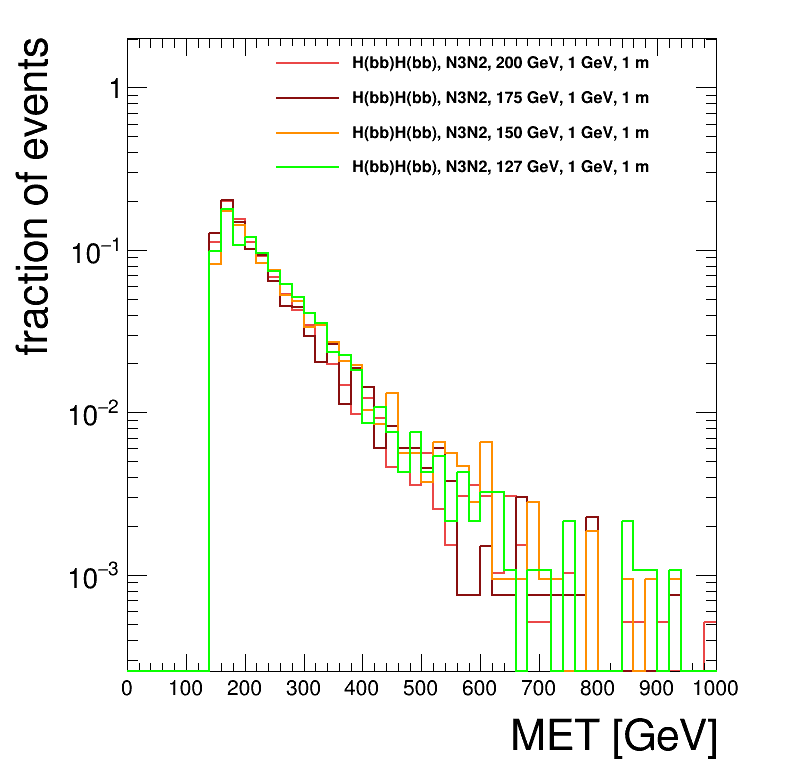

In [4]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_met[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=trg_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

#     ht[k].Draw('Histsame')
    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met_trg.png')
c.SaveAs(out_dir+'met_trg_norm.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[68.67287, 52.03112, 295.94345, 199.29875, 358.53384, 133.11708, 32.556133, 413.9756, 276.2872, 71.74189]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[506.0885, 53.888382, 528.9811, 280.05737, 365.9624, 169.9151, 277.01245, 169.7538, 205.78833, 158.91057]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[403.56918, 125.41504, 91.941284, 347.9944, 30.229233, 208.91759, 197.51724, 206.02197, 172.13045, 31.022268]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[121.15587, 34.063942, 273.09714, 186.72113, 43.72098, 140.32977, 37.58371, 245.5634, 151.11633, 200.36163]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/pt_trg.png has been created


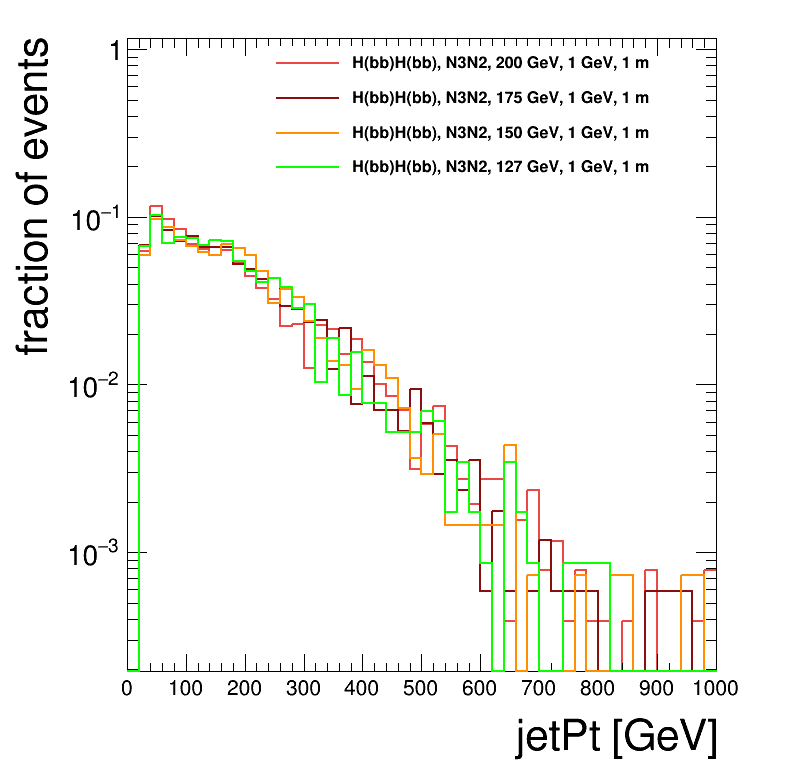

In [6]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = list(chain.from_iterable(trg_jet_pt[k])) 
#     j_gamma_all = trg_jet_pt[k].flatten()

    print(j_gamma_all[:10])
    
#     trg_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
#     trg_flat_w[k] = list(chain.from_iterable(trg_flat_w[k])) 
    
    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=trg_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'pt_trg.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[ 68.67287  295.94345  199.29875  358.53384  133.11708   32.556133
 413.9756   276.2872    71.74189  391.05832 ]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[506.0885  528.9811  280.05737 365.9624  169.9151  277.01245 169.7538
 205.78833 158.91057 457.7907 ]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[403.56918  125.41504  347.9944    30.229233 208.91759  197.51724
 206.02197  172.13045   79.55692  115.29947 ]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[121.15587 273.09714 186.72113 140.32977 245.5634  151.11633 200.36163
 146.21938 173.20001 151.60832]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/pt_leading_trg.png has been created


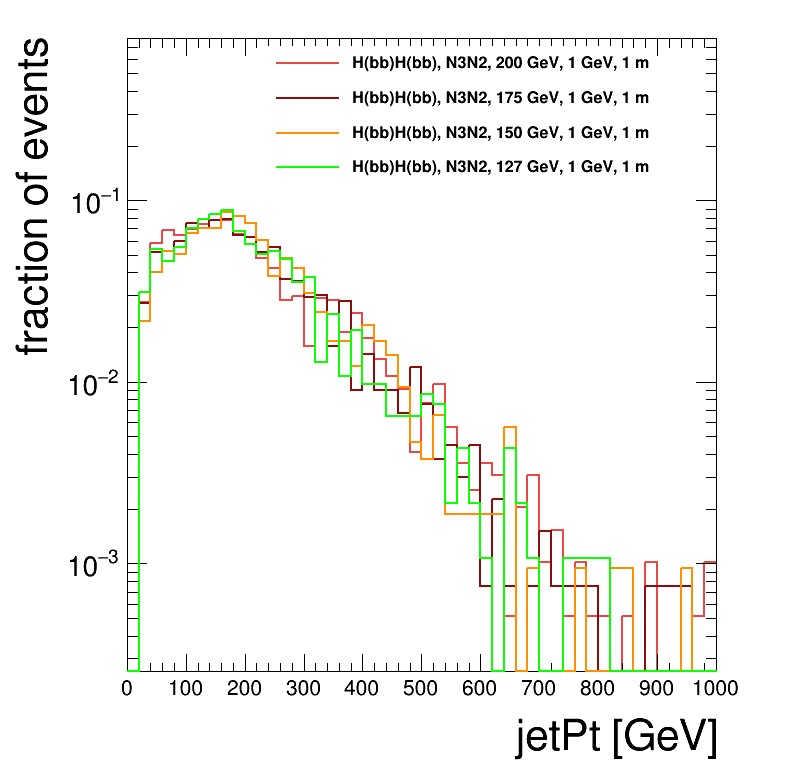

In [7]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_pt[k][:,0]

    print(j_gamma_all[:10])
    
#     trg_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
#     trg_flat_w[k] = list(chain.from_iterable(trg_flat_w[k])) 
    
    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=trg_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'pt_leading_trg.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[-2.1034658e-03  8.2303500e-01            nan  3.9988494e-01
  4.1254196e-01 -2.5595973e+00            nan  8.5262883e-01
  4.2623413e-01  7.9870656e-02]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[-0.3239998   0.36493498  0.4740811   0.2283788   1.3572294   0.23919751
  0.2531742   0.5863079   0.59521616  0.25936264]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[-0.00488307  0.15575486  0.68219894  0.14839233  1.2902329   0.2083108
  0.7879919   0.605214    0.80237526  0.6074283 ]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[0.73288256 1.4472667  0.1450653  0.24808812 0.35878322 0.5669472
 0.21042214 0.07687046 1.1872736  0.14517614]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/t_trg.png has been created


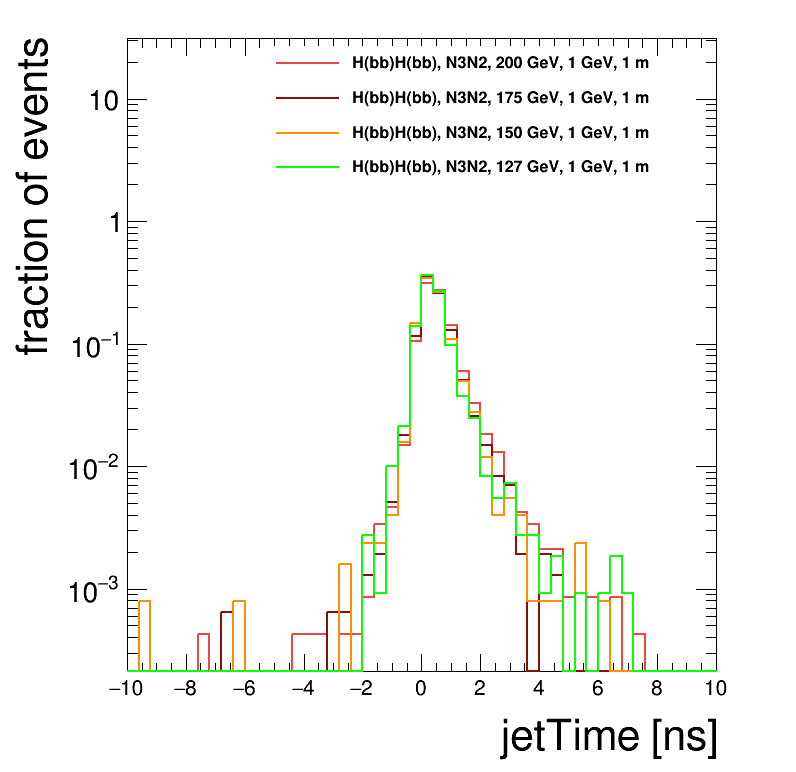

In [8]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_t[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetTime [ns]', 'fraction of events'], name="", binning=[50,-10,10], weights=trg_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+2*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'t_trg.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[-2.1034658e-03            nan  3.9988494e-01  4.1254196e-01
 -2.5595973e+00            nan  8.5262883e-01  4.2623413e-01
  7.9870656e-02  2.1839271e-01]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[-0.3239998   0.4740811   0.2283788   1.3572294   0.23919751  0.2531742
  0.5863079   0.59521616  0.25936264  1.9642218 ]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[-0.00488307  0.15575486  0.14839233  1.2902329   0.2083108   0.7879919
  0.605214    0.80237526  0.09229173  0.4321679 ]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[0.73288256 0.1450653  0.24808812 0.5669472  0.07687046 1.1872736
 0.14517614 0.28620714 0.5490812  0.2687407 ]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/t_leading_trg.png has been created


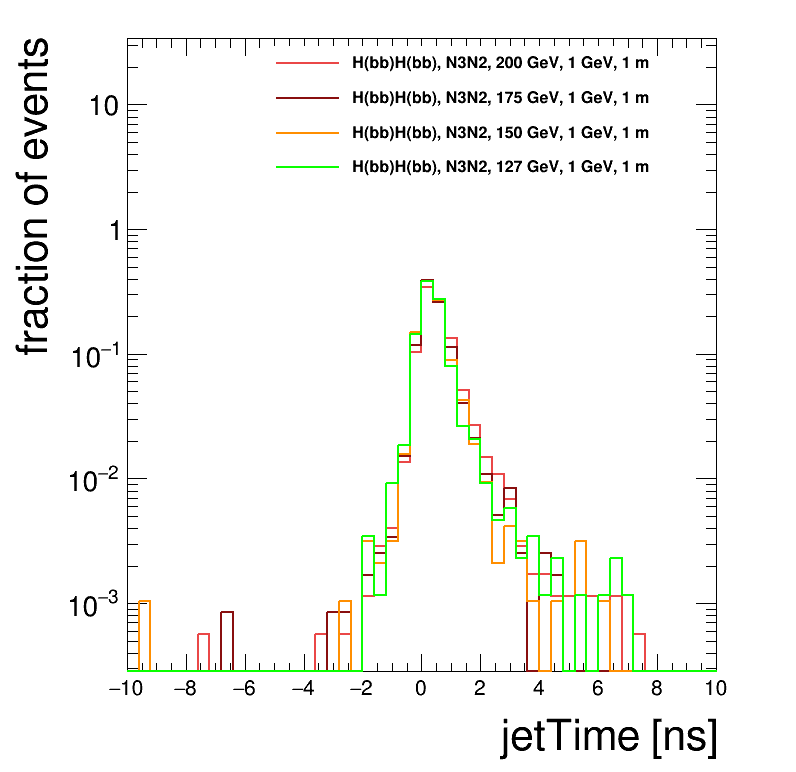

In [9]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_t[k][:,0]
#     j_gamma_all = trg_jet_t[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetTime [ns]', 'fraction of events'], name="", binning=[50,-10,10], weights=trg_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+2*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'t_leading_trg.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[-2.1034658e-03            nan  3.9988494e-01  4.1254196e-01
 -2.5595973e+00            nan  8.5262883e-01  4.2623413e-01
  7.9870656e-02  2.1839271e-01]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[-0.3239998   0.4740811   0.2283788   1.3572294   0.23919751  0.2531742
  0.5863079   0.59521616  0.25936264  1.9642218 ]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[-0.00488307  0.15575486  0.14839233  1.2902329   0.2083108   0.7879919
  0.605214    0.80237526  0.09229173  0.4321679 ]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[0.73288256 0.1450653  0.24808812 0.5669472  0.07687046 1.1872736
 0.14517614 0.28620714 0.5490812  0.2687407 ]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/t_leading_trg_pt100.png has been created


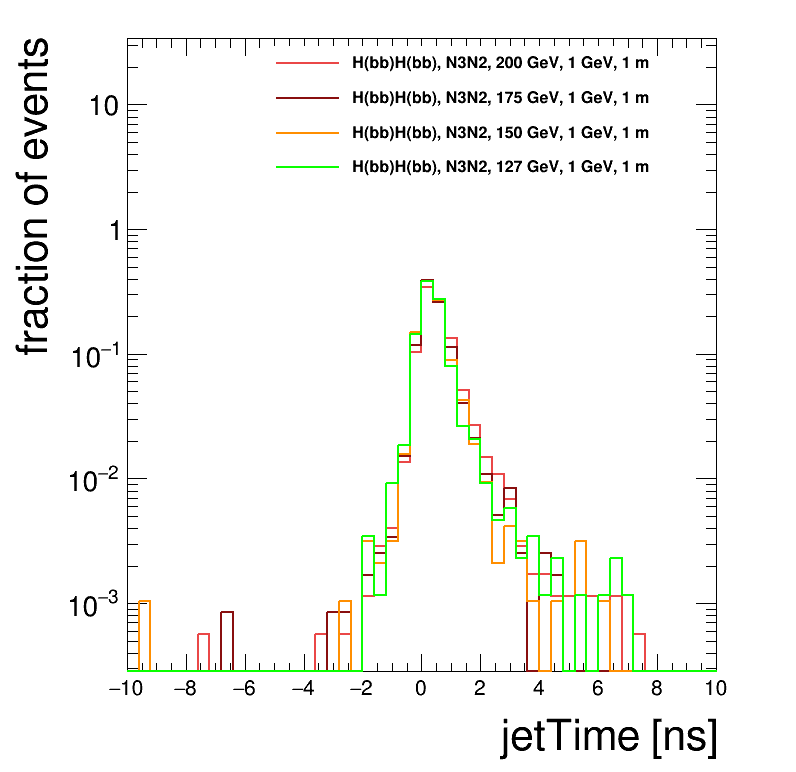

In [10]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_t[k][:,0] 
#     j_gamma_all = trg_jet_t[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all , axis_title=['jetTime [ns]', 'fraction of events'], name="", binning=[50,-10,10], weights=trg_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+2*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'t_leading_trg_pt100.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[0.02248414 0.04815962 0.0498399  0.0155893  0.00649088 0.02523573
 0.03959891 0.00266661 0.00591551 0.04546637]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[0.00327134 0.02558302 0.00960619 0.01704251 0.01386595 0.
 0.01124957 0.02381499 0.         0.01336625]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[0.         0.01233357 0.01613772 0.00725593 0.         0.00692628
 0.01439068 0.00562775 0.02293375 0.02938894]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[0.01090076 0.02877645 0.         0.01197004 0.08155964 0.00760734
 0.02697716 0.         0.01250787 0.00616266]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/tmf_trg.png has been created


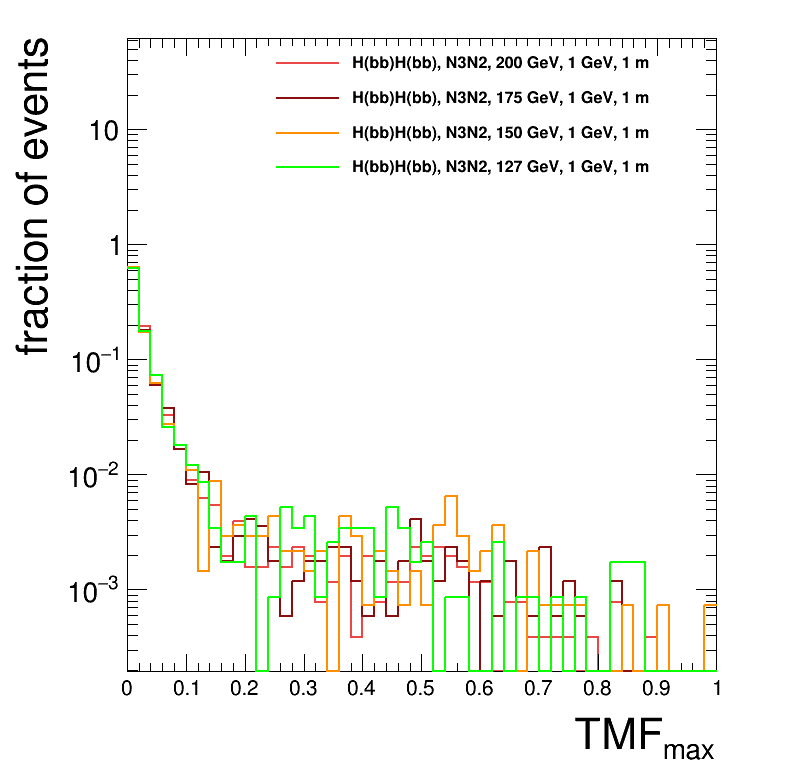

In [11]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_tmf[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['TMF_{max}', 'fraction of events'], name="", binning=[50,0,1.], weights=trg_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+2*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'tmf_trg.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[0.41022068 0.07445806 0.01081648 0.06726882 0.01642198 0.02045011
 0.09526476 0.00250115 0.01627934 0.0722428 ]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[0.15471281 0.5216025  0.002676   0.03202091 0.01259757 0.03401368
 0.03167879 0.3512873  0.25886378 0.00784328]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[0.00191432 0.4362859  0.15783982 0.01782618 0.03806167 0.01786803
 0.01212335 0.01728693 0.0345136  0.21430072]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[0.10348038 0.11629201 0.00961274 0.02830526 0.01617033 0.00730619
 0.00974793 0.22253786 0.04011821 0.37848318]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/chef_trg.png has been created


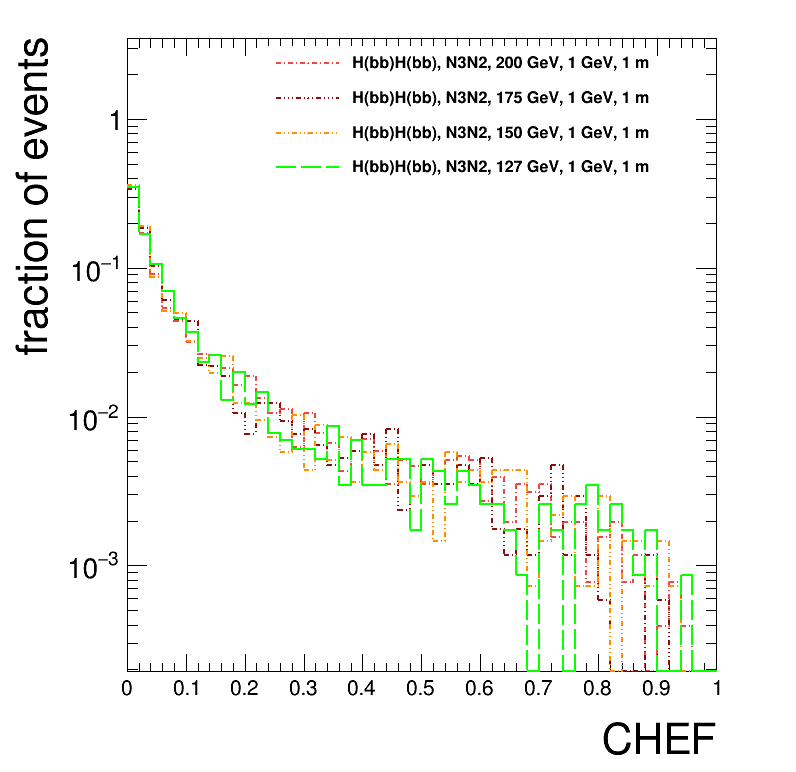

In [12]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_chef[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['CHEF', 'fraction of events'], name="", binning=[50,0,1.], weights=trg_flat_w[k])
    ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'chef_trg.png')

H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266b4d7a90>
[0.0301319  0.13981465 0.1166039  0.04700831 0.10471972 0.34917346
 0.16369808 0.01770502 0.1861394  0.327316  ]
H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f266558de80>
[0.09288269 0.0556547  0.23454842 0.16752607 0.04712086 0.21801704
 0.31698576 0.06067294 0.03562031 0.33612755]
H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664f40748>
[0.7253352  0.05280185 0.06268857 0.15920326 0.4101548  0.22399832
 0.06259133 0.32083103 0.18003805 0.17749043]
H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f2664a4dfd0>
[0.03578017 0.2860448  0.43741658 0.26387873 0.06849383 0.35594702
 0.27743268 0.01884884 0.22021884 0.03997065]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200212/dr_trg.png has been created


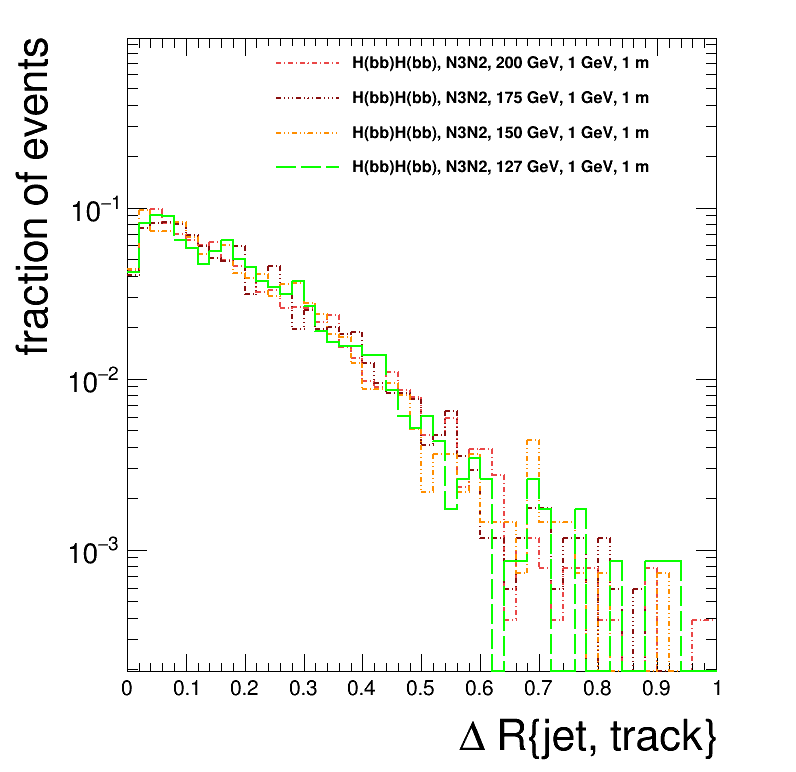

In [13]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_dr[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['#Delta R{jet, track}', 'fraction of events'], name="", binning=[50,0,1.], weights=trg_flat_w[k])
    ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'dr_trg.png')

# BKG each

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[188.02153 195.58482 200.01787 235.485   171.62817 153.06876 176.85132
 225.03677 226.73633 170.90762]
1111924
1111924
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[204.58347 152.59097 161.24606 151.29924 173.04391 160.67166 168.44327
 151.2127  160.34781 154.01474]
11599956
11599956
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[151.6057  151.75766 150.01349 169.46861 163.08176 151.08159 182.62756
 153.672   179.24133 150.57364]
967169
967169
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[280.2716  156.49886 164.48952 242.15868 174.01158 192.62206 296.15747
 401.75815 366.23953 244.76256]
2838
2838


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/met.png has been created


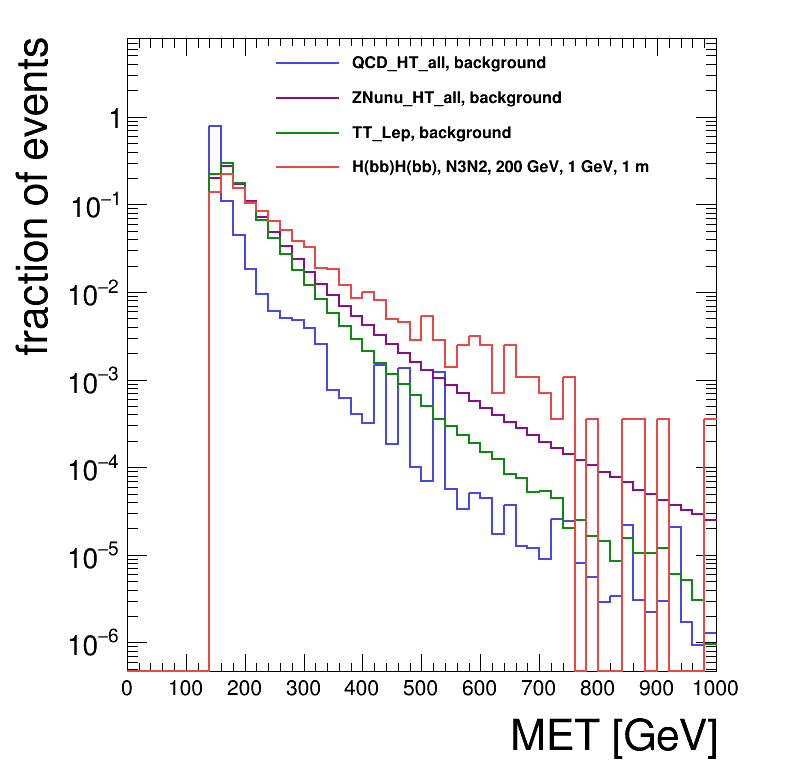

In [28]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = pf_jet_met[k]

    print(j_gamma_all[:10])
    print(j_gamma_all.size)
    print(pf_jet_w[k].size)

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=pf_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[195.58482 200.01787 235.485   176.85132 225.03677 226.73633 170.90762
 150.76726 181.8741  156.7494 ]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[204.58347 152.59097 161.24606 151.29924 173.04391 160.67166 168.44327
 151.2127  154.01474 169.34465]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[151.6057  150.01349 169.46861 163.08176 151.08159 153.672   179.24133
 176.81258 169.41403 183.62381]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[280.2716  156.49886 164.48952 242.15868 192.62206 296.15747 401.75815
 244.76256 299.01434 194.55235]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/met_trg.png has been created


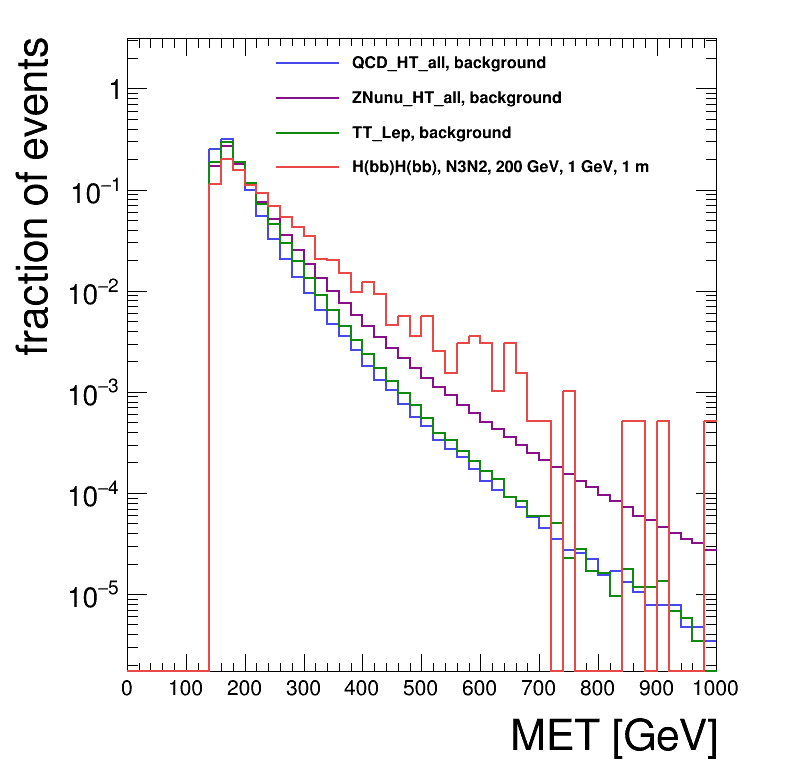

In [29]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_met[k]

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=trg_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_trg.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[449.44427, 89.419235, 65.13261, 541.0342, 447.42792, 81.933624, 59.52555, 46.955116, 36.336708, 268.03952]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[47.201454, 66.95824, 61.258503, 131.45676, 38.89826, 100.04287, 42.445408, 91.31202, 35.74933, 130.81636]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[211.28867, 166.52567, 99.65507, 71.779045, 46.68502, 137.53146, 104.92231, 96.09831, 32.96819, 32.875233]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[68.67287, 52.03112, 295.94345, 199.29875, 358.53384, 97.55133, 133.11708, 32.556133, 413.9756, 339.0396]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/pt.png has been created


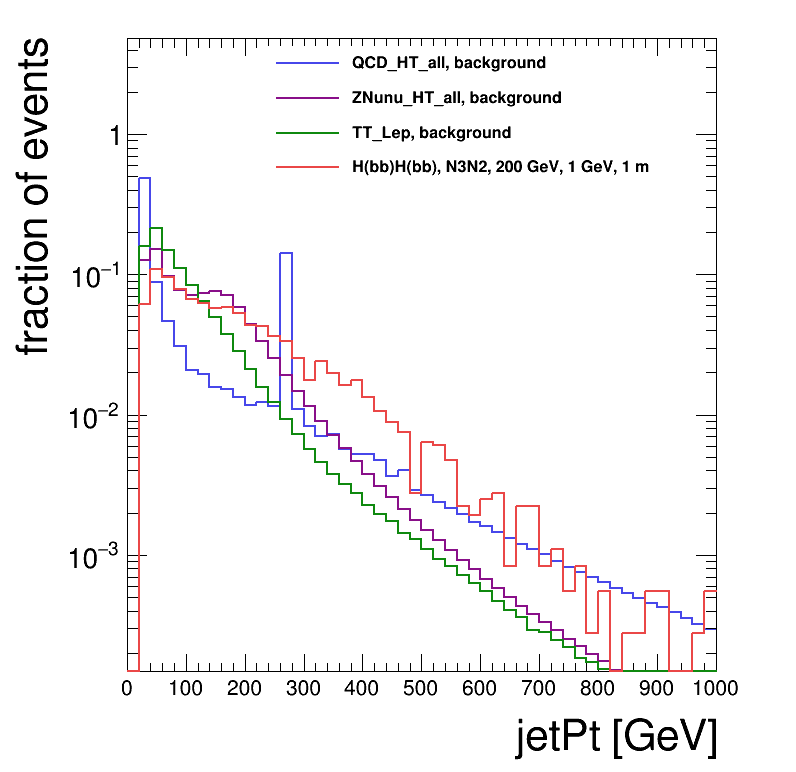

In [32]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

#     j_gamma_all = pf_jet_pt[k].flatten()
    j_gamma_all = list(chain.from_iterable(pf_jet_pt[k])) 

    print(j_gamma_all[:10])
    
#     pf_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(pf_jet_w[k],pf_jet_pt[k])]
#     pf_flat_w[k] = list(chain.from_iterable(pf_flat_w[k])) 
    

    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=pf_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'pt.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[449.44427 541.0342  268.03952 312.2129  351.1619  557.2025  162.82571
 355.04816 666.9414  606.15125]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[ 47.201454  66.95824  131.45676  100.04287   91.31202  130.81636
  70.976166 154.10574  114.84916  141.7706  ]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[211.28867  166.52567  137.53146  183.22604  128.87177   67.29938
  99.533066 196.20079  122.17174  127.772255]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[ 68.67287  295.94345  199.29875  358.53384   97.55133  133.11708
  32.556133 413.9756   339.0396   276.2872  ]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/pt_leading.png has been created


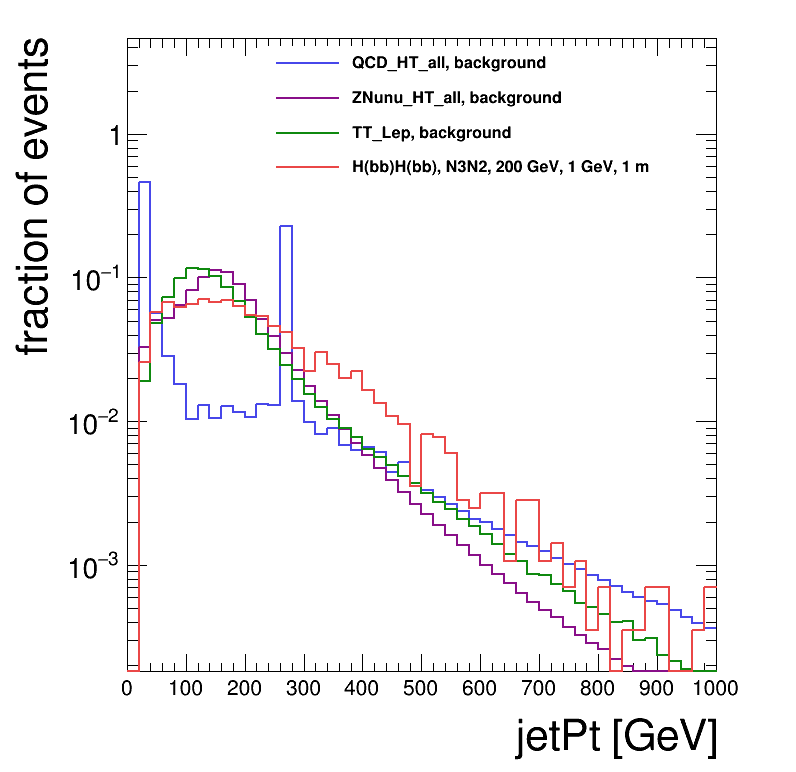

In [33]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = pf_jet_pt[k][:,0]

    print(j_gamma_all[:10])
    
#     pf_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(pf_jet_w[k],pf_jet_pt[k])]
#     pf_flat_w[k] = list(chain.from_iterable(pf_flat_w[k])) 
    

    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=pf_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'pt_leading.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[-0.11641043, -0.2953805, -0.24736953, -0.29345584, -0.25702915, 0.083430424, 0.05777456, -0.3132942, nan, 0.31226492]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[0.008280941, -0.84947085, -3.303501, -0.30564097, 0.02795852, -0.45256358, -1.1582073, -0.08619488, 0.10408484, -0.039831277]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[-0.6125788, 0.28477195, -0.086750105, 0.13659881, -0.8089556, 0.13608512, 0.038498316, 0.0910256, 0.10539791, 0.13140532]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[-0.0021034658, 0.823035, nan, 0.39988494, 0.41254196, 0.30903146, -2.5595973, nan, 0.8526288, nan]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/t.png has been created


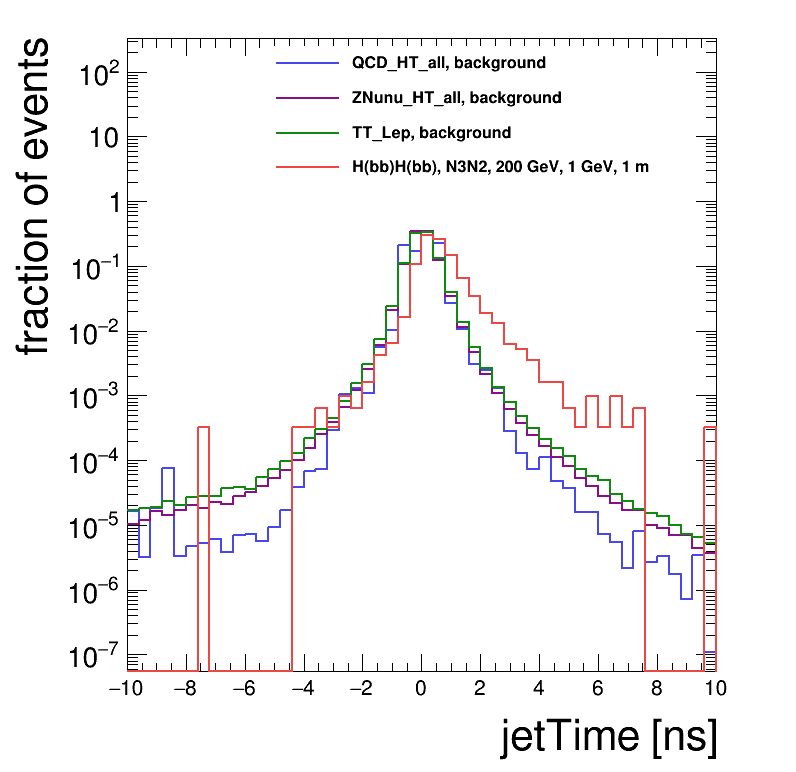

In [35]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

#     j_gamma_all = pf_jet_pt[k].flatten()
    j_gamma_all = list(chain.from_iterable(pf_jet_t[k])) 

    print(j_gamma_all[:10])
    
#     pf_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(pf_jet_w[k],pf_jet_pt[k])]
#     pf_flat_w[k] = list(chain.from_iterable(pf_flat_w[k])) 
    

    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetTime [ns]', 'fraction of events'], name="", binning=[50,-10,10], weights=pf_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+3*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'t.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[0.51677203, 0.6094584, 0.32811716, 0.5743586, 0.6911064, 0.56685555, 0.44838944, 0.21610153, 0.548659, 0.56389445]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[0.71806216, 0.4877094, 0.35431084, 0.4237065, 0.5714859, 0.47502568, 0.39987886, 0.37431213, 0.07679294, 0.7484094]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[0.22386822, 0.36489692, 0.9098446, 0.43752703, 0.21663943, 0.121566325, 0.45201102, 0.4086313, 0.5087918, 0.29928845]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[0.022484139, 0.04815962, 0.049839895, 0.015589297, 0.0064908816, 0.012041678, 0.025235731, 0.039598912, 0.002666611, 0.0041421833]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/tmf.png has been created


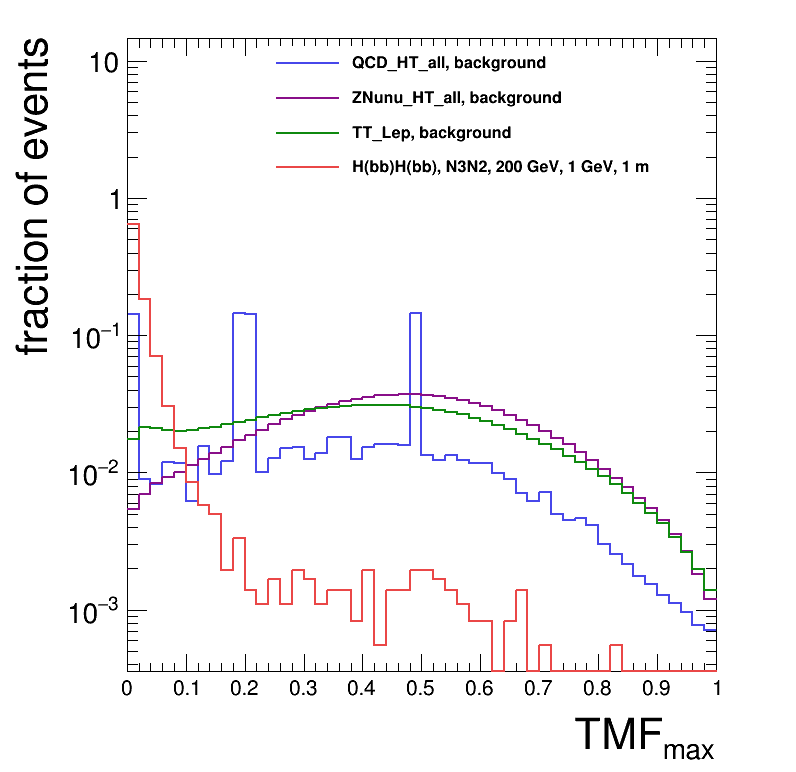

In [36]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

#     j_gamma_all = pf_jet_pt[k].flatten()
    j_gamma_all = list(chain.from_iterable(pf_jet_tmf[k])) 

    print(j_gamma_all[:10])
    
#     pf_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(pf_jet_w[k],pf_jet_pt[k])]
#     pf_flat_w[k] = list(chain.from_iterable(pf_flat_w[k])) 
    

    ht[k] = create_TH1D( j_gamma_all, axis_title=['TMF_{max}', 'fraction of events'], name="", binning=[50,-0,1], weights=pf_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+2*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'tmf.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[0.621513, 0.17066386, 0.5673641, 0.6373679, 0.7321582, 0.75510126, 0.51083463, 0.29625708, 0.8172237, 0.66705304]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[0.8268643, 0.8185433, 0.89619875, 0.6358966, 0.6916931, 0.537019, 0.6877389, 0.40639752, 0.57673323, 0.78392]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[0.5464954, 0.6184184, 0.95525146, 0.62364525, 0.2820151, 0.42264467, 0.6287831, 0.72003347, 0.07704376, 0.54069364]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[0.41022068, 0.074458055, 0.010816481, 0.06726882, 0.016421976, 0.03607481, 0.02045011, 0.09526476, 0.0025011513, 0.010529854]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/chef.png has been created


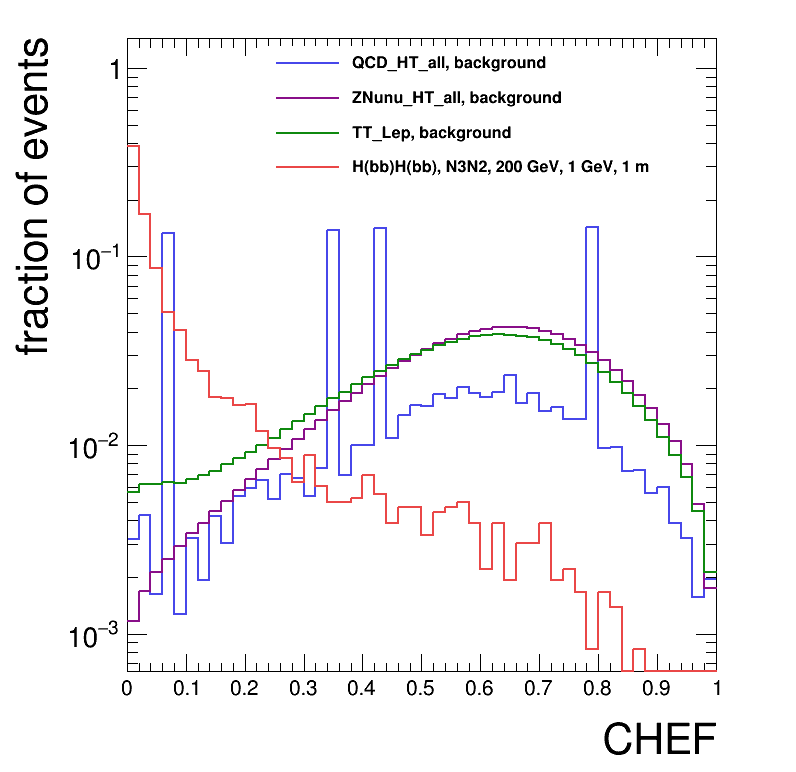

In [37]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

#     j_gamma_all = pf_jet_pt[k].flatten()
    j_gamma_all = list(chain.from_iterable(pf_jet_chef[k])) 

    print(j_gamma_all[:10])
    
#     pf_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(pf_jet_w[k],pf_jet_pt[k])]
#     pf_flat_w[k] = list(chain.from_iterable(pf_flat_w[k])) 
    

    ht[k] = create_TH1D( j_gamma_all, axis_title=[' CHEF', 'fraction of events'], name="", binning=[50,-0,1], weights=pf_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'chef.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[0.015571537, 0.0103176115, 0.040281266, 0.008274987, 0.011002683, 0.039857697, 0.050143108, 0.010222203, 0.1833169, 0.019610351]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[0.033866912, 0.03647582, 0.057962593, 0.02484853, 0.041745108, 0.015069529, 0.1178815, 0.050796222, 0.10635544, 0.005902683]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[0.021421248, 0.0653834, 0.027976008, 0.07487005, 0.074161984, 0.059749518, 0.014708433, 0.07811523, 0.04972692, 0.082814194]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[0.030131903, 0.13981465, 0.1166039, 0.047008313, 0.10471972, 0.23839918, 0.34917346, 0.16369808, 0.017705023, 0.30498242]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/dr.png has been created


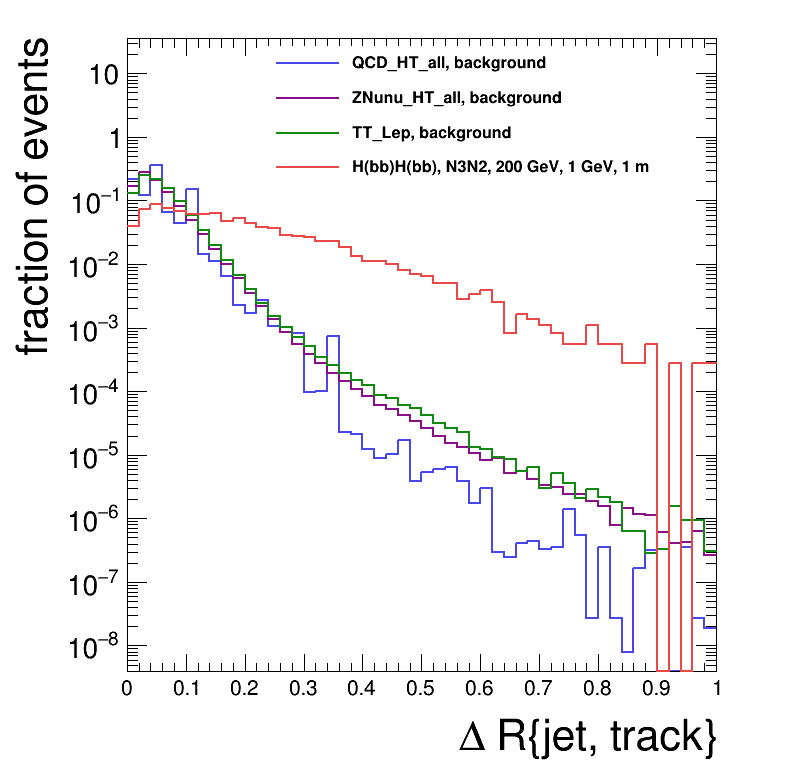

In [38]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

#     j_gamma_all = pf_jet_pt[k].flatten()
    j_gamma_all = list(chain.from_iterable(pf_jet_dr[k])) 

    print(j_gamma_all[:10])
    
#     pf_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(pf_jet_w[k],pf_jet_pt[k])]
#     pf_flat_w[k] = list(chain.from_iterable(pf_flat_w[k])) 
    

    ht[k] = create_TH1D( j_gamma_all, axis_title=['#Delta R{jet, track}', 'fraction of events'], name="", binning=[50,-0,1], weights=pf_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+2*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'dr.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[541.0342, 447.42792, 81.933624, 59.52555, 46.955116, 36.336708, 268.03952, 128.13936, 125.63229, 32.900238]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[47.201454, 66.95824, 61.258503, 131.45676, 38.89826, 100.04287, 42.445408, 91.31202, 35.74933, 130.81636]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[211.28867, 137.53146, 104.92231, 96.09831, 32.96819, 32.875233, 183.22604, 69.331184, 61.19324, 32.636852]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[68.67287, 52.03112, 295.94345, 199.29875, 358.53384, 133.11708, 32.556133, 413.9756, 276.2872, 71.74189]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/pt_trg.png has been created


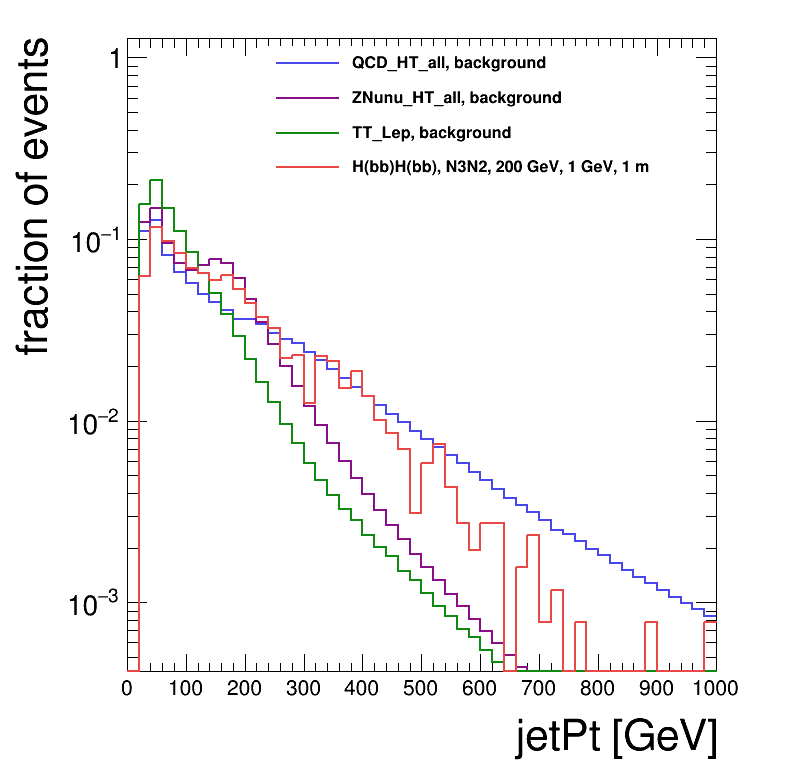

In [30]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = list(chain.from_iterable(trg_jet_pt[k])) 
#     j_gamma_all = trg_jet_pt[k].flatten()

    print(j_gamma_all[:10])
    
#     trg_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
#     trg_flat_w[k] = list(chain.from_iterable(trg_flat_w[k])) 
    
    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=trg_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'pt_trg.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[541.0342  268.03952 312.2129  162.82571 355.04816 666.9414  606.15125
 298.74094 305.1246  583.74054]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[ 47.201454  66.95824  131.45676  100.04287   91.31202  130.81636
  70.976166 154.10574  141.7706   198.31317 ]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[211.28867  137.53146  183.22604  128.87177   67.29938  196.20079
 122.17174   92.10686  255.67455   58.702553]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[ 68.67287  295.94345  199.29875  358.53384  133.11708   32.556133
 413.9756   276.2872    71.74189  391.05832 ]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/pt_leading_trg.png has been created


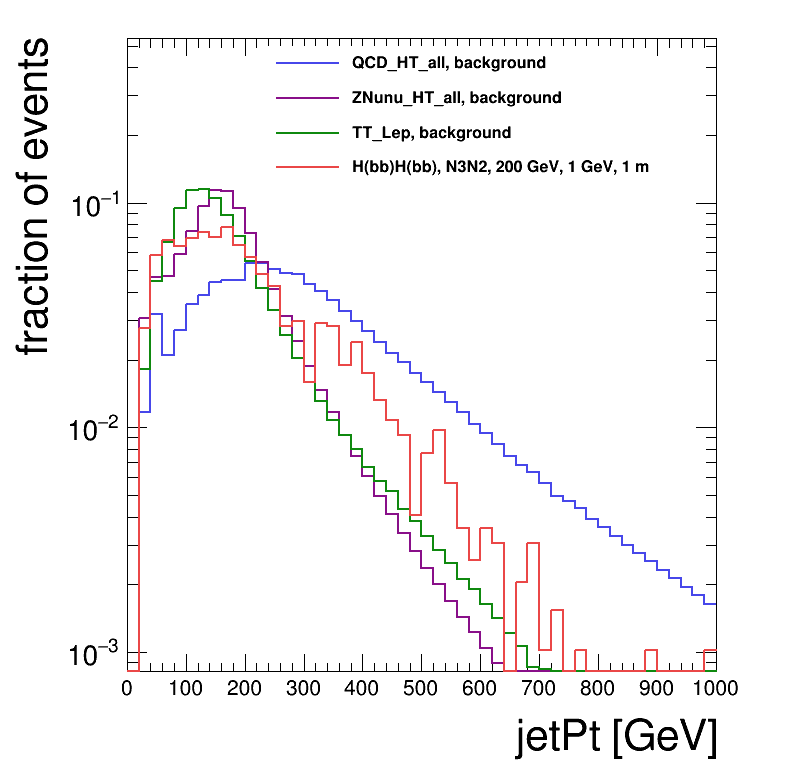

In [31]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_pt[k][:,0]

    print(j_gamma_all[:10])
    
#     trg_flat_w[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
#     trg_flat_w[k] = list(chain.from_iterable(trg_flat_w[k])) 
    
    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000], weights=trg_jet_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'pt_leading_trg.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[-0.29345584 -0.25702915  0.08343042  0.05777456 -0.3132942          nan
  0.31226492 -0.20962417 -0.12499946  0.05519063]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[ 0.00828094 -0.84947085 -3.303501   -0.30564097  0.02795852 -0.45256358
 -1.1582073  -0.08619488  0.10408484 -0.03983128]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[-0.6125788   0.13608512  0.03849832  0.0910256   0.10539791  0.13140532
  0.14430381 -1.6097556  -0.1828985   0.9810954 ]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[-2.1034658e-03  8.2303500e-01            nan  3.9988494e-01
  4.1254196e-01 -2.5595973e+00            nan  8.5262883e-01
  4.2623413e-01  7.9870656e-02]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/t_trg.png has been created


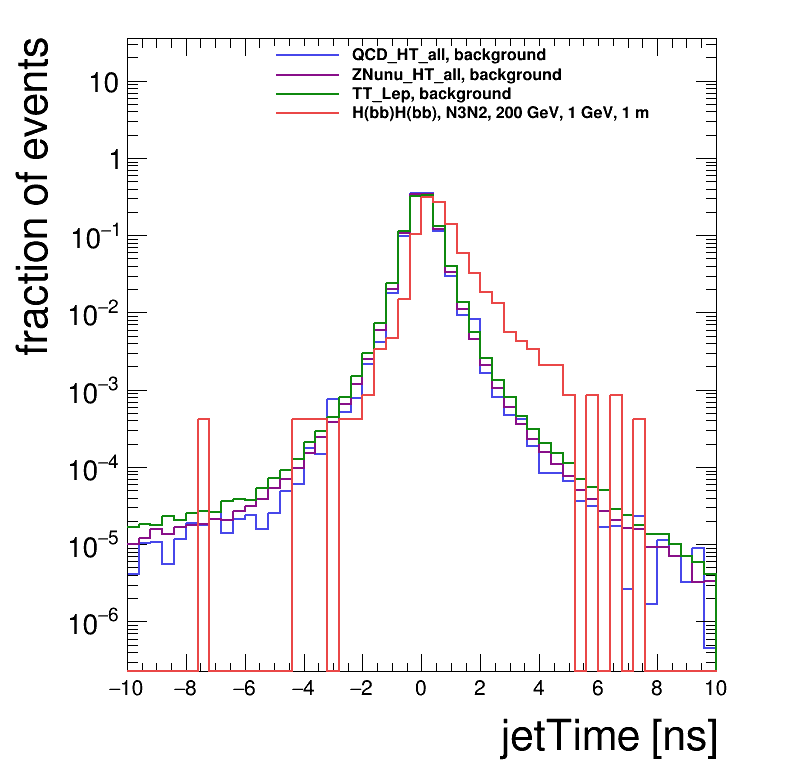

In [40]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.84,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_t[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['jetTime [ns]', 'fraction of events'], name="", binning=[50,-10,10], weights=trg_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+2*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'t_trg.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[0.5743586  0.6911064  0.56685555 0.44838944 0.21610153 0.548659
 0.56389445 0.76201355 0.1216097  1.784096  ]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[0.71806216 0.4877094  0.35431084 0.4237065  0.5714859  0.47502568
 0.39987886 0.37431213 0.07679294 0.7484094 ]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[0.22386822 0.12156633 0.45201102 0.4086313  0.5087918  0.29928845
 0.5034607  0.07678312 0.02174621 0.7645234 ]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[0.02248414 0.04815962 0.0498399  0.0155893  0.00649088 0.02523573
 0.03959891 0.00266661 0.00591551 0.04546637]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/tmf_trg.png has been created


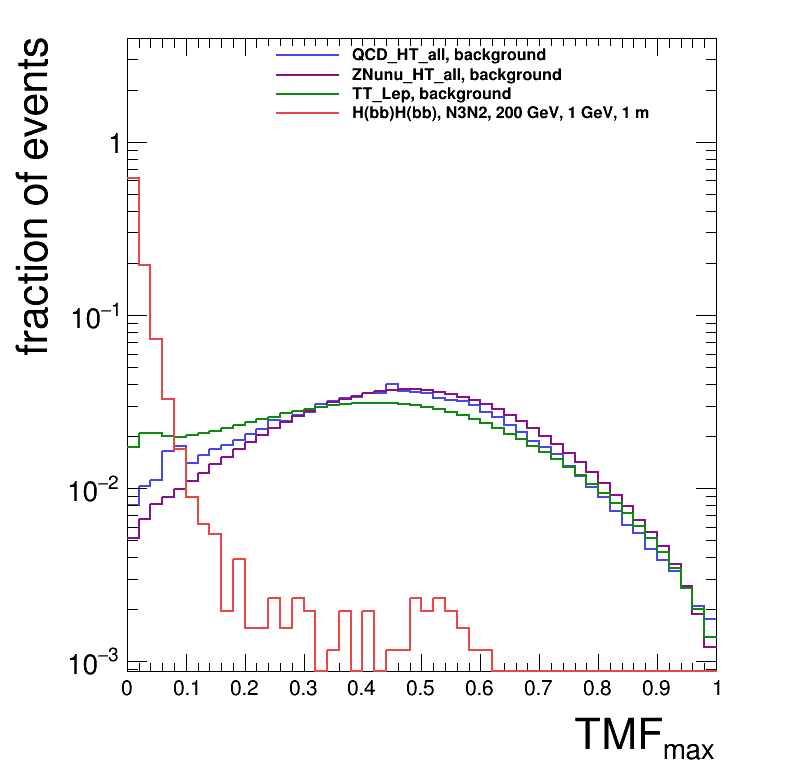

In [41]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.84,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_tmf[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['TMF_{max}', 'fraction of events'], name="", binning=[50,0,1.], weights=trg_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+2*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'tmf_trg.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[0.6373679  0.7321582  0.75510126 0.51083463 0.29625708 0.8172237
 0.66705304 0.81831783 0.6974     0.8150918 ]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[0.8268643  0.8185433  0.89619875 0.6358966  0.6916931  0.537019
 0.6877389  0.40639752 0.57673323 0.78392   ]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[0.5464954  0.42264467 0.6287831  0.72003347 0.07704376 0.54069364
 0.633442   0.5700696  0.05637213 0.8879352 ]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[0.41022068 0.07445806 0.01081648 0.06726882 0.01642198 0.02045011
 0.09526476 0.00250115 0.01627934 0.0722428 ]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/chef_trg.png has been created


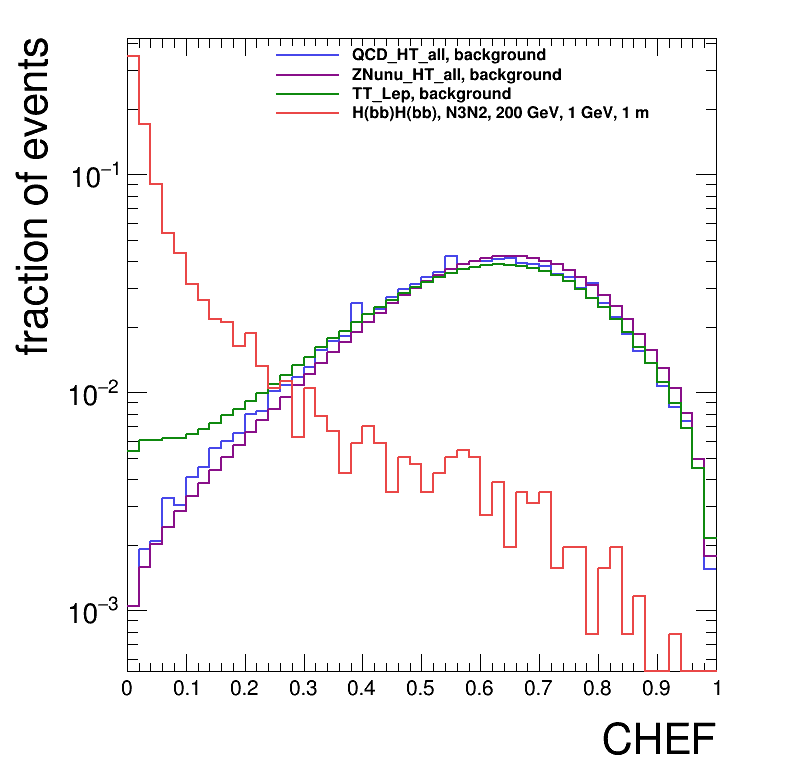

In [42]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.84,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_chef[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['CHEF', 'fraction of events'], name="", binning=[50,0,1.], weights=trg_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'chef_trg.png')

QCD_HT_all, background <TTree b'SusyLLPTree' at 0x7fba41926080>
[0.00827499 0.01100268 0.0398577  0.05014311 0.0102222  0.1833169
 0.01961035 0.01841061 0.02969832 0.0523929 ]
ZNunu_HT_all, background <TTree b'SusyLLPTree' at 0x7fb8b1665f28>
[0.03386691 0.03647582 0.05796259 0.02484853 0.04174511 0.01506953
 0.1178815  0.05079622 0.10635544 0.00590268]
TT_Lep, background <TTree b'SusyLLPTree' at 0x7fba41b16240>
[0.02142125 0.05974952 0.01470843 0.07811523 0.04972692 0.08281419
 0.09031977 0.06877883 0.03454338 0.07485198]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fba422932b0>
[0.0301319  0.13981465 0.1166039  0.04700831 0.10471972 0.34917346
 0.16369808 0.01770502 0.1861394  0.327316  ]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/dr_trg.png has been created


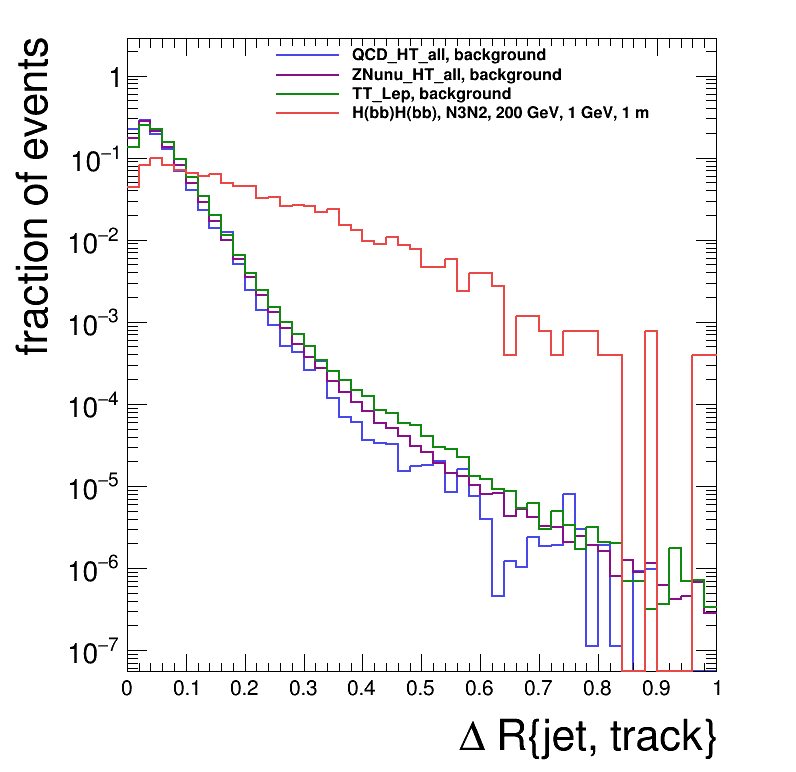

In [43]:
## PLOT

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.84,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    j_gamma_all = trg_jet_dr[k].flatten()

    print(j_gamma_all[:10])

    ht[k] = create_TH1D( j_gamma_all, axis_title=['#Delta R{jet, track}', 'fraction of events'], name="", binning=[50,0,1.], weights=trg_flat_w[k])
#     ht[k].SetLineStyle(stys[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.04)
    ht[k].SetMaximum(1e+1*(ht[k].GetMaximum()))

    ht[k].DrawNormalized('Histsame')

    leg.AddEntry(ht[k], k)

    i += 1


leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'dr_trg.png')

# ROC

In [30]:
flat_jet_t = {}
flat_jet_tmf = {}
flat_jet_chef = {}
flat_jet_dr = {}

for k,v in tree.items():
    print(k,v)
    
    flat_jet_t[k] = trg_jet_t[k].flatten()
    flat_jet_tmf[k] = trg_jet_tmf[k].flatten()
    flat_jet_chef[k] = trg_jet_chef[k].flatten()
    flat_jet_dr[k] = trg_jet_dr[k].flatten()
    

All, background <TTree b'SusyLLPTree' at 0x7f5d46517e10>
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f5d46573080>


In [52]:
### ROC curve
var_pf = [flat_jet_dr,   flat_jet_chef, flat_jet_tmf, flat_jet_t ]
axis_pf = [['PFJet PV tracks #Delta R_{min}','Events'],  ['CHEF','Events'],['PFJet TMF_{MAX}','Events'] , ['PFJet time [ns]', 'Events'] ]
name_pf = ['pfjetMinDeltaRPVTracks', 'CHEF','pfjetGammaMax_ET', 'pfjetTime'  ]
bins_pf = [[50,0,10], [50,0,1.5],[50,0,1.5],[50,0,10], [50, -5, 5]]
maxs_pf = [10,   1.5, 1.5, 50]

sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',]
qcd_key = 'QCD_HT_all, background'
calo = 0
pt_cut =100
for sig_k in sig_keys:
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.15,0.19,0.46,0.34)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
    purity = {}
    if calo:
        var = var_calo
        name = name_calo
        axis = axis_calo
        maxs = maxs_calo
    else:
        var = var_pf
        name = name_pf
        axis = axis_pf
        maxs = maxs_pf
        
    for i in range(len(var)):
        v = var[i]
        eff = {}
        thre = maxs[i]*np.array(range(1,1000))/1000.0
        if name[i]=='pfjetTime':
            print('IT IS TIME')
            thre = -5 + 10*np.array(range(1,1000))/1000.0
            
        print(maxs[i],name[i],'thre range',np.max(thre),np.min(thre))
        print(name[i])
        for k in tree.keys():
            v = var[i][k]
            print(k,len(v))
            if len(v)==0:
                print('no')
                eff[k] = []
                for th in thre:
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0)
                    else:
                        eff[k].append(1.0)
                eff[k] = np.array(eff[k])
            else:
                eff[k] = []
                for th in thre:
#                     if 'MinDeltaR' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     elif 'Time' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     else:
#                         eff[k].append(1.0*np.count_nonzero(v<th)/len(v))
             
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    elif 'Time' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    else:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v<th])/np.sum(trg_flat_w[k]))
                eff[k] = np.array(eff[k])
    #     Plotting ROC curve
        gr[name[i]] = create_TGraph(eff[qcd_key],eff[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        print(len(eff[qcd_key]))
        print(eff[qcd_key][:10])
        print(min(eff[qcd_key]))
        print(max(eff[qcd_key]))
        print(min(eff[qcd_key]))
        print(eff[sig_k][:10])
        print(min(eff[sig_k]))
        print(max(eff[sig_k]))
        gr[name[i]].SetLineColor(std_color_list[i])
        gr[name[i]].SetLineWidth(2)
        gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
        gr[name[i]].GetXaxis().SetLimits(0.0, 1.0)

        leg.AddEntry(gr[name[i]],axis[i][0])

        gr[name[i]].Draw('ac' if i==0 else 'c')

    leg.SetHeader('Signal jet matched, pt > ' +str(pt_cut) + ' GeV, BKG QCD')

    leg.Draw()
#     c.SetLogx()
    c.Draw()
#     c.SaveAs(out_dir+'ROC_QCD.png')

10 pfjetMinDeltaRPVTracks thre range 9.99 0.01
pfjetMinDeltaRPVTracks
QCD_HT_all, background 2092845


KeyboardInterrupt: 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


10 pfjetMinDeltaRPVTracks thre range 9.99 0.01
pfjetMinDeltaRPVTracks
WLNu, background 691501
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.94998567 0.83154762 0.69143931 0.55788056 0.44195734 0.34724595
 0.27107683 0.21090772 0.16346457 0.12669098]
0.0
0.9499856696215433
0.0
[0.98753411 0.95675893 0.92481497 0.87612003 0.82547723 0.77834044
 0.73665752 0.69731196 0.65952463 0.62719121]
0.0
0.9875341135091955
1.5 CHEF thre range 1.4985 0.0015
CHEF
WLNu, background 691501
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.00147505 0.00165148 0.00195661 0.00232682 0.00280115 0.00329139
 0.00380187 0.00434706 0.00486188 0.00540129]
0.001475050973048599
1.0
0.001475050973048599
[0.02571095 0.04324113 0.07908063 0.10946631 0.13790416 0.1714063
 0.2002337  0.23061939 0.25827812 0.27853523]
0.025710946765268212
1.0
1.5 pfjetGammaMax_ET thre range 1.4985 0.0015
pfjetGammaMax_ET
WLNu, background 691501
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.00768617 0.00769774 0.00776571 0.0079421

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.97369496 0.97369496 0.97369496 0.97369496 0.97369496 0.97369347
 0.97369206 0.97369206 0.97368767 0.97368626]
0.00033116341315180307
0.973694962741016
0.00033116341315180307
[0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924
 0.9181924 0.9181924 0.9181924]
0.0027269187815179767
0.9181923963921598


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/ROC_WLNu_logx.png has been created


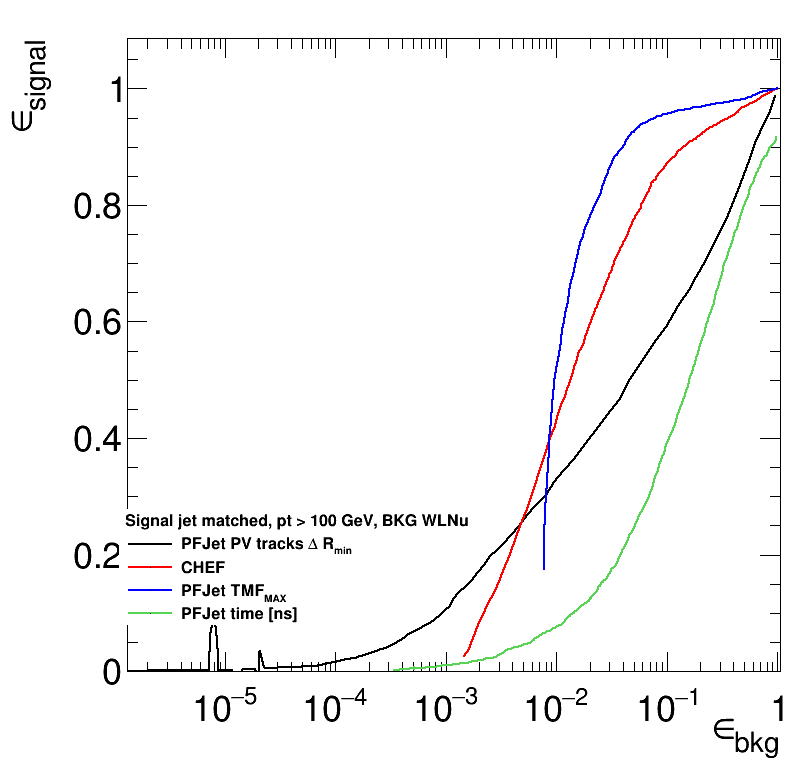

In [7]:
### ROC curve
var_pf = [flat_jet_dr,   flat_jet_chef, flat_jet_tmf, flat_jet_t ]
axis_pf = [['PFJet PV tracks #Delta R_{min}','Events'],  ['CHEF','Events'],['PFJet TMF_{MAX}','Events'] , ['PFJet time [ns]', 'Events'] ]
name_pf = ['pfjetMinDeltaRPVTracks', 'CHEF','pfjetGammaMax_ET', 'pfjetTime'  ]
bins_pf = [[50,0,10], [50,0,1.5],[50,0,1.5],[50,0,10], [50, -5, 5]]
maxs_pf = [10,   1.5, 1.5, 50]

sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',]
qcd_key = 'WLNu, background'
calo = 0
pt_cut =100
for sig_k in sig_keys:
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.15,0.19,0.46,0.34)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
    purity = {}
    if calo:
        var = var_calo
        name = name_calo
        axis = axis_calo
        maxs = maxs_calo
    else:
        var = var_pf
        name = name_pf
        axis = axis_pf
        maxs = maxs_pf
        
    for i in range(len(var)):
        v = var[i]
        eff = {}
        thre = maxs[i]*np.array(range(1,1000))/1000.0
        if name[i]=='pfjetTime':
            print('IT IS TIME')
            thre = -5 + 10*np.array(range(1,1000))/1000.0
            
        print(maxs[i],name[i],'thre range',np.max(thre),np.min(thre))
        print(name[i])
        for k in tree.keys():
            v = var[i][k]
            print(k,len(v))
            if len(v)==0:
                print('no')
                eff[k] = []
                for th in thre:
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0)
                    else:
                        eff[k].append(1.0)
                eff[k] = np.array(eff[k])
            else:
                eff[k] = []
                for th in thre:
#                     if 'MinDeltaR' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     elif 'Time' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     else:
#                         eff[k].append(1.0*np.count_nonzero(v<th)/len(v))
             
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    elif 'Time' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    else:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v<th])/np.sum(trg_flat_w[k]))
                eff[k] = np.array(eff[k])
    #     Plotting ROC curve
        gr[name[i]] = create_TGraph(eff[qcd_key],eff[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        print(len(eff[qcd_key]))
        print(eff[qcd_key][:10])
        print(min(eff[qcd_key]))
        print(max(eff[qcd_key]))
        print(min(eff[qcd_key]))
        print(eff[sig_k][:10])
        print(min(eff[sig_k]))
        print(max(eff[sig_k]))
        gr[name[i]].SetLineColor(std_color_list[i])
        gr[name[i]].SetLineWidth(2)
        gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
        gr[name[i]].GetXaxis().SetLimits(0.0, 1.0)

        leg.AddEntry(gr[name[i]],axis[i][0])

        gr[name[i]].Draw('ac' if i==0 else 'c')

    leg.SetHeader('Signal jet matched, pt > ' +str(pt_cut) + ' GeV, BKG WLNu')

    leg.Draw()
    c.SetLogx()
    c.Draw()
#     c.SaveAs(out_dir+'ROC_WLNu.png')   
    c.SaveAs(out_dir+'ROC_WLNu_logx.png')

10 pfjetMinDeltaRPVTracks thre range 9.99 0.01
pfjetMinDeltaRPVTracks
ZNunu_HT_all, background 23821201
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.94883152 0.82712575 0.68423438 0.54910379 0.43292534 0.33781405
 0.26180359 0.20218019 0.15578584 0.11998439]
0.0
0.9488315245349691
0.0
[0.98753411 0.95675893 0.92481497 0.87612003 0.82547723 0.77834044
 0.73665752 0.69731196 0.65952463 0.62719121]
0.0
0.9875341135091955
1.5 CHEF thre range 1.4985 0.0015
CHEF
ZNunu_HT_all, background 23821201
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.00013757 0.00016165 0.00019937 0.00025385 0.00031944 0.00039072
 0.00046945 0.00055358 0.00063774 0.00072707]
0.00013756693677540336
1.0
0.00013756693677540336
[0.02571095 0.04324113 0.07908063 0.10946631 0.13790416 0.1714063
 0.2002337  0.23061939 0.25827812 0.27853523]
0.025710946765268212
1.0
1.5 pfjetGammaMax_ET thre range 1.4985 0.0015
pfjetGammaMax_ET
ZNunu_HT_all, background 23821201
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.002536

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.98252165 0.98252032 0.98251929 0.98251832 0.98251662 0.98251581
 0.9825133  0.98251189 0.98251093 0.98250894]
0.00025362927555618774
0.982521650589116
0.00025362927555618774
[0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924
 0.9181924 0.9181924 0.9181924]
0.0027269187815179767
0.9181923963921598


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/ROC_ZNuNu.png has been created


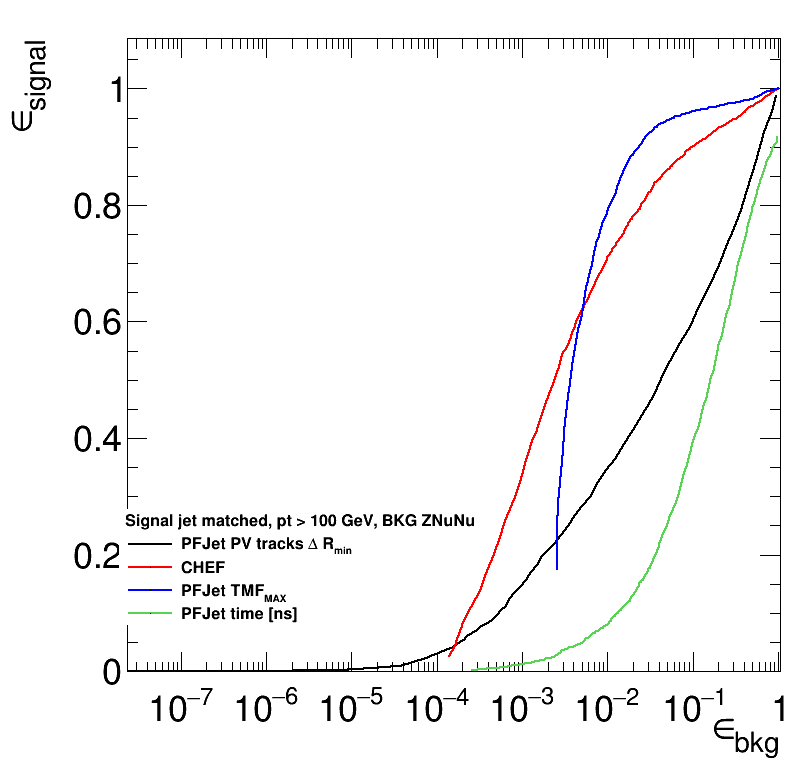

In [57]:
### ROC curve
var_pf = [flat_jet_dr,   flat_jet_chef, flat_jet_tmf, flat_jet_t ]
axis_pf = [['PFJet PV tracks #Delta R_{min}','Events'],  ['CHEF','Events'],['PFJet TMF_{MAX}','Events'] , ['PFJet time [ns]', 'Events'] ]
name_pf = ['pfjetMinDeltaRPVTracks', 'CHEF','pfjetGammaMax_ET', 'pfjetTime'  ]
bins_pf = [[50,0,10], [50,0,1.5],[50,0,1.5],[50,0,10], [50, -5, 5]]
maxs_pf = [10,   1.5, 1.5, 50]

sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',]
qcd_key = 'ZNunu_HT_all, background'
#         'TT_Lep, background',
#         'All, background',
calo = 0
pt_cut =100
for sig_k in sig_keys:
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.15,0.19,0.46,0.34)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
    purity = {}
    if calo:
        var = var_calo
        name = name_calo
        axis = axis_calo
        maxs = maxs_calo
    else:
        var = var_pf
        name = name_pf
        axis = axis_pf
        maxs = maxs_pf
        
    for i in range(len(var)):
        v = var[i]
        eff = {}
        thre = maxs[i]*np.array(range(1,1000))/1000.0
        if name[i]=='pfjetTime':
            print('IT IS TIME')
            thre = -5 + 10*np.array(range(1,1000))/1000.0
            
        print(maxs[i],name[i],'thre range',np.max(thre),np.min(thre))
        print(name[i])
        for k in tree.keys():
            v = var[i][k]
            print(k,len(v))
            if len(v)==0:
                print('no')
                eff[k] = []
                for th in thre:
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0)
                    else:
                        eff[k].append(1.0)
                eff[k] = np.array(eff[k])
            else:
                eff[k] = []
                for th in thre:
#                     if 'MinDeltaR' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     elif 'Time' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     else:
#                         eff[k].append(1.0*np.count_nonzero(v<th)/len(v))
             
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    elif 'Time' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    else:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v<th])/np.sum(trg_flat_w[k]))
                eff[k] = np.array(eff[k])
    #     Plotting ROC curve
        gr[name[i]] = create_TGraph(eff[qcd_key],eff[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        print(len(eff[qcd_key]))
        print(eff[qcd_key][:10])
        print(min(eff[qcd_key]))
        print(max(eff[qcd_key]))
        print(min(eff[qcd_key]))
        print(eff[sig_k][:10])
        print(min(eff[sig_k]))
        print(max(eff[sig_k]))
        gr[name[i]].SetLineColor(std_color_list[i])
        gr[name[i]].SetLineWidth(2)
        gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
        gr[name[i]].GetXaxis().SetLimits(0.0, 1.0)

        leg.AddEntry(gr[name[i]],axis[i][0])

        gr[name[i]].Draw('ac' if i==0 else 'c')

    leg.SetHeader('Signal jet matched, pt > ' +str(pt_cut) + ' GeV, BKG ZNuNu')

    leg.Draw()
    c.SetLogx()
    c.Draw()
    c.SaveAs(out_dir+'ROC_ZNuNu.png')

10 pfjetMinDeltaRPVTracks thre range 9.99 0.01
pfjetMinDeltaRPVTracks
TT_Lep, background 2892480
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.96286648 0.86671962 0.74275868 0.6143663  0.49608088 0.39353908
 0.30823777 0.23928262 0.18478342 0.14217384]
0.0
0.9628664795916592
0.0
[0.98753411 0.95675893 0.92481497 0.87612003 0.82547723 0.77834044
 0.73665752 0.69731196 0.65952463 0.62719121]
0.0
0.9875341135091955
1.5 CHEF thre range 1.4985 0.0015
CHEF
TT_Lep, background 2892480
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.00107097 0.00117474 0.00135709 0.00162396 0.00196798 0.00232949
 0.00271089 0.00310035 0.00351231 0.00391869]
0.001070969403774591
1.0
0.001070969403774591
[0.02571095 0.04324113 0.07908063 0.10946631 0.13790416 0.1714063
 0.2002337  0.23061939 0.25827812 0.27853523]
0.025710946765268212
1.0
1.5 pfjetGammaMax_ET thre range 1.4985 0.0015
pfjetGammaMax_ET
TT_Lep, background 2892480
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.01012448 0.01013268 0.01017122 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.97523529 0.9752336  0.97522978 0.97522842 0.97522638 0.97522536
 0.97522265 0.97522087 0.97521849 0.97521671]
0.00037277850771580434
0.9752352944521631
0.00037277850771580434
[0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924
 0.9181924 0.9181924 0.9181924]
0.0027269187815179767
0.9181923963921598


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/ROC_TT.png has been created


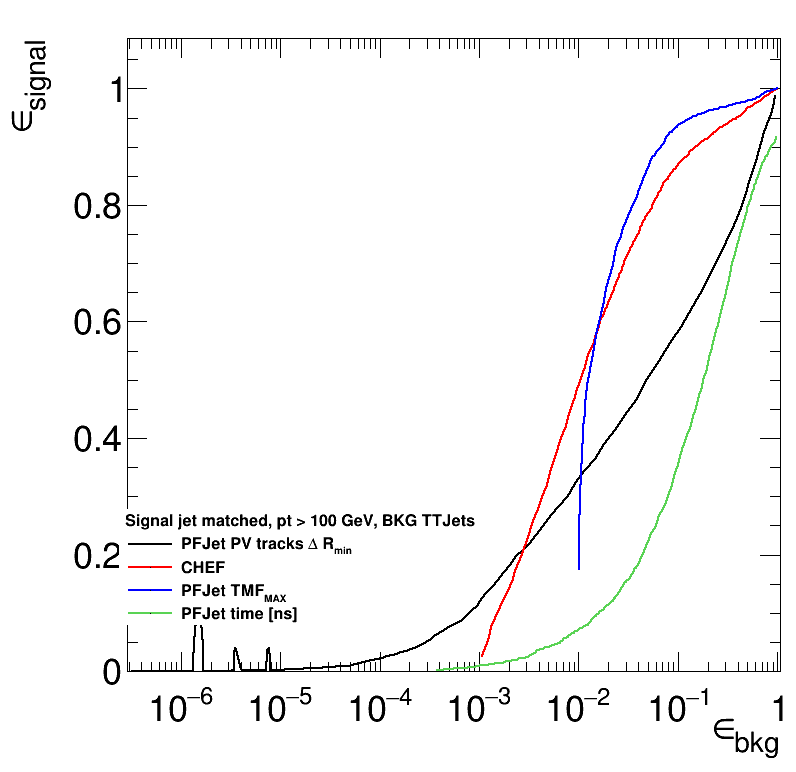

In [63]:
### ROC curve
var_pf = [flat_jet_dr,   flat_jet_chef, flat_jet_tmf, flat_jet_t ]
axis_pf = [['PFJet PV tracks #Delta R_{min}','Events'],  ['CHEF','Events'],['PFJet TMF_{MAX}','Events'] , ['PFJet time [ns]', 'Events'] ]
name_pf = ['pfjetMinDeltaRPVTracks', 'CHEF','pfjetGammaMax_ET', 'pfjetTime'  ]
bins_pf = [[50,0,10], [50,0,1.5],[50,0,1.5],[50,0,10], [50, -5, 5]]
maxs_pf = [10,   1.5, 1.5, 50]

sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',]
qcd_key =  'TT_Lep, background'
calo = 0
pt_cut =100
for sig_k in sig_keys:
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.15,0.19,0.46,0.34)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
    purity = {}
    if calo:
        var = var_calo
        name = name_calo
        axis = axis_calo
        maxs = maxs_calo
    else:
        var = var_pf
        name = name_pf
        axis = axis_pf
        maxs = maxs_pf
        
    for i in range(len(var)):
        v = var[i]
        eff = {}
        thre = maxs[i]*np.array(range(1,1000))/1000.0
        if name[i]=='pfjetTime':
            print('IT IS TIME')
            thre = -5 + 10*np.array(range(1,1000))/1000.0
            
        print(maxs[i],name[i],'thre range',np.max(thre),np.min(thre))
        print(name[i])
        for k in tree.keys():
            v = var[i][k]
            print(k,len(v))
            if len(v)==0:
                print('no')
                eff[k] = []
                for th in thre:
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0)
                    else:
                        eff[k].append(1.0)
                eff[k] = np.array(eff[k])
            else:
                eff[k] = []
                for th in thre:
#                     if 'MinDeltaR' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     elif 'Time' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     else:
#                         eff[k].append(1.0*np.count_nonzero(v<th)/len(v))
             
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    elif 'Time' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    else:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v<th])/np.sum(trg_flat_w[k]))
                eff[k] = np.array(eff[k])
    #     Plotting ROC curve
        gr[name[i]] = create_TGraph(eff[qcd_key],eff[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        print(len(eff[qcd_key]))
        print(eff[qcd_key][:10])
        print(min(eff[qcd_key]))
        print(max(eff[qcd_key]))
        print(min(eff[qcd_key]))
        print(eff[sig_k][:10])
        print(min(eff[sig_k]))
        print(max(eff[sig_k]))
        gr[name[i]].SetLineColor(std_color_list[i])
        gr[name[i]].SetLineWidth(2)
        gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
        gr[name[i]].GetXaxis().SetLimits(0.0, 1.0)

        leg.AddEntry(gr[name[i]],axis[i][0])

        gr[name[i]].Draw('ac' if i==0 else 'c')

    leg.SetHeader('Signal jet matched, pt > ' +str(pt_cut) + ' GeV, BKG TTJets')

    leg.Draw()
    c.SetLogx()
    c.Draw()
    c.SaveAs(out_dir+'ROC_TT.png')

10 pfjetMinDeltaRPVTracks thre range 9.99 0.01
pfjetMinDeltaRPVTracks
All, background 29498027
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.94482997 0.82132375 0.67992262 0.54657619 0.43221725 0.33830907
 0.26306809 0.20264343 0.15650003 0.12100328]
0.0
0.9448299671332094
0.0
[0.98753411 0.95675893 0.92481497 0.87612003 0.82547723 0.77834044
 0.73665752 0.69731196 0.65952463 0.62719121]
0.0
0.9875341135091955
1.5 CHEF thre range 1.4985 0.0015
CHEF
All, background 29498027
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.00086633 0.00098994 0.00117066 0.00139562 0.00168618 0.00198928
 0.00231011 0.00264089 0.00296212 0.0032967 ]
0.0008663329712472157
1.0
0.0008663329712472157
[0.02571095 0.04324113 0.07908063 0.10946631 0.13790416 0.1714063
 0.2002337  0.23061939 0.25827812 0.27853523]
0.025710946765268212
1.0
1.5 pfjetGammaMax_ET thre range 1.4985 0.0015
pfjetGammaMax_ET
All, background 29498027
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.00603211 0.00605247 0.00612684 0.00

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.97898579 0.97898519 0.97898441 0.97898338 0.97898277 0.97898182
 0.97897983 0.97897949 0.97897698 0.97897569]
0.0002867626301630323
0.9789857936554277
0.0002867626301630323
[0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924
 0.9181924 0.9181924 0.9181924]
0.0027269187815179767
0.9181923963921598


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200117/ROC_ALLBkg.png has been created


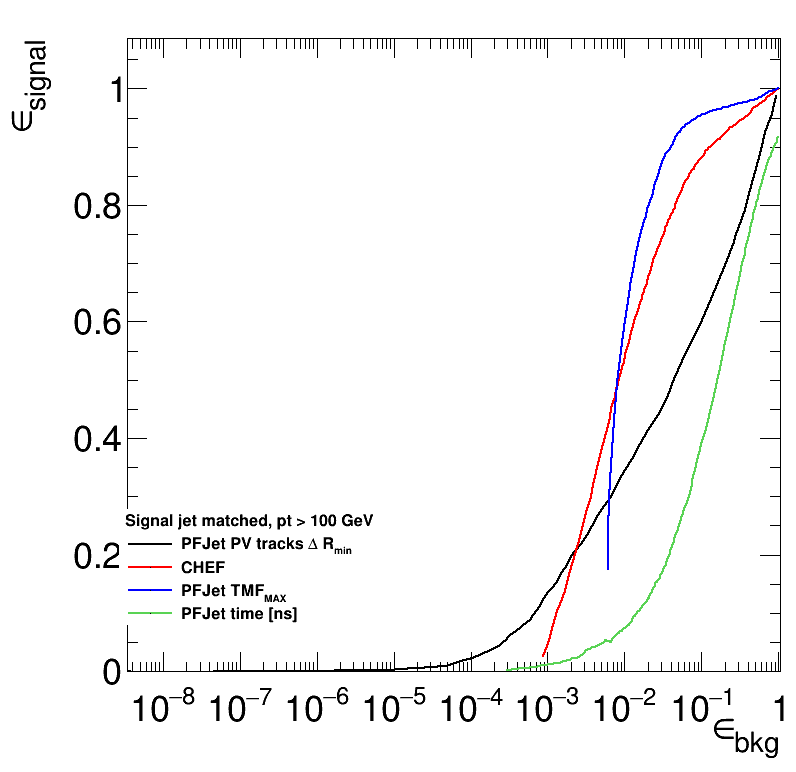

In [31]:
### ROC curve
var_pf = [flat_jet_dr,   flat_jet_chef, flat_jet_tmf, flat_jet_t ]
axis_pf = [['PFJet PV tracks #Delta R_{min}','Events'],  ['CHEF','Events'],['PFJet TMF_{MAX}','Events'] , ['PFJet time [ns]', 'Events'] ]
name_pf = ['pfjetMinDeltaRPVTracks', 'CHEF','pfjetGammaMax_ET', 'pfjetTime'  ]
bins_pf = [[50,0,10], [50,0,1.5],[50,0,1.5],[50,0,10], [50, -5, 5]]
maxs_pf = [10,   1.5, 1.5, 50]

sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',]
qcd_key = 'All, background'

calo = 0
pt_cut =100
for sig_k in sig_keys:
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.15,0.19,0.46,0.34)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
    purity = {}
    if calo:
        var = var_calo
        name = name_calo
        axis = axis_calo
        maxs = maxs_calo
    else:
        var = var_pf
        name = name_pf
        axis = axis_pf
        maxs = maxs_pf
        
    for i in range(len(var)):
        v = var[i]
        eff = {}
        thre = maxs[i]*np.array(range(1,1000))/1000.0
        if name[i]=='pfjetTime':
            print('IT IS TIME')
            thre = -5 + 10*np.array(range(1,1000))/1000.0
            
        print(maxs[i],name[i],'thre range',np.max(thre),np.min(thre))
        print(name[i])
        for k in tree.keys():
            v = var[i][k]
            print(k,len(v))
            if len(v)==0:
                print('no')
                eff[k] = []
                for th in thre:
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0)
                    else:
                        eff[k].append(1.0)
                eff[k] = np.array(eff[k])
            else:
                eff[k] = []
                for th in thre:
#                     if 'MinDeltaR' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     elif 'Time' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     else:
#                         eff[k].append(1.0*np.count_nonzero(v<th)/len(v))
             
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    elif 'Time' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    else:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v<th])/np.sum(trg_flat_w[k]))
                eff[k] = np.array(eff[k])
    #     Plotting ROC curve
        gr[name[i]] = create_TGraph(eff[qcd_key],eff[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        print(len(eff[qcd_key]))
        print(eff[qcd_key][:10])
        print(min(eff[qcd_key]))
        print(max(eff[qcd_key]))
        print(min(eff[qcd_key]))
        print(eff[sig_k][:10])
        print(min(eff[sig_k]))
        print(max(eff[sig_k]))
        gr[name[i]].SetLineColor(std_color_list[i])
        gr[name[i]].SetLineWidth(2)
        gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
        gr[name[i]].GetXaxis().SetLimits(0.0, 1.0)

        leg.AddEntry(gr[name[i]],axis[i][0])

        gr[name[i]].Draw('ac' if i==0 else 'c')

    leg.SetHeader('Signal jet matched, pt > ' +str(pt_cut) + ' GeV')

    leg.Draw()
    c.SetLogx()
    c.Draw()
#     c.SaveAs(out_dir+'ROC_ALLbkg.png')    
    c.SaveAs(out_dir+'ROC_ALLBkg.png')

# optimization

In [25]:
## optimization
i=0
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

sig_bins = [0,1,2]


space = [
          Real(0, 10, name='jet_time'),
          Real(0.0,1.5, name='jet_tmf'),
          Real(0.0,1.5,name='jetMinDeltaRPVTracks'),
          Real(0.0,1.5,name = 'jet_chef')
          ]

def figure_of_merit(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50, chef_cut = -50):
    nTags = {}
    sig_count = [] 
    bkg_count = np.zeros((3,))
    
    for k,T in trg_jet_tmf.items():
#         start_t = time.time()
        nTags[k] = []
        tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
        tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
        tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)
#         nTags[k] = [len(x) for x in pf_jet_pt[k][tagged_jet]] #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.array(nTags[k])
        print(k, tagged_jet[:10])
        print(k, trg_jet_pt[k][:10])
        print(k, trg_jet_pt[k][tagged_jet][:10])
        print(k, 'count', trg_jet_pt[k][tagged_jet].count()[:10])
        nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.sum(w[tagged_jet])
#         nJets[k] = np.sum(w[w<8000000])
        print(k, 'nTags', nTags[k][:10])
        print(k, 'unique', np.unique(nTags[k]))
        nTags[k] = np.array(nTags[k])
            
        occurCount = []
        for i in sig_bins:
            print('sig bin', i)
            if i == 2:
#               #overflow bin
                tag_cut = nTags[k] >= i 
            else:
                tag_cut = nTags[k] == i
            w_sum = sum(trg_jet_w[k][tag_cut])
#             w_sum = sum(weight[k][tag_cut])
            print('sig bin', i, 'w_sum', w_sum)
            
            occurCount.append(w_sum)
        print(occurCount)
        occurCount = np.array(occurCount)
        
        if 'background' not in k :
            sig_count = list(occurCount[:2])
            sig_count.append(sum(occurCount[2:]))
            sig_count = np.array(sig_count)
        elif 'background' in k:
            bkg_count = bkg_count + occurCount

#     cond = np.logical_not(np.logical_or(sig_count < 5,bkg_count < 5))
    sig_count = sig_count*137000
    bkg_count = bkg_count*137000
    print("sig count", sig_count)
    print("bkg count", bkg_count)
    cond = sig_count > 5
    if not np.count_nonzero(cond) == len(sig_bins):
        return 1

#     return -1.0*np.sum(2*((s+b)*math.log(s/b+1)-s))**0.5

    # loss function: - significance  = - (sqrt(S/(S+B)))
    return -1.0 * np.sum(sig_count**2/(sig_count+bkg_count))**0.5

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
#     begt = time.time()
    fom = figure_of_merit(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'],chef_cut = X['jet_chef'])
#     fom = train(model, learning_rate=X['learning_rate'])
    return fom


# res_gp = gp_minimize(objective, space, n_calls=5, n_random_starts=1, random_state=123, verbose=True)
res_gp = gp_minimize(objective, space, n_calls=500, n_random_starts=100, random_state=123, verbose=True)


/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Iteration No: 1 started. Evaluating function at random point.
New configuration: {'jet_time': 7.129553205232273, 'jet_tmf': 0.6427063892802387, 'jetMinDeltaRPVTracks': 1.0363272825402927, 'jet_chef': 1.0787254652321598}


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 169.79247407938948
sig bin 1
sig bin 1 w_sum 1.7969545907655267
sig bin 2
sig bin 2 w_sum 0.008453199307993486
[169.79247407938948, 1.7969545907655267, 0.008453199307993486]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 1 0 0 0 0 0 0]
All, background nTags [0 0 0 1 0 0 0 0 0 0]
All, background unique [0 1 2 3 4 5 6 7 8]
sig bin 0
sig bin 0 w_sum 162.7391514519762
sig bin 1
sig bin 1 w_sum 8.168292299064678
sig bin 2
sig bin 2 w_sum 0.6904381184612696
[162.7391514519762, 8.168292299064678, 0.6904381184612696]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5978805313167
sig bin 1
sig bin 1 w_sum 1.3381400094658602e-06
sig bin 2
sig bin 2 w_sum 0
[171.5978805313167, 1.3381400094658602e-06, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45261290528714
sig bin 1
sig bin 1 w_sum 0.1449754576155975
sig bin 2
sig bin 2 w_sum 0.0002935065548399507
[171.45261290528714, 0.1449754576155975, 0.0002935065548399507]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59787793554864
sig bin 1
sig bin 1 w_sum 3.9339080792899495e-06
sig bin 2
sig bin 2 w_sum 0
[171.59787793554864, 3.9339080792899495e-06, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False True True False False] [True False False False] [False] ... [False False] [False False False True] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[81.933624 59.52555] [268.03952] [] ... [] [74.90998] []]
All, background count [2 1 0 2 0 0 1 0 1 0]
All, background nTags [2 1 0 2 0 0 1 0 1 0]
All, background unique [ 0  1  2  3  4  5  6  7  8  9 10 12]
sig bin 0
sig bin 0 w_sum 81.38185802821839
sig bin 1
sig bin 1 w_sum 61.312490619080656
sig bin 2
sig bin 2 w_sum 28.903533222630994
[81.38185802821839, 61.312490619080656, 28.903533222630994]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 168.19074073825405
sig bin 1
sig bin 1 w_sum 3.3729325350873296
sig bin 2
sig bin 2 w_sum 0.034208596132472735
[168.19074073825405, 3.3729325350873296, 0.034208596132472735]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 168.05988648130003
sig bin 1
sig bin 1 w_sum 3.4942332931385742
sig bin 2
sig bin 2 w_sum 0.043762095035535964
[168.05988648130003, 3.4942332931385742, 0.043762095035535964]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 168.11480692545493
sig bin 1
sig bin 1 w_sum 3.440384725381204
sig bin 2
sig bin 2 w_sum 0.04269021863811773
[168.11480692545493, 3.440384725381204, 0.04269021863811773]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276.287

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 168.25483918910743
sig bin 1
sig bin 1 w_sum 3.3109217651794474
sig bin 2
sig bin 2 w_sum 0.03212091518641458
[168.25483918910743, 3.3109217651794474, 0.03212091518641458]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276.2

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.518234270721
sig bin 1
sig bin 1 w_sum 0.07940608416302197
sig bin 2
sig bin 2 w_sum 0.00024151457319021574
[171.518234270721, 0.07940608416302197, 0.00024151457319021574]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 166.04745944242507
sig bin 1
sig bin 1 w_sum 5.459322523781605
sig bin 2
sig bin 2 w_sum 0.09109990327570117
[166.04745944242507, 5.459322523781605, 0.09109990327570117]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276.2

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 166.1064120038389
sig bin 1
sig bin 1 w_sum 5.4014551532322805
sig bin 2
sig bin 2 w_sum 0.09001471241093739
[166.1064120038389, 5.4014551532322805, 0.09001471241093739]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276.2

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 166.17834160883518
sig bin 1
sig bin 1 w_sum 5.3313951723899216
sig bin 2
sig bin 2 w_sum 0.08814508825670231
[166.17834160883518, 5.3313951723899216, 0.08814508825670231]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58242763546747
sig bin 1
sig bin 1 w_sum 0.015454233989284916
sig bin 2
sig bin 2 w_sum 0
[171.58242763546747, 0.015454233989284916, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.57204513420248
sig bin 1
sig bin 1 w_sum 0.025600835204308225
sig bin 2
sig bin 2 w_sum 0.0002359000500291586
[171.57204513420248, 0.025600835204308225, 0.0002359000500291586]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.54527293093213
sig bin 1
sig bin 1 w_sum 0.05236876209165686
sig bin 2
sig bin 2 w_sum 0.00024017643318074988
[171.54527293093213, 0.05236876209165686, 0.00024017643318074988]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.44245192018775
sig bin 1
sig bin 1 w_sum 0.15539327602875375
sig bin 2
sig bin 2 w_sum 3.6673240970230836e-05
[171.44245192018775, 0.15539327602875375, 3.6673240970230836e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.32945148693574
sig bin 1
sig bin 1 w_sum 0.2679633637864569
sig bin 2
sig bin 2 w_sum 0.00046701873617394085
[171.32945148693574, 0.2679633637864569, 0.00046701873617394085]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.33821130161454
sig bin 1
sig bin 1 w_sum 0.2592055558265791
sig bin 2
sig bin 2 w_sum 0.0004650120171731942
[171.33821130161454, 0.2592055558265791, 0.0004650120171731942]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34666137639582
sig bin 1
sig bin 1 w_sum 0.25076004047353706
sig bin 2
sig bin 2 w_sum 0.0004604525888680655
[171.34666137639582, 0.25076004047353706, 0.0004604525888680655]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5030890996679
sig bin 1
sig bin 1 w_sum 0.09475895315389948
sig bin 2
sig bin 2 w_sum 3.3816635550465435e-05
[171.5030890996679, 0.09475895315389948, 3.3816635550465435e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.41384742199344
sig bin 1
sig bin 1 w_sum 0.18372672862216177
sig bin 2
sig bin 2 w_sum 0.00030771884212299483
[171.41384742199344, 0.18372672862216177, 0.00030771884212299483]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.39883565862309
sig bin 1
sig bin 1 w_sum 0.19871804698236417
sig bin 2
sig bin 2 w_sum 0.00032816385237310897
[171.39883565862309, 0.19871804698236417, 0.00032816385237310897]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3060243510113
sig bin 1
sig bin 1 w_sum 0.29136917643615945
sig bin 2
sig bin 2 w_sum 0.0004883420109997871
[171.3060243510113, 0.29136917643615945, 0.0004883420109997871]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.41711519160123
sig bin 1
sig bin 1 w_sum 0.18045659503631484
sig bin 2
sig bin 2 w_sum 0.0003100828201922923
[171.41711519160123, 0.18045659503631484, 0.0003100828201922923]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.29699045280682
sig bin 1
sig bin 1 w_sum 0.3003986600417683
sig bin 2
sig bin 2 w_sum 0.0004927566098906766
[171.29699045280682, 0.3003986600417683, 0.0004927566098906766]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3051862798307
sig bin 1
sig bin 1 w_sum 0.2922180711431608
sig bin 2
sig bin 2 w_sum 0.0004775184845478009
[171.3051862798307, 0.2922180711431608, 0.0004775184845478009]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.29936848952048
sig bin 1
sig bin 1 w_sum 0.29803586145343175
sig bin 2
sig bin 2 w_sum 0.0004775184845478009
[171.29936848952048, 0.29803586145343175, 0.0004775184845478009]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.41601700117167
sig bin 1
sig bin 1 w_sum 0.1815571494439432
sig bin 2
sig bin 2 w_sum 0.00030771884212299483
[171.41601700117167, 0.1815571494439432, 0.00030771884212299483]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.43837020659618
sig bin 1
sig bin 1 w_sum 0.1592029181812613
sig bin 2
sig bin 2 w_sum 0.0003087446801828264
[171.43837020659618, 0.1592029181812613, 0.0003087446801828264]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4160414162474
sig bin 1
sig bin 1 w_sum 0.18154370427660282
sig bin 2
sig bin 2 w_sum 0.0002967489337954987
[171.4160414162474, 0.18154370427660282, 0.0002967489337954987]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34725640851616
sig bin 1
sig bin 1 w_sum 0.2502125645100932
sig bin 2
sig bin 2 w_sum 0.00041289643188591185
[171.34725640851616, 0.2502125645100932, 0.00041289643188591185]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.32562325571536
sig bin 1
sig bin 1 w_sum 0.27184517145698806
sig bin 2
sig bin 2 w_sum 0.00041344228587902876
[171.32562325571536, 0.27184517145698806, 0.00041344228587902876]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.27893608320272
sig bin 1
sig bin 1 w_sum 0.3184523610669636
sig bin 2
sig bin 2 w_sum 0.0004934251888819574
[171.27893608320272, 0.3184523610669636, 0.0004934251888819574]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.27850319706027
sig bin 1
sig bin 1 w_sum 0.3186652538636743
sig bin 2
sig bin 2 w_sum 0.0007134185345769595
[171.27850319706027, 0.3186652538636743, 0.0007134185345769595]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.2180657085699
sig bin 1
sig bin 1 w_sum 0.37902307712511174
sig bin 2
sig bin 2 w_sum 0.0007930837639271715
[171.2180657085699, 0.37902307712511174, 0.0007930837639271715]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.25591606267943
sig bin 1
sig bin 1 w_sum 0.34120964585421376
sig bin 2
sig bin 2 w_sum 0.0007561609250394952
[171.25591606267943, 0.34120964585421376, 0.0007561609250394952]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.26078802233266
sig bin 1
sig bin 1 w_sum 0.3363534701803097
sig bin 2
sig bin 2 w_sum 0.0007403769457035025
[171.26078802233266, 0.3363534701803097, 0.0007403769457035025]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.33459220864745
sig bin 1
sig bin 1 w_sum 0.2628246487936927
sig bin 2
sig bin 2 w_sum 0.0004650120171731942
[171.33459220864745, 0.2628246487936927, 0.0004650120171731942]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.33661816418365
sig bin 1
sig bin 1 w_sum 0.2607986932574988
sig bin 2
sig bin 2 w_sum 0.0004650120171731942
[171.33661816418365, 0.2607986932574988, 0.0004650120171731942]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.33853992863322
sig bin 1
sig bin 1 w_sum 0.25887692880790425
sig bin 2
sig bin 2 w_sum 0.0004650120171731942
[171.33853992863322, 0.25887692880790425, 0.0004650120171731942]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34122184168592
sig bin 1
sig bin 1 w_sum 0.2561950157552033
sig bin 2
sig bin 2 w_sum 0.0004650120171731942
[171.34122184168592, 0.2561950157552033, 0.0004650120171731942]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34373698250158
sig bin 1
sig bin 1 w_sum 0.25367987493951816
sig bin 2
sig bin 2 w_sum 0.0004650120171731942
[171.34373698250158, 0.25367987493951816, 0.0004650120171731942]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34586679414633
sig bin 1
sig bin 1 w_sum 0.2515546227230665
sig bin 2
sig bin 2 w_sum 0.0004604525888680655
[171.34586679414633, 0.2515546227230665, 0.0004604525888680655]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3484754193592
sig bin 1
sig bin 1 w_sum 0.24894654336412358
sig bin 2
sig bin 2 w_sum 0.0004599067348749486
[171.3484754193592, 0.24894654336412358, 0.0004599067348749486]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3488985547497
sig bin 1
sig bin 1 w_sum 0.24852340797365002
sig bin 2
sig bin 2 w_sum 0.0004599067348749486
[171.3488985547497, 0.24852340797365002, 0.0004599067348749486]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34965476814764
sig bin 1
sig bin 1 w_sum 0.24776719457570096
sig bin 2
sig bin 2 w_sum 0.0004599067348749486
[171.34965476814764, 0.24776719457570096, 0.0004599067348749486]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3501280959042
sig bin 1
sig bin 1 w_sum 0.24729386681913823
sig bin 2
sig bin 2 w_sum 0.0004599067348749486
[171.3501280959042, 0.24729386681913823, 0.0004599067348749486]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35063665189867
sig bin 1
sig bin 1 w_sum 0.24678531082466293
sig bin 2
sig bin 2 w_sum 0.0004599067348749486
[171.35063665189867, 0.24678531082466293, 0.0004599067348749486]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3515652157531
sig bin 1
sig bin 1 w_sum 0.2458567469702011
sig bin 2
sig bin 2 w_sum 0.0004599067348749486
[171.3515652157531, 0.2458567469702011, 0.0004599067348749486]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35268668362897
sig bin 1
sig bin 1 w_sum 0.24473527909436044
sig bin 2
sig bin 2 w_sum 0.0004599067348749486
[171.35268668362897, 0.24473527909436044, 0.0004599067348749486]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35318574349134
sig bin 1
sig bin 1 w_sum 0.2442404956151485
sig bin 2
sig bin 2 w_sum 0.0004556303517233573
[171.35318574349134, 0.2442404956151485, 0.0004556303517233573]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35454929222414
sig bin 1
sig bin 1 w_sum 0.24287694688235106
sig bin 2
sig bin 2 w_sum 0.0004556303517233573
[171.35454929222414, 0.24287694688235106, 0.0004556303517233573]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3550909449565
sig bin 1
sig bin 1 w_sum 0.2423352941499637
sig bin 2
sig bin 2 w_sum 0.0004556303517233573
[171.3550909449565, 0.2423352941499637, 0.0004556303517233573]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5285568302936
sig bin 1
sig bin 1 w_sum 0.06930646065330492
sig bin 2
sig bin 2 w_sum 1.8578510207589716e-05
[171.5285568302936, 0.06930646065330492, 1.8578510207589716e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.57545949763727
sig bin 1
sig bin 1 w_sum 0.022186471769494176
sig bin 2
sig bin 2 w_sum 0.0002359000500291586
[171.57545949763727, 0.022186471769494176, 0.0002359000500291586]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.46791797549963
sig bin 1
sig bin 1 w_sum 0.1296908324132673
sig bin 2
sig bin 2 w_sum 0.00027306154458983656
[171.46791797549963, 0.1296908324132673, 0.00027306154458983656]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.46176509923419
sig bin 1
sig bin 1 w_sum 0.13584370867876672
sig bin 2
sig bin 2 w_sum 0.00027306154458983656
[171.46176509923419, 0.13584370867876672, 0.00027306154458983656]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45514598673986
sig bin 1
sig bin 1 w_sum 0.1424310067824095
sig bin 2
sig bin 2 w_sum 0.00030487593528505386
[171.45514598673986, 0.1424310067824095, 0.00030487593528505386]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.44538195534568
sig bin 1
sig bin 1 w_sum 0.15219116943172395
sig bin 2
sig bin 2 w_sum 0.0003087446801828264
[171.44538195534568, 0.15219116943172395, 0.0003087446801828264]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.57230136027368
sig bin 1
sig bin 1 w_sum 0.025344609133131968
sig bin 2
sig bin 2 w_sum 0.0002359000500291586
[171.57230136027368, 0.025344609133131968, 0.0002359000500291586]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.42334511485433
sig bin 1
sig bin 1 w_sum 0.17416307078319804
sig bin 2
sig bin 2 w_sum 0.00037368382021440993
[171.42334511485433, 0.17416307078319804, 0.00037368382021440993]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.56801194482483
sig bin 1
sig bin 1 w_sum 0.029634024581962848
sig bin 2
sig bin 2 w_sum 0.0002359000500291586
[171.56801194482483, 0.029634024581962848, 0.0002359000500291586]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.51608358214037
sig bin 1
sig bin 1 w_sum 0.08154674699969888
sig bin 2
sig bin 2 w_sum 0.0002515403170946229
[171.51608358214037, 0.08154674699969888, 0.0002515403170946229]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5564289701482
sig bin 1
sig bin 1 w_sum 0.04121699925868327
sig bin 2
sig bin 2 w_sum 0.0002359000500291586
[171.5564289701482, 0.04121699925868327, 0.0002359000500291586]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.12320962244527
sig bin 1
sig bin 1 w_sum 0.4737140027055595
sig bin 2
sig bin 2 w_sum 0.0009582443084816816
[171.12320962244527, 0.4737140027055595, 0.0009582443084816816]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.1511601995465
sig bin 1
sig bin 1 w_sum 0.4458404537180627
sig bin 2
sig bin 2 w_sum 0.0008812161946600838
[171.1511601995465, 0.4458404537180627, 0.0008812161946600838]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.55631510704728
sig bin 1
sig bin 1 w_sum 0.041330862359568954
sig bin 2
sig bin 2 w_sum 0.0002359000500291586
[171.55631510704728, 0.041330862359568954, 0.0002359000500291586]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.22462098319454
sig bin 1
sig bin 1 w_sum 0.3724678025004238
sig bin 2
sig bin 2 w_sum 0.0007930837639271715
[171.22462098319454, 0.3724678025004238, 0.0007930837639271715]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.22339005999117
sig bin 1
sig bin 1 w_sum 0.37369872570377893
sig bin 2
sig bin 2 w_sum 0.0007930837639271715
[171.22339005999117, 0.37369872570377893, 0.0007930837639271715]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34944078576746
sig bin 1
sig bin 1 w_sum 0.24801041666909995
sig bin 2
sig bin 2 w_sum 0.0004306670215896702
[171.34944078576746, 0.24801041666909995, 0.0004306670215896702]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.21432747633125
sig bin 1
sig bin 1 w_sum 0.3827619779427174
sig bin 2
sig bin 2 w_sum 0.0007924151849358907
[171.21432747633125, 0.3827619779427174, 0.0007924151849358907]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.50209027156015
sig bin 1
sig bin 1 w_sum 0.09575778126165346
sig bin 2
sig bin 2 w_sum 3.3816635550465435e-05
[171.50209027156015, 0.09575778126165346, 3.3816635550465435e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4090984520377
sig bin 1
sig bin 1 w_sum 0.18844135358237324
sig bin 2
sig bin 2 w_sum 0.0003420638377065188
[171.4090984520377, 0.18844135358237324, 0.0003420638377065188]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.39628151998716
sig bin 1
sig bin 1 w_sum 0.20127017889933896
sig bin 2
sig bin 2 w_sum 0.00033017057137385564
[171.39628151998716, 0.20127017889933896, 0.00033017057137385564]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.53860640318084
sig bin 1
sig bin 1 w_sum 0.05903528984300266
sig bin 2
sig bin 2 w_sum 0.00024017643318074988
[171.53860640318084, 0.05903528984300266, 0.00024017643318074988]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 170.9262098344541
sig bin 1
sig bin 1 w_sum 0.6694820300682451
sig bin 2
sig bin 2 w_sum 0.002190004937382639
[170.9262098344541, 0.6694820300682451, 0.002190004937382639]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [71.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5803618956474
sig bin 1
sig bin 1 w_sum 0.017519973809378087
sig bin 2
sig bin 2 w_sum 0
[171.5803618956474, 0.017519973809378087, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3435169281292
sig bin 1
sig bin 1 w_sum 0.2538999293119062
sig bin 2
sig bin 2 w_sum 0.0004650120171731942
[171.3435169281292, 0.2538999293119062, 0.0004650120171731942]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59711847977005
sig bin 1
sig bin 1 w_sum 0.0007633896866536816
sig bin 2
sig bin 2 w_sum 0
[171.59711847977005, 0.0007633896866536816, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58845951531964
sig bin 1
sig bin 1 w_sum 0.009422354137097244
sig bin 2
sig bin 2 w_sum 0
[171.58845951531964, 0.009422354137097244, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5767120809169
sig bin 1
sig bin 1 w_sum 0.020933888489850005
sig bin 2
sig bin 2 w_sum 0.0002359000500291586
[171.5767120809169, 0.020933888489850005, 0.0002359000500291586]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59414824448788
sig bin 1
sig bin 1 w_sum 0.0037336249688131318
sig bin 2
sig bin 2 w_sum 0
[171.59414824448788, 0.0037336249688131318, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59482375172564
sig bin 1
sig bin 1 w_sum 0.003058117731054466
sig bin 2
sig bin 2 w_sum 0
[171.59482375172564, 0.003058117731054466, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.54903181200365
sig bin 1
sig bin 1 w_sum 0.048609881020123424
sig bin 2
sig bin 2 w_sum 0.00024017643318074988
[171.54903181200365, 0.048609881020123424, 0.00024017643318074988]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.51300127782596
sig bin 1
sig bin 1 w_sum 0.08484677499576776
sig bin 2
sig bin 2 w_sum 3.3816635550465435e-05
[171.51300127782596, 0.08484677499576776, 3.3816635550465435e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59638631606293
sig bin 1
sig bin 1 w_sum 0.0014955533937843768
sig bin 2
sig bin 2 w_sum 0
[171.59638631606293, 0.0014955533937843768, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.55506093832395
sig bin 1
sig bin 1 w_sum 0.04258075469980582
sig bin 2
sig bin 2 w_sum 0.00024017643318074988
[171.55506093832395, 0.04258075469980582, 0.00024017643318074988]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58678147905692
sig bin 1
sig bin 1 w_sum 0.011100390399825244
sig bin 2
sig bin 2 w_sum 0
[171.58678147905692, 0.011100390399825244, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59419752902872
sig bin 1
sig bin 1 w_sum 0.0036843404279949254
sig bin 2
sig bin 2 w_sum 0
[171.59419752902872, 0.0036843404279949254, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5818467889494
sig bin 1
sig bin 1 w_sum 0.0160350805073719
sig bin 2
sig bin 2 w_sum 0
[171.5818467889494, 0.0160350805073719, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58544943852422
sig bin 1
sig bin 1 w_sum 0.012432430932538097
sig bin 2
sig bin 2 w_sum 0
[171.58544943852422, 0.012432430932538097, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5892709392391
sig bin 1
sig bin 1 w_sum 0.00861093021766024
sig bin 2
sig bin 2 w_sum 0
[171.5892709392391, 0.00861093021766024, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58729072293727
sig bin 1
sig bin 1 w_sum 0.010591146519480787
sig bin 2
sig bin 2 w_sum 0
[171.58729072293727, 0.010591146519480787, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.57480496674853
sig bin 1
sig bin 1 w_sum 0.022841002658239518
sig bin 2
sig bin 2 w_sum 0.0002359000500291586
[171.57480496674853, 0.022841002658239518, 0.0002359000500291586]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5859799005318
sig bin 1
sig bin 1 w_sum 0.011901968924952655
sig bin 2
sig bin 2 w_sum 0
[171.5859799005318, 0.011901968924952655, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.57949179112748
sig bin 1
sig bin 1 w_sum 0.01839007832930406
sig bin 2
sig bin 2 w_sum 0
[171.57949179112748, 0.01839007832930406, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58931591799217
sig bin 1
sig bin 1 w_sum 0.00856595146458261
sig bin 2
sig bin 2 w_sum 0
[171.58931591799217, 0.00856595146458261, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59159106447214
sig bin 1
sig bin 1 w_sum 0.006290804984569576
sig bin 2
sig bin 2 w_sum 0
[171.59159106447214, 0.006290804984569576, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5828963226181
sig bin 1
sig bin 1 w_sum 0.014985546838687469
sig bin 2
sig bin 2 w_sum 0
[171.5828963226181, 0.014985546838687469, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59000543885332
sig bin 1
sig bin 1 w_sum 0.007876430603385387
sig bin 2
sig bin 2 w_sum 0
[171.59000543885332, 0.007876430603385387, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5943225616511
sig bin 1
sig bin 1 w_sum 0.003559307805598877
sig bin 2
sig bin 2 w_sum 0
[171.5943225616511, 0.003559307805598877, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5883521919029
sig bin 1
sig bin 1 w_sum 0.009529677553835825
sig bin 2
sig bin 2 w_sum 0
[171.5883521919029, 0.009529677553835825, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.577028443016
sig bin 1
sig bin 1 w_sum 0.020853426440829992
sig bin 2
sig bin 2 w_sum 0
[171.577028443016, 0.020853426440829992, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.57870503861798
sig bin 1
sig bin 1 w_sum 0.019176830838816272
sig bin 2
sig bin 2 w_sum 0
[171.57870503861798, 0.019176830838816272, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58004266484159
sig bin 1
sig bin 1 w_sum 0.01783920461520694
sig bin 2
sig bin 2 w_sum 0
[171.58004266484159, 0.01783920461520694, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.48255284701025
sig bin 1
sig bin 1 w_sum 0.11530523705206619
sig bin 2
sig bin 2 w_sum 2.3785395114828134e-05
[171.48255284701025, 0.11530523705206619, 2.3785395114828134e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59369688479381
sig bin 1
sig bin 1 w_sum 0.004184984662916946
sig bin 2
sig bin 2 w_sum 0
[171.59369688479381, 0.004184984662916946, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58662156665784
sig bin 1
sig bin 1 w_sum 0.011260302798930866
sig bin 2
sig bin 2 w_sum 0
[171.58662156665784, 0.011260302798930866, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58464987050147
sig bin 1
sig bin 1 w_sum 0.013231998955305357
sig bin 2
sig bin 2 w_sum 0
[171.58464987050147, 0.013231998955305357, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5932789668324
sig bin 1
sig bin 1 w_sum 0.0046029026243132876
sig bin 2
sig bin 2 w_sum 0
[171.5932789668324, 0.0046029026243132876, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 170.70110419677775
sig bin 1
sig bin 1 w_sum 0.8935543704730335
sig bin 2
sig bin 2 w_sum 0.0032233022091929797
[170.70110419677775, 0.8935543704730335, 0.0032233022091929797]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 170.93235947860816
sig bin 1
sig bin 1 w_sum 0.6640585069066525
sig bin 2
sig bin 2 w_sum 0.0014638839440443974
[170.93235947860816, 0.6640585069066525, 0.0014638839440443974]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.02517490505184
sig bin 1
sig bin 1 w_sum 0.5719199922337346
sig bin 2
sig bin 2 w_sum 0.0007869721729001355
[171.02517490505184, 0.5719199922337346, 0.0007869721729001355]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 170.80743826486548
sig bin 1
sig bin 1 w_sum 0.7879541052282342
sig bin 2
sig bin 2 w_sum 0.0024894993656197073
[170.80743826486548, 0.7879541052282342, 0.0024894993656197073]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.27873388853698
sig bin 1
sig bin 1 w_sum 0.3188457145906831
sig bin 2
sig bin 2 w_sum 0.0003022663303013928
[171.27873388853698, 0.3188457145906831, 0.0003022663303013928]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3820183063251
sig bin 1
sig bin 1 w_sum 0.21580716529468447
sig bin 2
sig bin 2 w_sum 5.639783772792839e-05
[171.3820183063251, 0.21580716529468447, 5.639783772792839e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4262541462842
sig bin 1
sig bin 1 w_sum 0.17159099915029685
sig bin 2
sig bin 2 w_sum 3.6724022834278e-05
[171.4262541462842, 0.17159099915029685, 3.6724022834278e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4488317935402
sig bin 1
sig bin 1 w_sum 0.1490187473741038
sig bin 2
sig bin 2 w_sum 3.132854300247345e-05
[171.4488317935402, 0.1490187473741038, 3.132854300247345e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.46964915303312
sig bin 1
sig bin 1 w_sum 0.12821306369987084
sig bin 2
sig bin 2 w_sum 1.9652724233765184e-05
[171.46964915303312, 0.12821306369987084, 1.9652724233765184e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.44200668325064
sig bin 1
sig bin 1 w_sum 0.15583865077873327
sig bin 2
sig bin 2 w_sum 3.653542790971187e-05
[171.44200668325064, 0.15583865077873327, 3.653542790971187e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.37401756636586
sig bin 1
sig bin 1 w_sum 0.2235738297671368
sig bin 2
sig bin 2 w_sum 0.00029047332457210473
[171.37401756636586, 0.2235738297671368, 0.00029047332457210473]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.42084357908408
sig bin 1
sig bin 1 w_sum 0.17697319241879228
sig bin 2
sig bin 2 w_sum 6.509795450782008e-05
[171.42084357908408, 0.17697319241879228, 6.509795450782008e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.44213091115125
sig bin 1
sig bin 1 w_sum 0.15571960867238488
sig bin 2
sig bin 2 w_sum 3.1349633662358656e-05
[171.44213091115125, 0.15571960867238488, 3.1349633662358656e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.53278513191086
sig bin 1
sig bin 1 w_sum 0.06509673754608514
sig bin 2
sig bin 2 w_sum 0
[171.53278513191086, 0.06509673754608514, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3097819280661
sig bin 1
sig bin 1 w_sum 0.2877674055504933
sig bin 2
sig bin 2 w_sum 0.00033253584119918855
[171.3097819280661, 0.2877674055504933, 0.00033253584119918855]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3078038306419
sig bin 1
sig bin 1 w_sum 0.2899030491900163
sig bin 2
sig bin 2 w_sum 0.0001749896258509409
[171.3078038306419, 0.2899030491900163, 0.0001749896258509409]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.50982021614647
sig bin 1
sig bin 1 w_sum 0.088044770606853
sig bin 2
sig bin 2 w_sum 1.6882703675946686e-05
[171.50982021614647, 0.088044770606853, 1.6882703675946686e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.24521858480009
sig bin 1
sig bin 1 w_sum 0.352310742636341
sig bin 2
sig bin 2 w_sum 0.00035254202160928116
[171.24521858480009, 0.352310742636341, 0.00035254202160928116]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.05468848236276
sig bin 1
sig bin 1 w_sum 0.5419429184310403
sig bin 2
sig bin 2 w_sum 0.001250468664785842
[171.05468848236276, 0.5419429184310403, 0.001250468664785842]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4361062131296
sig bin 1
sig bin 1 w_sum 0.1617289939559612
sig bin 2
sig bin 2 w_sum 4.666237174433263e-05
[171.4361062131296, 0.1617289939559612, 4.666237174433263e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [199.29875] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.20682127761248
sig bin 1
sig bin 1 w_sum 0.39083085917334515
sig bin 2
sig bin 2 w_sum 0.00022973267238413086
[171.20682127761248, 0.39083085917334515, 0.00022973267238413086]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 170.99625526876662
sig bin 1
sig bin 1 w_sum 0.6003464579768654
sig bin 2
sig bin 2 w_sum 0.0012801427157391743
[170.99625526876662, 0.6003464579768654, 0.0012801427157391743]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.38667992306037
sig bin 1
sig bin 1 w_sum 0.2111047767078702
sig bin 2
sig bin 2 w_sum 9.71696892406726e-05
[171.38667992306037, 0.2111047767078702, 9.71696892406726e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34295656926798
sig bin 1
sig bin 1 w_sum 0.25484020474454283
sig bin 2
sig bin 2 w_sum 8.509544517210088e-05
[171.34295656926798, 0.25484020474454283, 8.509544517210088e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.23219811726545
sig bin 1
sig bin 1 w_sum 0.36554614772285277
sig bin 2
sig bin 2 w_sum 0.00013760446980981555
[171.23219811726545, 0.36554614772285277, 0.00013760446980981555]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.06398255672008
sig bin 1
sig bin 1 w_sum 0.5332788413070588
sig bin 2
sig bin 2 w_sum 0.0006204714317448179
[171.06398255672008, 0.5332788413070588, 0.0006204714317448179]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.50742964436273
sig bin 1
sig bin 1 w_sum 0.09043644111499205
sig bin 2
sig bin 2 w_sum 1.5783979335992626e-05
[171.50742964436273, 0.09043644111499205, 1.5783979335992626e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.07698007797816
sig bin 1
sig bin 1 w_sum 0.5200666340475948
sig bin 2
sig bin 2 w_sum 0.0008351574332010614
[171.07698007797816, 0.5200666340475948, 0.0008351574332010614]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.30862274861374
sig bin 1
sig bin 1 w_sum 0.2891686994059093
sig bin 2
sig bin 2 w_sum 9.042143813076109e-05
[171.30862274861374, 0.2891686994059093, 9.042143813076109e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.411334109034
sig bin 1
sig bin 1 w_sum 0.1864782689605171
sig bin 2
sig bin 2 w_sum 6.949146273882434e-05
[171.411334109034, 0.1864782689605171, 6.949146273882434e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.33106512829602
sig bin 1
sig bin 1 w_sum 0.26645416043812276
sig bin 2
sig bin 2 w_sum 0.00036258072339023784
[171.33106512829602, 0.26645416043812276, 0.00036258072339023784]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35525253563384
sig bin 1
sig bin 1 w_sum 0.24254399556355466
sig bin 2
sig bin 2 w_sum 8.533826024859081e-05
[171.35525253563384, 0.24254399556355466, 8.533826024859081e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.38868253414762
sig bin 1
sig bin 1 w_sum 0.2091479308102535
sig bin 2
sig bin 2 w_sum 5.140449961871241e-05
[171.38868253414762, 0.2091479308102535, 5.140449961871241e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.46497557995104
sig bin 1
sig bin 1 w_sum 0.1328760476902957
sig bin 2
sig bin 2 w_sum 3.0241816091347573e-05
[171.46497557995104, 0.1328760476902957, 3.0241816091347573e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3291698021951
sig bin 1
sig bin 1 w_sum 0.2685426716433774
sig bin 2
sig bin 2 w_sum 0.00016939561929874003
[171.3291698021951, 0.2685426716433774, 0.00016939561929874003]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.32960687562013
sig bin 1
sig bin 1 w_sum 0.2679409311812897
sig bin 2
sig bin 2 w_sum 0.00033406265652047296
[171.32960687562013, 0.2679409311812897, 0.00033406265652047296]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 170.95979592741844
sig bin 1
sig bin 1 w_sum 0.6358368194043038
sig bin 2
sig bin 2 w_sum 0.002249122637103085
[170.95979592741844, 0.6358368194043038, 0.002249122637103085]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.38902473249948
sig bin 1
sig bin 1 w_sum 0.2088164333632747
sig bin 2
sig bin 2 w_sum 4.070359477736929e-05
[171.38902473249948, 0.2088164333632747, 4.070359477736929e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.55930048398923
sig bin 1
sig bin 1 w_sum 0.038567083340652175
sig bin 2
sig bin 2 w_sum 1.4302127055998426e-05
[171.55930048398923, 0.038567083340652175, 1.4302127055998426e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45545130941002
sig bin 1
sig bin 1 w_sum 0.14240007179924774
sig bin 2
sig bin 2 w_sum 3.048824811457962e-05
[171.45545130941002, 0.14240007179924774, 3.048824811457962e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4923774426145
sig bin 1
sig bin 1 w_sum 0.10548878657553118
sig bin 2
sig bin 2 w_sum 1.5640267065464286e-05
[171.4923774426145, 0.10548878657553118, 1.5640267065464286e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 170.92950866977185
sig bin 1
sig bin 1 w_sum 0.6670747001112396
sig bin 2
sig bin 2 w_sum 0.0012984995762899132
[170.92950866977185, 0.6670747001112396, 0.0012984995762899132]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5882433007319
sig bin 1
sig bin 1 w_sum 0.009638022870870344
sig bin 2
sig bin 2 w_sum 5.458539931169071e-07
[171.5882433007319, 0.009638022870870344, 5.458539931169071e-07]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34295617557797
sig bin 1
sig bin 1 w_sum 0.25476470786381356
sig bin 2
sig bin 2 w_sum 0.00016098601621550301
[171.34295617557797, 0.25476470786381356, 0.00016098601621550301]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.47519693190435
sig bin 1
sig bin 1 w_sum 0.12265454500811401
sig bin 2
sig bin 2 w_sum 3.039254471559616e-05
[171.47519693190435, 0.12265454500811401, 3.039254471559616e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.25482990498318
sig bin 1
sig bin 1 w_sum 0.34266965148320594
sig bin 2
sig bin 2 w_sum 0.00038231299173574484
[171.25482990498318, 0.34266965148320594, 0.00038231299173574484]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112]

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.18945584401104
sig bin 1
sig bin 1 w_sum 0.4078308666223549
sig bin 2
sig bin 2 w_sum 0.0005951588253090279
[171.18945584401104, 0.4078308666223549, 0.0005951588253090279]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [True] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [199.29875]

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.429204099424
sig bin 1
sig bin 1 w_sum 0.16855108711337863
sig bin 2
sig bin 2 w_sum 0.0001266829200403663
[171.429204099424, 0.16855108711337863, 0.0001266829200403663]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 169.34528308381994
sig bin 1
sig bin 1 w_sum 2.235062736020666
sig bin 2
sig bin 2 w_sum 0.017536049631960537
[169.34528308381994, 2.235062736020666, 0.017536049631960537]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199.29

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.44866501031842
sig bin 1
sig bin 1 w_sum 0.14917113276551675
sig bin 2
sig bin 2 w_sum 4.572637345745534e-05
[171.44866501031842, 0.14917113276551675, 4.572637345745534e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34170326430777
sig bin 1
sig bin 1 w_sum 0.2561185271621689
sig bin 2
sig bin 2 w_sum 6.0077987701134816e-05
[171.34170326430777, 0.2561185271621689, 6.0077987701134816e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.39611545358073
sig bin 1
sig bin 1 w_sum 0.20170049092519093
sig bin 2
sig bin 2 w_sum 6.592495168433743e-05
[171.39611545358073, 0.20170049092519093, 6.592495168433743e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.50076767917506
sig bin 1
sig bin 1 w_sum 0.09709743721649389
sig bin 2
sig bin 2 w_sum 1.6753065711583304e-05
[171.50076767917506, 0.09709743721649389, 1.6753065711583304e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5575682414654
sig bin 1
sig bin 1 w_sum 0.040299325864513236
sig bin 2
sig bin 2 w_sum 1.4302127055998426e-05
[171.5575682414654, 0.040299325864513236, 1.4302127055998426e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.25134210442707
sig bin 1
sig bin 1 w_sum 0.34626527362880566
sig bin 2
sig bin 2 w_sum 0.0002744914024113143
[171.25134210442707, 0.34626527362880566, 0.0002744914024113143]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.33066854062216
sig bin 1
sig bin 1 w_sum 0.26706851992618397
sig bin 2
sig bin 2 w_sum 0.0001448089093400995
[171.33066854062216, 0.26706851992618397, 0.0001448089093400995]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4200684755607
sig bin 1
sig bin 1 w_sum 0.17773689073354504
sig bin 2
sig bin 2 w_sum 7.650316325680251e-05
[171.4200684755607, 0.17773689073354504, 7.650316325680251e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5562084457486
sig bin 1
sig bin 1 w_sum 0.04165912158129359
sig bin 2
sig bin 2 w_sum 1.4302127055998426e-05
[171.5562084457486, 0.04165912158129359, 1.4302127055998426e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.28950711380867
sig bin 1
sig bin 1 w_sum 0.30819254827435927
sig bin 2
sig bin 2 w_sum 0.00018220737479168747
[171.28950711380867, 0.30819254827435927, 0.00018220737479168747]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.2774232530212
sig bin 1
sig bin 1 w_sum 0.3200733627242158
sig bin 2
sig bin 2 w_sum 0.0003852537127286837
[171.2774232530212, 0.3200733627242158, 0.0003852537127286837]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.28922418942318
sig bin 1
sig bin 1 w_sum 0.3085672164152413
sig bin 2
sig bin 2 w_sum 9.04636194505315e-05
[171.28922418942318, 0.3085672164152413, 9.04636194505315e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35299090746895
sig bin 1
sig bin 1 w_sum 0.24455467116494845
sig bin 2
sig bin 2 w_sum 0.0003362908239417095
[171.35299090746895, 0.24455467116494845, 0.0003362908239417095]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.3777640334123
sig bin 1
sig bin 1 w_sum 0.22000682627760781
sig bin 2
sig bin 2 w_sum 0.0001110097677496924
[171.3777640334123, 0.22000682627760781, 0.0001110097677496924]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.29963141316406
sig bin 1
sig bin 1 w_sum 0.2980421212938431
sig bin 2
sig bin 2 w_sum 0.00020833499990047244
[171.29963141316406, 0.2980421212938431, 0.00020833499990047244]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.47153677804732
sig bin 1
sig bin 1 w_sum 0.12631460316191934
sig bin 2
sig bin 2 w_sum 3.048824811457962e-05
[171.47153677804732, 0.12631460316191934, 3.048824811457962e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.26595162639262
sig bin 1
sig bin 1 w_sum 0.33183106737321566
sig bin 2
sig bin 2 w_sum 9.917569215289745e-05
[171.26595162639262, 0.33183106737321566, 9.917569215289745e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.2824188535174
sig bin 1
sig bin 1 w_sum 0.31535349223184994
sig bin 2
sig bin 2 w_sum 0.00010952370868366756
[171.2824188535174, 0.31535349223184994, 0.00010952370868366756]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.2257252931047
sig bin 1
sig bin 1 w_sum 0.3720168567040574
sig bin 2
sig bin 2 w_sum 0.00013971964951053906
[171.2257252931047, 0.3720168567040574, 0.00013971964951053906]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.26487287431019
sig bin 1
sig bin 1 w_sum 0.3328754991474234
sig bin 2
sig bin 2 w_sum 0.0001334960003767094
[171.26487287431019, 0.3328754991474234, 0.0001334960003767094]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35201266324438
sig bin 1
sig bin 1 w_sum 0.24577167000456512
sig bin 2
sig bin 2 w_sum 9.753620881980396e-05
[171.35201266324438, 0.24577167000456512, 9.753620881980396e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.23086193865905
sig bin 1
sig bin 1 w_sum 0.36666800863809
sig bin 2
sig bin 2 w_sum 0.000351922161225815
[171.23086193865905, 0.36666800863809, 0.000351922161225815]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4273086810046
sig bin 1
sig bin 1 w_sum 0.1705378954614325
sig bin 2
sig bin 2 w_sum 3.529299129922947e-05
[171.4273086810046, 0.1705378954614325, 3.529299129922947e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.33804686558426
sig bin 1
sig bin 1 w_sum 0.2596972955591106
sig bin 2
sig bin 2 w_sum 0.00013770831429837926
[171.33804686558426, 0.2596972955591106, 0.00013770831429837926]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.13967541839776
sig bin 1
sig bin 1 w_sum 0.45771872180745277
sig bin 2
sig bin 2 w_sum 0.00048772925378415266
[171.13967541839776, 0.45771872180745277, 0.00048772925378415266]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.41010892138775
sig bin 1
sig bin 1 w_sum 0.18767614472573158
sig bin 2
sig bin 2 w_sum 9.680334409267743e-05
[171.41010892138775, 0.18767614472573158, 9.680334409267743e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3498036303281
sig bin 1
sig bin 1 w_sum 0.24798070292085228
sig bin 2
sig bin 2 w_sum 9.753620881980396e-05
[171.3498036303281, 0.24798070292085228, 9.753620881980396e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35090710824147
sig bin 1
sig bin 1 w_sum 0.2468816396063538
sig bin 2
sig bin 2 w_sum 9.31216099289145e-05
[171.35090710824147, 0.2468816396063538, 9.31216099289145e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.1273047146181
sig bin 1
sig bin 1 w_sum 0.4701092635164237
sig bin 2
sig bin 2 w_sum 0.00046789132425573143
[171.1273047146181, 0.4701092635164237, 0.00046789132425573143]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3905637818278
sig bin 1
sig bin 1 w_sum 0.20722974429920882
sig bin 2
sig bin 2 w_sum 8.834333043594711e-05
[171.3905637818278, 0.20722974429920882, 8.834333043594711e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.32021658972673
sig bin 1
sig bin 1 w_sum 0.27753966403168917
sig bin 2
sig bin 2 w_sum 0.0001256156995985691
[171.32021658972673, 0.27753966403168917, 0.0001256156995985691]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.415812223741
sig bin 1
sig bin 1 w_sum 0.18199383323664975
sig bin 2
sig bin 2 w_sum 7.581247984944639e-05
[171.415812223741, 0.18199383323664975, 7.581247984944639e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45712687749068
sig bin 1
sig bin 1 w_sum 0.14067648867258598
sig bin 2
sig bin 2 w_sum 7.850329393477296e-05
[171.45712687749068, 0.14067648867258598, 7.850329393477296e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.37074906021874
sig bin 1
sig bin 1 w_sum 0.2270875988588692
sig bin 2
sig bin 2 w_sum 4.521038004057232e-05
[171.37074906021874, 0.2270875988588692, 4.521038004057232e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.48402502914354
sig bin 1
sig bin 1 w_sum 0.11382551177063505
sig bin 2
sig bin 2 w_sum 3.132854300247345e-05
[171.48402502914354, 0.11382551177063505, 3.132854300247345e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.39194509053561
sig bin 1
sig bin 1 w_sum 0.20585889543737323
sig bin 2
sig bin 2 w_sum 7.788348458603878e-05
[171.39194509053561, 0.20585889543737323, 7.788348458603878e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.200913261388
sig bin 1
sig bin 1 w_sum 0.396437126096572
sig bin 2
sig bin 2 w_sum 0.0005314819741606414
[171.200913261388, 0.396437126096572, 0.0005314819741606414]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199.2987

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.38306928625946
sig bin 1
sig bin 1 w_sum 0.21474292412055718
sig bin 2
sig bin 2 w_sum 6.965907754263867e-05
[171.38306928625946, 0.21474292412055718, 6.965907754263867e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.3190426775527
sig bin 1
sig bin 1 w_sum 0.27867690636139386
sig bin 2
sig bin 2 w_sum 0.00016228554368424852
[171.3190426775527, 0.27867690636139386, 0.00016228554368424852]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.08300238708574
sig bin 1
sig bin 1 w_sum 0.5142472353239569
sig bin 2
sig bin 2 w_sum 0.0006322470492285959
[171.08300238708574, 0.5142472353239569, 0.0006322470492285959]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45625753935036
sig bin 1
sig bin 1 w_sum 0.14159344294460752
sig bin 2
sig bin 2 w_sum 3.088716232468869e-05
[171.45625753935036, 0.14159344294460752, 3.088716232468869e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4110505230135
sig bin 1
sig bin 1 w_sum 0.18679131132470417
sig bin 2
sig bin 2 w_sum 4.0035119173609246e-05
[171.4110505230135, 0.18679131132470417, 4.0035119173609246e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.23265482947647
sig bin 1
sig bin 1 w_sum 0.3650499621932717
sig bin 2
sig bin 2 w_sum 0.00017707778839692878
[171.23265482947647, 0.3650499621932717, 0.00017707778839692878]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.43037599937912
sig bin 1
sig bin 1 w_sum 0.16745390793001746
sig bin 2
sig bin 2 w_sum 5.196214817715372e-05
[171.43037599937912, 0.16745390793001746, 5.196214817715372e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 170.97863764754834
sig bin 1
sig bin 1 w_sum 0.6175972748659966
sig bin 2
sig bin 2 w_sum 0.0016469470445166223
[170.97863764754834, 0.6175972748659966, 0.0016469470445166223]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.20372618182745
sig bin 1
sig bin 1 w_sum 0.3936945647682819
sig bin 2
sig bin 2 w_sum 0.0004611228626814068
[171.20372618182745, 0.3936945647682819, 0.0004611228626814068]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.46945169610473
sig bin 1
sig bin 1 w_sum 0.12841155738357912
sig bin 2
sig bin 2 w_sum 1.8615969054280868e-05
[171.46945169610473, 0.12841155738357912, 1.8615969054280868e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.31159721866482
sig bin 1
sig bin 1 w_sum 0.28545636979513134
sig bin 2
sig bin 2 w_sum 0.0008282809980535433
[171.31159721866482, 0.28545636979513134, 0.0008282809980535433]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.50299083759884
sig bin 1
sig bin 1 w_sum 0.09487548729450168
sig bin 2
sig bin 2 w_sum 1.5544563666480826e-05
[171.50299083759884, 0.09487548729450168, 1.5544563666480826e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.38757853039698
sig bin 1
sig bin 1 w_sum 0.21021557884982656
sig bin 2
sig bin 2 w_sum 8.776021120482369e-05
[171.38757853039698, 0.21021557884982656, 8.776021120482369e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45096759606906
sig bin 1
sig bin 1 w_sum 0.1468971512688384
sig bin 2
sig bin 2 w_sum 1.7122119345458486e-05
[171.45096759606906, 0.1468971512688384, 1.7122119345458486e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.54439901737038
sig bin 1
sig bin 1 w_sum 0.05348285208648207
sig bin 2
sig bin 2 w_sum 0
[171.54439901737038, 0.05348285208648207, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.23753410093582
sig bin 1
sig bin 1 w_sum 0.3599363441465897
sig bin 2
sig bin 2 w_sum 0.0004114243758195357
[171.23753410093582, 0.3599363441465897, 0.0004114243758195357]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.43386269366425
sig bin 1
sig bin 1 w_sum 0.1639921573756986
sig bin 2
sig bin 2 w_sum 2.701841742691613e-05
[171.43386269366425, 0.1639921573756986, 2.701841742691613e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.38755274172877
sig bin 1
sig bin 1 w_sum 0.21000010069558783
sig bin 2
sig bin 2 w_sum 0.00032902703298987035
[171.38755274172877, 0.21000010069558783, 0.00032902703298987035]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 170.96070329443992
sig bin 1
sig bin 1 w_sum 0.6360897417682096
sig bin 2
sig bin 2 w_sum 0.001088833251152721
[170.96070329443992, 0.6360897417682096, 0.001088833251152721]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.2909894801381
sig bin 1
sig bin 1 w_sum 0.3066302127803304
sig bin 2
sig bin 2 w_sum 0.000262176539639114
[171.2909894801381, 0.3066302127803304, 0.000262176539639114]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.00807511702854
sig bin 1
sig bin 1 w_sum 0.5886507468042126
sig bin 2
sig bin 2 w_sum 0.0011560056267185814
[171.00807511702854, 0.5886507468042126, 0.0011560056267185814]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [True] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [199.29875]

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5148796791018
sig bin 1
sig bin 1 w_sum 0.08300085221510045
sig bin 2
sig bin 2 w_sum 1.3381400094658602e-06
[171.5148796791018, 0.08300085221510045, 1.3381400094658602e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.48411184259425
sig bin 1
sig bin 1 w_sum 0.11372305805285166
sig bin 2
sig bin 2 w_sum 4.696881006793774e-05
[171.48411184259425, 0.11372305805285166, 4.696881006793774e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4088967095578
sig bin 1
sig bin 1 w_sum 0.1889437155824929
sig bin 2
sig bin 2 w_sum 4.144431771990753e-05
[171.4088967095578, 0.1889437155824929, 4.144431771990753e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.53900506542504
sig bin 1
sig bin 1 w_sum 0.058876804031971375
sig bin 2
sig bin 2 w_sum 0
[171.53900506542504, 0.058876804031971375, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276.2872] [] []]
H(bb)H(bb), N3N2, 200 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.48044267275333
sig bin 1
sig bin 1 w_sum 0.11732406173870658
sig bin 2
sig bin 2 w_sum 0.00011513496571069481
[171.48044267275333, 0.11732406173870658, 0.00011513496571069481]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 169.9576677431788
sig bin 1
sig bin 1 w_sum 1.63051621222969
sig bin 2
sig bin 2 w_sum 0.009697914055355028
[169.9576677431788, 1.63051621222969, 0.009697914055355028]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199.29875]

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5585053585005
sig bin 1
sig bin 1 w_sum 0.03937651095645478
sig bin 2
sig bin 2 w_sum 0
[171.5585053585005, 0.03937651095645478, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276.2872] [] []]
H(bb)H(bb), N3N2, 200 GeV,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.41822646109568
sig bin 1
sig bin 1 w_sum 0.17951705134939644
sig bin 2
sig bin 2 w_sum 0.0001383570128723477
[171.41822646109568, 0.17951705134939644, 0.0001383570128723477]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.42287271354968
sig bin 1
sig bin 1 w_sum 0.17498628104950242
sig bin 2
sig bin 2 w_sum 2.287485824581381e-05
[171.42287271354968, 0.17498628104950242, 2.287485824581381e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.26459796882116
sig bin 1
sig bin 1 w_sum 0.33290504875182236
sig bin 2
sig bin 2 w_sum 0.000378851885091791
[171.26459796882116, 0.33290504875182236, 0.000378851885091791]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.21838279216894
sig bin 1
sig bin 1 w_sum 0.37901363307797453
sig bin 2
sig bin 2 w_sum 0.0004854442114847757
[171.21838279216894, 0.37901363307797453, 0.0004854442114847757]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.50067583929643
sig bin 1
sig bin 1 w_sum 0.09720360031271724
sig bin 2
sig bin 2 w_sum 2.4298479956996744e-06
[171.50067583929643, 0.09720360031271724, 2.4298479956996744e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.56967180163437
sig bin 1
sig bin 1 w_sum 0.02821006782249924
sig bin 2
sig bin 2 w_sum 0
[171.56967180163437, 0.02821006782249924, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4451058483445
sig bin 1
sig bin 1 w_sum 0.1527145944661683
sig bin 2
sig bin 2 w_sum 6.142664682329269e-05
[171.4451058483445, 0.1527145944661683, 6.142664682329269e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.48134879141006
sig bin 1
sig bin 1 w_sum 0.11647058681347744
sig bin 2
sig bin 2 w_sum 6.249123373436305e-05
[171.48134879141006, 0.11647058681347744, 6.249123373436305e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5855392673476
sig bin 1
sig bin 1 w_sum 0.012342602109178813
sig bin 2
sig bin 2 w_sum 0
[171.5855392673476, 0.012342602109178813, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.57363906644815
sig bin 1
sig bin 1 w_sum 0.024242803008615255
sig bin 2
sig bin 2 w_sum 0
[171.57363906644815, 0.024242803008615255, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 170.6002248949123
sig bin 1
sig bin 1 w_sum 0.9915554200767254
sig bin 2
sig bin 2 w_sum 0.006101554471896975
[170.6002248949123, 0.9915554200767254, 0.006101554471896975]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5838724794499
sig bin 1
sig bin 1 w_sum 0.014009390006922473
sig bin 2
sig bin 2 w_sum 0
[171.5838724794499, 0.014009390006922473, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [276.2872] [] []]
H(bb)H(bb), N3N2, 200 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.41743363195488
sig bin 1
sig bin 1 w_sum 0.18037345672439642
sig bin 2
sig bin 2 w_sum 7.478077816358564e-05
[171.41743363195488, 0.18037345672439642, 7.478077816358564e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59298559115172
sig bin 1
sig bin 1 w_sum 0.004896278304979518
sig bin 2
sig bin 2 w_sum 0
[171.59298559115172, 0.004896278304979518, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59323755620352
sig bin 1
sig bin 1 w_sum 0.004644313253177046
sig bin 2
sig bin 2 w_sum 0
[171.59323755620352, 0.004644313253177046, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.43238167683901
sig bin 1
sig bin 1 w_sum 0.16546647718244856
sig bin 2
sig bin 2 w_sum 3.371543562025181e-05
[171.43238167683901, 0.16546647718244856, 3.371543562025181e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5493649272896
sig bin 1
sig bin 1 w_sum 0.04850264004031146
sig bin 2
sig bin 2 w_sum 1.4302127055998426e-05
[171.5493649272896, 0.04850264004031146, 1.4302127055998426e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.47372466246122
sig bin 1
sig bin 1 w_sum 0.12414057072431461
sig bin 2
sig bin 2 w_sum 1.663627165271464e-05
[171.47372466246122, 0.12414057072431461, 1.663627165271464e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.2779811369
sig bin 1
sig bin 1 w_sum 0.31975793910248385
sig bin 2
sig bin 2 w_sum 0.00014279345504064622
[171.2779811369, 0.31975793910248385, 0.00014279345504064622]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5076001536504
sig bin 1
sig bin 1 w_sum 0.09026441688715181
sig bin 2
sig bin 2 w_sum 1.729891970470021e-05
[171.5076001536504, 0.09026441688715181, 1.729891970470021e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [2

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4427412962581
sig bin 1
sig bin 1 w_sum 0.15510979050992546
sig bin 2
sig bin 2 w_sum 3.0782689009356545e-05
[171.4427412962581, 0.15510979050992546, 3.0782689009356545e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.58282028931416
sig bin 1
sig bin 1 w_sum 0.015061580142791797
sig bin 2
sig bin 2 w_sum 0
[171.58282028931416, 0.015061580142791797, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] [391.05832]]
H(bb)H(bb), N3N2, 200

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.17440948017165
sig bin 1
sig bin 1 w_sum 0.4227186667792999
sig bin 2
sig bin 2 w_sum 0.0007537225075004983
[171.17440948017165, 0.4227186667792999, 0.0007537225075004983]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4993412045386
sig bin 1
sig bin 1 w_sum 0.09850735667811605
sig bin 2
sig bin 2 w_sum 3.330824040403968e-05
[171.4993412045386, 0.09850735667811605, 3.330824040403968e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.33346963728172
sig bin 1
sig bin 1 w_sum 0.2643285342892163
sig bin 2
sig bin 2 w_sum 8.36978863958393e-05
[171.33346963728172, 0.2643285342892163, 8.36978863958393e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.56700687914486
sig bin 1
sig bin 1 w_sum 0.03087499031202512
sig bin 2
sig bin 2 w_sum 0
[171.56700687914486, 0.03087499031202512, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.3172233861149
sig bin 1
sig bin 1 w_sum 0.2805877346339152
sig bin 2
sig bin 2 w_sum 7.074870865153571e-05
[171.3172233861149, 0.2805877346339152, 7.074870865153571e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.06221582107446
sig bin 1
sig bin 1 w_sum 0.5341833460727514
sig bin 2
sig bin 2 w_sum 0.0014827023117511828
[171.06221582107446, 0.5341833460727514, 0.0014827023117511828]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 170.85405608173028
sig bin 1
sig bin 1 w_sum 0.7409897783364272
sig bin 2
sig bin 2 w_sum 0.0028360093922294993
[170.85405608173028, 0.7409897783364272, 0.0028360093922294993]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.1030086925863
sig bin 1
sig bin 1 w_sum 0.49397325658237534
sig bin 2
sig bin 2 w_sum 0.0008999202894770519
[171.1030086925863, 0.49397325658237534, 0.0008999202894770519]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59743064643203
sig bin 1
sig bin 1 w_sum 0.0004512230246866977
sig bin 2
sig bin 2 w_sum 0
[171.59743064643203, 0.0004512230246866977, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5026127429981
sig bin 1
sig bin 1 w_sum 0.09499548617537101
sig bin 2
sig bin 2 w_sum 0.0002736402838081631
[171.5026127429981, 0.09499548617537101, 0.0002736402838081631]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.56286188203717
sig bin 1
sig bin 1 w_sum 0.03500568529270609
sig bin 2
sig bin 2 w_sum 1.4302127055998426e-05
[171.56286188203717, 0.03500568529270609, 1.4302127055998426e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59298559115172
sig bin 1
sig bin 1 w_sum 0.004896278304979518
sig bin 2
sig bin 2 w_sum 0
[171.59298559115172, 0.004896278304979518, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.13621904344
sig bin 1
sig bin 1 w_sum 0.46095335021762907
sig bin 2
sig bin 2 w_sum 0.0007094758003631796
[171.13621904344, 0.46095335021762907, 0.0007094758003631796]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.35921567281022
sig bin 1
sig bin 1 w_sum 0.2385994441686563
sig bin 2
sig bin 2 w_sum 6.675247868770384e-05
[171.35921567281022, 0.2385994441686563, 6.675247868770384e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59457814240125
sig bin 1
sig bin 1 w_sum 0.003303727055449457
sig bin 2
sig bin 2 w_sum 0
[171.59457814240125, 0.003303727055449457, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.34508712119498
sig bin 1
sig bin 1 w_sum 0.25244755035764044
sig bin 2
sig bin 2 w_sum 0.00034719790494364133
[171.34508712119498, 0.25244755035764044, 0.00034719790494364133]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4341865089046
sig bin 1
sig bin 1 w_sum 0.16361954807297963
sig bin 2
sig bin 2 w_sum 7.581247984944639e-05
[171.4341865089046, 0.16361954807297963, 7.581247984944639e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.48639823120783
sig bin 1
sig bin 1 w_sum 0.11145661983193378
sig bin 2
sig bin 2 w_sum 2.701841742691613e-05
[171.48639823120783, 0.11145661983193378, 2.701841742691613e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.0759781262524
sig bin 1
sig bin 1 w_sum 0.5209934713238518
sig bin 2
sig bin 2 w_sum 0.0009102718820734879
[171.0759781262524, 0.5209934713238518, 0.0009102718820734879]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.54082483087927
sig bin 1
sig bin 1 w_sum 0.057042736450643616
sig bin 2
sig bin 2 w_sum 1.4302127055998426e-05
[171.54082483087927, 0.057042736450643616, 1.4302127055998426e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.30116341394512
sig bin 1
sig bin 1 w_sum 0.29663229674174474
sig bin 2
sig bin 2 w_sum 8.615877089823698e-05
[171.30116341394512, 0.29663229674174474, 8.615877089823698e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.49990132834125
sig bin 1
sig bin 1 w_sum 0.09798054111581322
sig bin 2
sig bin 2 w_sum 0
[171.49990132834125, 0.09798054111581322, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 170.73190745886535
sig bin 1
sig bin 1 w_sum 0.8613828102069618
sig bin 2
sig bin 2 w_sum 0.0045916003891797175
[170.73190745886535, 0.8613828102069618, 0.0045916003891797175]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4496400534473
sig bin 1
sig bin 1 w_sum 0.14823140224017806
sig bin 2
sig bin 2 w_sum 1.0413769814476836e-05
[171.4496400534473, 0.14823140224017806, 1.0413769814476836e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.56905880177283
sig bin 1
sig bin 1 w_sum 0.028823067684051296
sig bin 2
sig bin 2 w_sum 0
[171.56905880177283, 0.028823067684051296, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4846754094225
sig bin 1
sig bin 1 w_sum 0.11319738440480975
sig bin 2
sig bin 2 w_sum 9.075629805010976e-06
[171.4846754094225, 0.11319738440480975, 9.075629805010976e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.44165044104489
sig bin 1
sig bin 1 w_sum 0.1562167162913468
sig bin 2
sig bin 2 w_sum 1.4712121071625006e-05
[171.44165044104489, 0.1562167162913468, 1.4712121071625006e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.53470830089742
sig bin 1
sig bin 1 w_sum 0.06317247685158378
sig bin 2
sig bin 2 w_sum 1.0917079862338142e-06
[171.53470830089742, 0.06317247685158378, 1.0917079862338142e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 169.49927717519296
sig bin 1
sig bin 1 w_sum 2.0821403024537197
sig bin 2
sig bin 2 w_sum 0.016464391821429558
[169.49927717519296, 2.0821403024537197, 0.016464391821429558]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [1

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.57318378563028
sig bin 1
sig bin 1 w_sum 0.0246980838265074
sig bin 2
sig bin 2 w_sum 0
[171.57318378563028, 0.0246980838265074, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.43285983662997
sig bin 1
sig bin 1 w_sum 0.16497699924741127
sig bin 2
sig bin 2 w_sum 4.503357968133059e-05
[171.43285983662997, 0.16497699924741127, 4.503357968133059e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.5493107481877
sig bin 1
sig bin 1 w_sum 0.04856725252429328
sig bin 2
sig bin 2 w_sum 3.868744897772558e-06
[171.5493107481877, 0.04856725252429328, 3.868744897772558e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.53120714110327
sig bin 1
sig bin 1 w_sum 0.06667339021372598
sig bin 2
sig bin 2 w_sum 1.3381400094658602e-06
[171.53120714110327, 0.06667339021372598, 1.3381400094658602e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.51135816608502
sig bin 1
sig bin 1 w_sum 0.08652370337184223
sig bin 2
sig bin 2 w_sum 0
[171.51135816608502, 0.08652370337184223, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.51381673504184
sig bin 1
sig bin 1 w_sum 0.08406379627555793
sig bin 2
sig bin 2 w_sum 1.3381400094658602e-06
[171.51381673504184, 0.08406379627555793, 1.3381400094658602e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45326893774566
sig bin 1
sig bin 1 w_sum 0.14453711923185608
sig bin 2
sig bin 2 w_sum 7.581247984944639e-05
[171.45326893774566, 0.14453711923185608, 7.581247984944639e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.31960596120098
sig bin 1
sig bin 1 w_sum 0.2776540709333162
sig bin 2
sig bin 2 w_sum 0.000621837323649288
[171.31960596120098, 0.2776540709333162, 0.000621837323649288]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4196153379565
sig bin 1
sig bin 1 w_sum 0.17817705845143195
sig bin 2
sig bin 2 w_sum 8.947304951334445e-05
[171.4196153379565, 0.17817705845143195, 8.947304951334445e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.57781016696885
sig bin 1
sig bin 1 w_sum 0.020071702487921783
sig bin 2
sig bin 2 w_sum 0
[171.57781016696885, 0.020071702487921783, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.522092042212
sig bin 1
sig bin 1 w_sum 0.07578848910488034
sig bin 2
sig bin 2 w_sum 1.3381400094658602e-06
[171.522092042212, 0.07578848910488034, 1.3381400094658602e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.28931489180695
sig bin 1
sig bin 1 w_sum 0.3080797406181013
sig bin 2
sig bin 2 w_sum 0.0004872370329280784
[171.28931489180695, 0.3080797406181013, 0.0004872370329280784]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.595332996585
sig bin 1
sig bin 1 w_sum 0.0025488728716958065
sig bin 2
sig bin 2 w_sum 0
[171.595332996585, 0.0025488728716958065, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59746943220236
sig bin 1
sig bin 1 w_sum 0.0004124372543401478
sig bin 2
sig bin 2 w_sum 0
[171.59746943220236, 0.0004124372543401478, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59784584499354
sig bin 1
sig bin 1 w_sum 3.602446315653651e-05
sig bin 2
sig bin 2 w_sum 0
[171.59784584499354, 3.602446315653651e-05, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.51651743179934
sig bin 1
sig bin 1 w_sum 0.08136309951767018
sig bin 2
sig bin 2 w_sum 1.3381400094658602e-06
[171.51651743179934, 0.08136309951767018, 1.3381400094658602e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ..

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False True False False] [False False False False] [False] ... [False False] [False False True True] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[59.52555] [] [] ... [] [231.12679 74.90998] []]
All, background count [1 0 0 1 0 1 0 0 2 0]
All, background nTags [1 0 0 1 0 1 0 0 2 0]
All, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 112.43289023258663
sig bin 1
sig bin 1 w_sum 46.64215315374042
sig bin 2
sig bin 2 w_sum 12.522838483540596
[112.43289023258663, 46.64215315374042, 12.522838483540596]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 168.16181748730708
sig bin 1
sig bin 1 w_sum 3.3865955983641065
sig bin 2
sig bin 2 w_sum 0.04946878379808339
[168.16181748730708, 3.3865955983641065, 0.04946878379808339]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False True False False False] [False False False False] [False] ... [False False] [False False False True] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[81.933624] [] [] ... [] [74.90998] []]
All, background count [1 0 0 2 0 0 1 0 1 0]
All, background nTags [1 0 0 2 0 0 1 0 1 0]
All, background unique [ 0  1  2  3  4  5  6  7  8  9 10]
sig bin 0
sig bin 0 w_sum 92.78188087769294
sig bin 1
sig bin 1 w_sum 56.20630656975463
sig bin 2
sig bin 2 w_sum 22.609694422412847
[92.78188087769294, 56.20630656975463, 22.609694422412847]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4968115900823
sig bin 1
sig bin 1 w_sum 0.10104608634173218
sig bin 2
sig bin 2 w_sum 2.4193033368646866e-05
[171.4968115900823, 0.10104608634173218, 2.4193033368646866e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59437771426988
sig bin 1
sig bin 1 w_sum 0.003504155186831781
sig bin 2
sig bin 2 w_sum 0
[171.59437771426988, 0.003504155186831781, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5967799179203
sig bin 1
sig bin 1 w_sum 0.0011019515364196764
sig bin 2
sig bin 2 w_sum 0
[171.5967799179203, 0.0011019515364196764, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59783096412727
sig bin 1
sig bin 1 w_sum 5.090532943086146e-05
sig bin 2
sig bin 2 w_sum 0
[171.59783096412727, 5.090532943086146e-05, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False True False False False] [True False False False] [False] ... [True False] [False False True True] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[81.933624] [268.03952] [] ... [298.74094] [231.12679 74.90998] []]
All, background count [1 1 0 2 0 0 1 1 2 0]
All, background nTags [1 1 0 2 0 0 1 1 2 0]
All, background unique [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]
sig bin 0
sig bin 0 w_sum 73.25224620661461
sig bin 1
sig bin 1 w_sum 63.580280763674196
sig bin 2
sig bin 2 w_sum 34.76535489994481
[73.25224620661461, 63.580280763674196, 34.76535489994481]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 169.80556370239992
sig bin 1
sig bin 1 w_sum 1.7810537402245927
sig bin 2
sig bin 2 w_sum 0.011264426844281417
[169.80556370239992, 1.7810537402245927, 0.011264426844281417]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [True] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.26104944674216
sig bin 1
sig bin 1 w_sum 0.3366440918305642
sig bin 2
sig bin 2 w_sum 0.00018833088539693676
[171.26104944674216, 0.3366440918305642, 0.00018833088539693676]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.26083225725182
sig bin 1
sig bin 1 w_sum 0.33686128132088555
sig bin 2
sig bin 2 w_sum 0.00018833088539693676
[171.26083225725182, 0.33686128132088555, 0.00018833088539693676]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.2619077451389
sig bin 1
sig bin 1 w_sum 0.3357857934338284
sig bin 2
sig bin 2 w_sum 0.00018833088539693676
[171.2619077451389, 0.3357857934338284, 0.00018833088539693676]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.2617970154117
sig bin 1
sig bin 1 w_sum 0.3358965231610078
sig bin 2
sig bin 2 w_sum 0.00018833088539693676
[171.2617970154117, 0.3358965231610078, 0.00018833088539693676]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.26185632439865
sig bin 1
sig bin 1 w_sum 0.33583721417406665
sig bin 2
sig bin 2 w_sum 0.00018833088539693676
[171.26185632439865, 0.33583721417406665, 0.00018833088539693676]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.26223837475618
sig bin 1
sig bin 1 w_sum 0.3354551638165475
sig bin 2
sig bin 2 w_sum 0.00018833088539693676
[171.26223837475618, 0.3354551638165475, 0.00018833088539693676]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.2628305167306
sig bin 1
sig bin 1 w_sum 0.33486302184212136
sig bin 2
sig bin 2 w_sum 0.00018833088539693676
[171.2628305167306, 0.33486302184212136, 0.00018833088539693676]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.53737694985017
sig bin 1
sig bin 1 w_sum 0.06050105086189106
sig bin 2
sig bin 2 w_sum 3.868744897772558e-06
[171.53737694985017, 0.06050105086189106, 3.868744897772558e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 170.28344394906952
sig bin 1
sig bin 1 w_sum 1.3057046349181256
sig bin 2
sig bin 2 w_sum 0.008733285474583852
[170.28344394906952, 1.3057046349181256, 0.008733285474583852]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [19

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 171.43080636065486
sig bin 1
sig bin 1 w_sum 0.166876668842022
sig bin 2
sig bin 2 w_sum 0.00019883996053593478
[171.43080636065486, 0.166876668842022, 0.00019883996053593478]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.37186466839123
sig bin 1
sig bin 1 w_sum 0.22571829681184852
sig bin 2
sig bin 2 w_sum 0.0002989042548051657
[171.37186466839123, 0.22571829681184852, 0.0002989042548051657]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 170.53950072428836
sig bin 1
sig bin 1 w_sum 1.0538809037707964
sig bin 2
sig bin 2 w_sum 0.004500241402798366
[170.53950072428836, 1.0538809037707964, 0.004500241402798366]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.491872540579
sig bin 1
sig bin 1 w_sum 0.10572770245461527
sig bin 2
sig bin 2 w_sum 0.00028162642348661393
[171.491872540579, 0.10572770245461527, 0.00028162642348661393]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [2

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5491557286258
sig bin 1
sig bin 1 w_sum 0.048726140831131914
sig bin 2
sig bin 2 w_sum 0
[171.5491557286258, 0.048726140831131914, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.52581702185915
sig bin 1
sig bin 1 w_sum 0.07206484759784715
sig bin 2
sig bin 2 w_sum 0
[171.52581702185915, 0.07206484759784715, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.30352940846052
sig bin 1
sig bin 1 w_sum 0.2942122476299893
sig bin 2
sig bin 2 w_sum 0.00014021336733094358
[171.30352940846052, 0.2942122476299893, 0.00014021336733094358]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] []

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 169.23465621610742
sig bin 1
sig bin 1 w_sum 2.342045493026987
sig bin 2
sig bin 2 w_sum 0.021180160343334364
[169.23465621610742, 2.342045493026987, 0.021180160343334364]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [True] ... [True] [False] [True]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [199

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.56806556803485
sig bin 1
sig bin 1 w_sum 0.02981630142199876
sig bin 2
sig bin 2 w_sum 0
[171.56806556803485, 0.02981630142199876, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.56525797456993
sig bin 1
sig bin 1 w_sum 0.03262334903298125
sig bin 2
sig bin 2 w_sum 5.458539931169071e-07
[171.56525797456993, 0.03262334903298125, 5.458539931169071e-07]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.38363378497667
sig bin 1
sig bin 1 w_sum 0.2142234642870804
sig bin 2
sig bin 2 w_sum 2.4620193471491802e-05
[171.38363378497667, 0.2142234642870804, 2.4620193471491802e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.59405055625706
sig bin 1
sig bin 1 w_sum 0.003831313199672337
sig bin 2
sig bin 2 w_sum 0
[171.59405055625706, 0.003831313199672337, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.24624044629914
sig bin 1
sig bin 1 w_sum 0.35124322652673357
sig bin 2
sig bin 2 w_sum 0.00039819663214757384
[171.24624044629914, 0.35124322652673357, 0.00039819663214757384]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.47249039004686
sig bin 1
sig bin 1 w_sum 0.1253772729864444
sig bin 2
sig bin 2 w_sum 1.4206423657014966e-05
[171.47249039004686, 0.1253772729864444, 1.4206423657014966e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45660165790966
sig bin 1
sig bin 1 w_sum 0.14125970653103082
sig bin 2
sig bin 2 w_sum 2.05050165504872e-05
[171.45660165790966, 0.14125970653103082, 2.05050165504872e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False True] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[52.03112] [] [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.43996137037476
sig bin 1
sig bin 1 w_sum 0.15790185609193585
sig bin 2
sig bin 2 w_sum 1.864299065346131e-05
[171.43996137037476, 0.15790185609193585, 1.864299065346131e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [True] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.52566568931678
sig bin 1
sig bin 1 w_sum 0.07197894195031651
sig bin 2
sig bin 2 w_sum 0.00023723819003862445
[171.52566568931678, 0.07197894195031651, 0.00023723819003862445]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.45642043103584
sig bin 1
sig bin 1 w_sum 0.1414467482684536
sig bin 2
sig bin 2 w_sum 1.4690152966068126e-05
[171.45642043103584, 0.1414467482684536, 1.4690152966068126e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0]
sig bin 0
sig bin 0 w_sum 171.5978818694567
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[171.5978818694567, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1]
sig bin 0
sig bin 0 w_sum 171.5615211643278
sig bin 1
sig bin 1 w_sum 0.03636070512904155
sig bin 2
sig bin 2 w_sum 0
[171.5615211643278, 0.03636070512904155, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.44319851916143
sig bin 1
sig bin 1 w_sum 0.15467293652599778
sig bin 2
sig bin 2 w_sum 1.0413769814476836e-05
[171.44319851916143, 0.15467293652599778, 1.0413769814476836e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.47766152271123
sig bin 1
sig bin 1 w_sum 0.1202108634778547
sig bin 2
sig bin 2 w_sum 9.483268058829708e-06
[171.47766152271123, 0.1202108634778547, 9.483268058829708e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4347455955046
sig bin 1
sig bin 1 w_sum 0.16310389665684966
sig bin 2
sig bin 2 w_sum 3.237729561078595e-05
[171.4347455955046, 0.16310389665684966, 3.237729561078595e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.55899552954037
sig bin 1
sig bin 1 w_sum 0.03888247117159693
sig bin 2
sig bin 2 w_sum 3.868744897772558e-06
[171.55899552954037, 0.03888247117159693, 3.868744897772558e-06]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ...

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.4374278561019
sig bin 1
sig bin 1 w_sum 0.16041590037184505
sig bin 2
sig bin 2 w_sum 3.811298358868953e-05
[171.4374278561019, 0.16041590037184505, 3.811298358868953e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


All, background [[False False False False False False] [False False False False] [False] ... [False False] [False False False False] [False False]]
All, background [[541.0342 447.42792 81.933624 59.52555 46.955116 36.336708] [268.03952 128.13936 125.63229 32.900238] [312.2129] ... [298.74094 77.52816] [305.1246 272.34024 231.12679 74.90998] [583.74054 238.74348]]
All, background [[] [] [] ... [] [] []]
All, background count [0 0 0 0 0 0 0 0 0 0]
All, background nTags [0 0 0 0 0 0 0 0 0 0]
All, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 171.41516153160188
sig bin 1
sig bin 1 w_sum 0.18270082884323102
sig bin 2
sig bin 2 w_sum 1.9509011963236844e-05
[171.41516153160188, 0.18270082884323102, 1.9509011963236844e-05]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [276.2872] [71.74189] [391.05832]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] .

Best parameters: 
 jet_time_cuts = [0.29612602020051926] 
 jet_tmf_cuts = [0.12643216674114655] 
 jet_delta_r_cuts = [0.03974751272644846] 
 jet_chef_cuts = [0.08572597974855801]


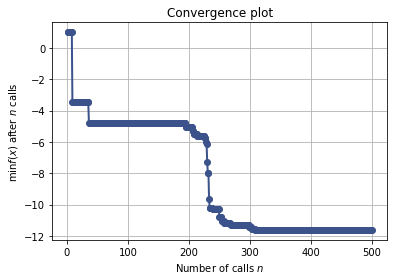

In [26]:
#convergence plot
from skopt.plots import plot_convergence
plot_convergence(res_gp)
print("Best parameters: \
\n jet_time_cuts = [{}] \
\n jet_tmf_cuts = [{}] \
\n jet_delta_r_cuts = [{}]\
 \n jet_chef_cuts = [{}]".format(res_gp.x[0],
                                 res_gp.x[1],
                                 res_gp.x[2],
                                 res_gp.x[3]))

QCD_HT_all, background 612464
QCD_HT_all, background bin 0  35.83856607177131
QCD_HT_all, background bin 1  0.04014885939704982
QCD_HT_all, background bin 2  0
unique nTags element:  [0 1]
WLNu, background 388950
WLNu, background bin 0  91.60565102752298
WLNu, background bin 1  0.14767343131825328
WLNu, background bin 2  0
unique nTags element:  [0 1]
ZNunu_HT_all, background 11051864
ZNunu_HT_all, background bin 0  30.535898647955992
ZNunu_HT_all, background bin 1  0.026089400286348763
ZNunu_HT_all, background bin 2  8.915451623181525e-06
unique nTags element:  [0 1 2]
TT_Lep, background 864155
TT_Lep, background bin 0  13.369687883853658
TT_Lep, background bin 1  0.03406901191920042
TT_Lep, background bin 2  8.862075719662244e-05
unique nTags element:  [0 1 2]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1959
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.008391973744437564
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.006606447415833827
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.00090

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: WLNu, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: TT_Lep, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure alre

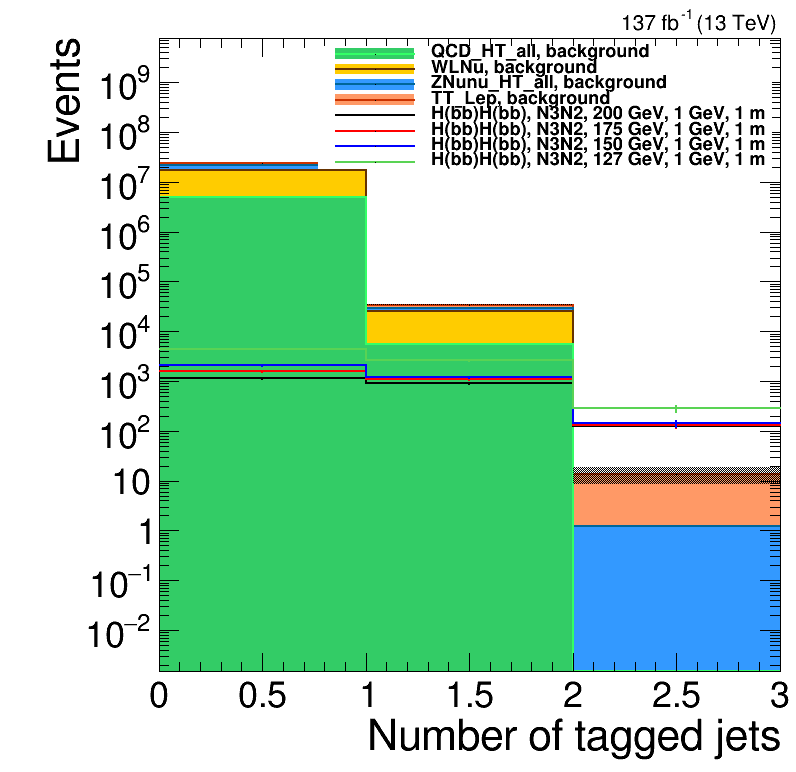

In [6]:
# plot the optimized situation
plotting = True

#signal>5
# time_cuts = [3] 
time_cuts = [0.29612602020051926] 
tmf_et_cuts = [0.12643216674114655] 
delta_r_cuts = [0.03974751272644846]
chef_cuts = [0.08572597974855801]

# time_cuts = [0.08676443430239597] 
# tmf_et_cuts = [0.16335152541277656] 
# delta_r_cuts = [0.06402562462487048]
# chef_cuts = [0.061590940809278155]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.78,0.97,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background', 'WLNu, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#                     keys = ['All, background']
#                     keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m', 'H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m', 'H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m', 'H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*100)
                    print('max_value',max_value)
                    stack.SetMinimum(10e-3)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
#                     c.SaveAs(out_dir+'nTags_4sig.png')


QCD_HT_all, background 612464
QCD_HT_all, background bin 0  35.83856607177131
QCD_HT_all, background bin 1  0.04014885939704982
QCD_HT_all, background bin 2  0
unique nTags element:  [0 1]
WLNu, background 388950
WLNu, background bin 0  91.60565102752298
WLNu, background bin 1  0.14767343131825328
WLNu, background bin 2  0
unique nTags element:  [0 1]
ZNunu_HT_all, background 11051864
ZNunu_HT_all, background bin 0  30.535898647955992
ZNunu_HT_all, background bin 1  0.026089400286348763
ZNunu_HT_all, background bin 2  8.915451623181525e-06
unique nTags element:  [0 1 2]
TT_Lep, background 864155
TT_Lep, background bin 0  13.369687883853658
TT_Lep, background bin 1  0.03406901191920042
TT_Lep, background bin 2  8.862075719662244e-05
unique nTags element:  [0 1 2]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1959
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.008391973744437564
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.006606447415833827
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.00090

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: WLNu, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: TT_Lep, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms

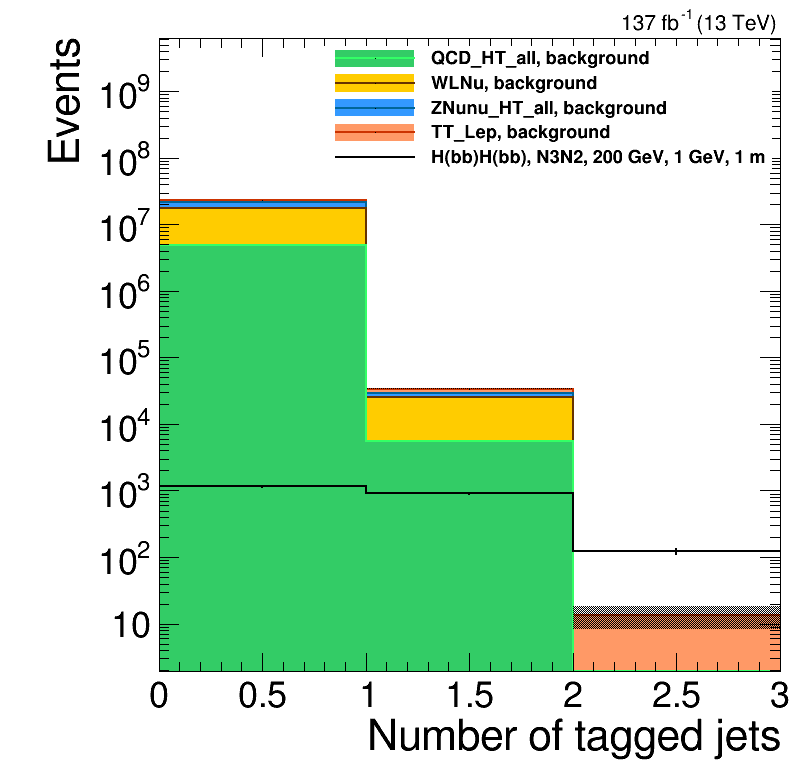

In [88]:
# plot the optimized situation
plotting = True

#signal>5
time_cuts = [0.29612602020051926] 
tmf_et_cuts = [0.12643216674114655] 
delta_r_cuts = [0.03974751272644846]
chef_cuts = [0.08572597974855801]

# time_cuts = [0.08676443430239597] 
# tmf_et_cuts = [0.16335152541277656] 
# delta_r_cuts = [0.06402562462487048]
# chef_cuts = [0.061590940809278155]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.78,0.97,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background', 'WLNu, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#                     keys = ['All, background']
#                     keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*100)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
                    c.SaveAs(out_dir+'nTags_200.png')


QCD_HT_all, background 612464
QCD_HT_all, background bin 0  35.83856607177131
QCD_HT_all, background bin 1  0.04014885939704982
QCD_HT_all, background bin 2  0
unique nTags element:  [0 1]
WLNu, background 388950
WLNu, background bin 0  91.60565102752298
WLNu, background bin 1  0.14767343131825328
WLNu, background bin 2  0
unique nTags element:  [0 1]
ZNunu_HT_all, background 11051864
ZNunu_HT_all, background bin 0  30.535898647955992
ZNunu_HT_all, background bin 1  0.026089400286348763
ZNunu_HT_all, background bin 2  8.915451623181525e-06
unique nTags element:  [0 1 2]
TT_Lep, background 864155
TT_Lep, background bin 0  13.369687883853658
TT_Lep, background bin 1  0.03406901191920042
TT_Lep, background bin 2  8.862075719662244e-05
unique nTags element:  [0 1 2]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1959
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.008391973744437564
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.006606447415833827
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.00090

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: WLNu, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: TT_Lep, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms

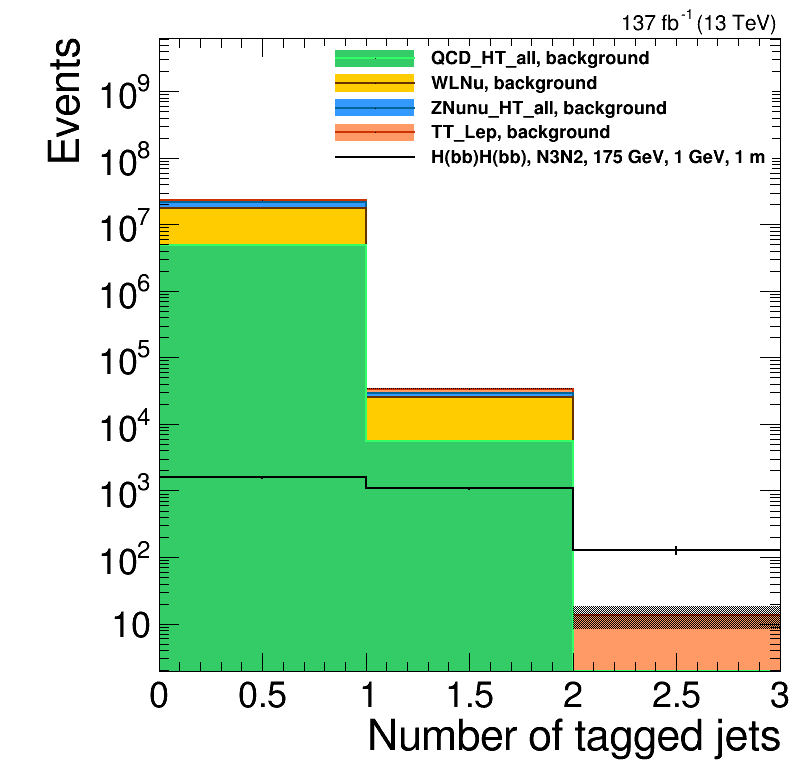

In [91]:
# plot the optimized situation
plotting = True

#signal>5
time_cuts = [0.29612602020051926] 
tmf_et_cuts = [0.12643216674114655] 
delta_r_cuts = [0.03974751272644846]
chef_cuts = [0.08572597974855801]

# time_cuts = [0.08676443430239597] 
# tmf_et_cuts = [0.16335152541277656] 
# delta_r_cuts = [0.06402562462487048]
# chef_cuts = [0.061590940809278155]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.78,0.97,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background', 'WLNu, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#                     keys = ['All, background']
#                     keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*100)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 175 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
                    c.SaveAs(out_dir+'nTags_175.png')


QCD_HT_all, background 612464
QCD_HT_all, background bin 0  35.83856607177131
QCD_HT_all, background bin 1  0.04014885939704982
QCD_HT_all, background bin 2  0
unique nTags element:  [0 1]
WLNu, background 388950
WLNu, background bin 0  91.60565102752298
WLNu, background bin 1  0.14767343131825328
WLNu, background bin 2  0
unique nTags element:  [0 1]
ZNunu_HT_all, background 11051864
ZNunu_HT_all, background bin 0  30.535898647955992
ZNunu_HT_all, background bin 1  0.026089400286348763
ZNunu_HT_all, background bin 2  8.915451623181525e-06
unique nTags element:  [0 1 2]
TT_Lep, background 864155
TT_Lep, background bin 0  13.369687883853658
TT_Lep, background bin 1  0.03406901191920042
TT_Lep, background bin 2  8.862075719662244e-05
unique nTags element:  [0 1 2]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1959
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.008391973744437564
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.006606447415833827
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.00090

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: WLNu, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: TT_Lep, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms

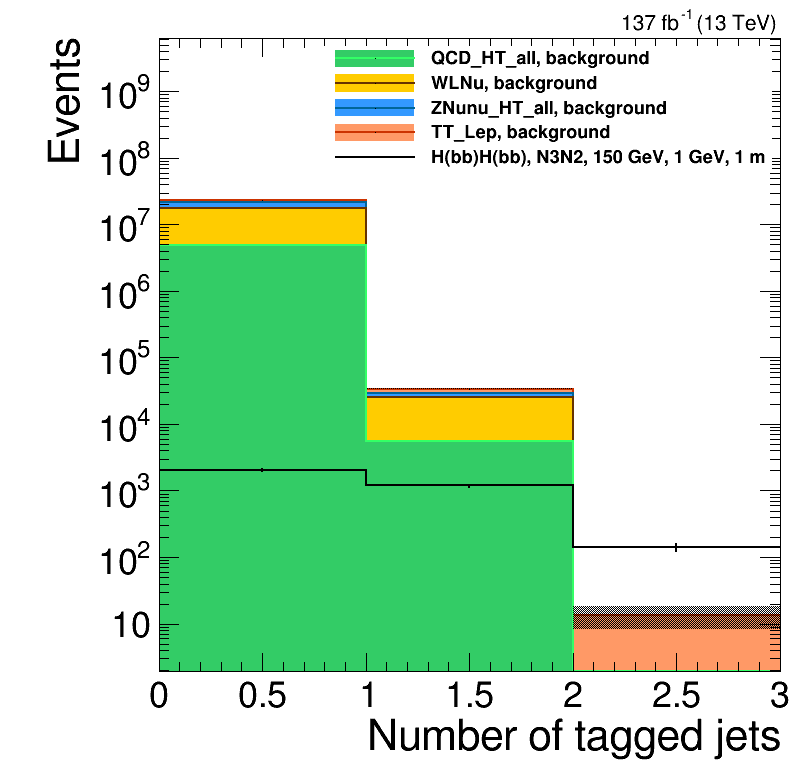

In [90]:
# plot the optimized situation
plotting = True

#signal>5
time_cuts = [0.29612602020051926] 
tmf_et_cuts = [0.12643216674114655] 
delta_r_cuts = [0.03974751272644846]
chef_cuts = [0.08572597974855801]

# time_cuts = [0.08676443430239597] 
# tmf_et_cuts = [0.16335152541277656] 
# delta_r_cuts = [0.06402562462487048]
# chef_cuts = [0.061590940809278155]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.78,0.97,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background', 'WLNu, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#                     keys = ['All, background']
#                     keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*100)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 150 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
                    c.SaveAs(out_dir+'nTags_150.png')


QCD_HT_all, background 612464
QCD_HT_all, background bin 0  35.83856607177131
QCD_HT_all, background bin 1  0.04014885939704982
QCD_HT_all, background bin 2  0
unique nTags element:  [0 1]
WLNu, background 388950
WLNu, background bin 0  91.60565102752298
WLNu, background bin 1  0.14767343131825328
WLNu, background bin 2  0
unique nTags element:  [0 1]
ZNunu_HT_all, background 11051864
ZNunu_HT_all, background bin 0  30.535898647955992
ZNunu_HT_all, background bin 1  0.026089400286348763
ZNunu_HT_all, background bin 2  8.915451623181525e-06
unique nTags element:  [0 1 2]
TT_Lep, background 864155
TT_Lep, background bin 0  13.369687883853658
TT_Lep, background bin 1  0.03406901191920042
TT_Lep, background bin 2  8.862075719662244e-05
unique nTags element:  [0 1 2]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1959
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.008391973744437564
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.006606447415833827
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.00090

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: WLNu, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: ZNunu_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: TT_Lep, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms

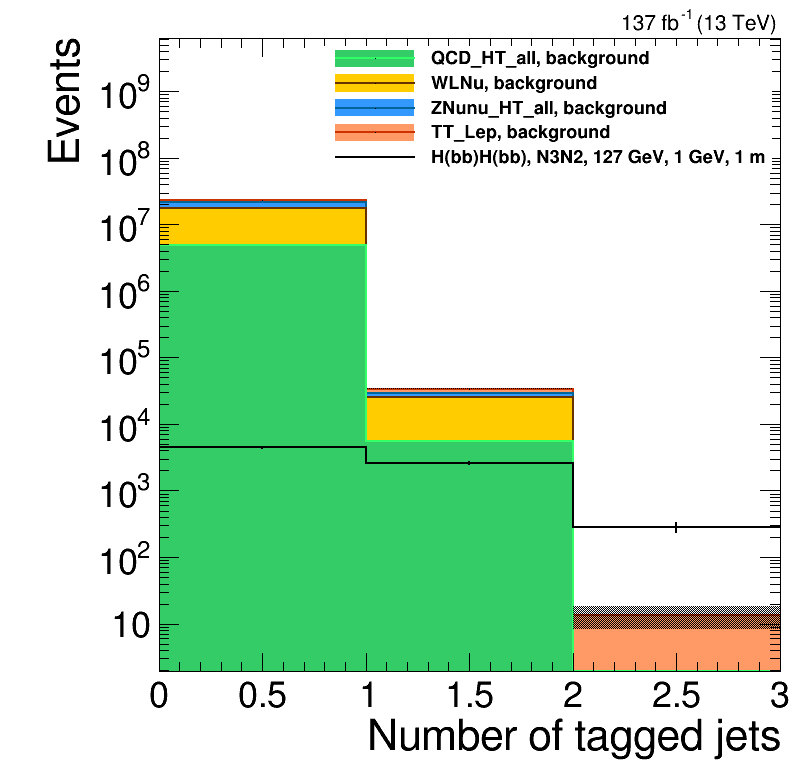

In [89]:
# plot the optimized situation
plotting = True

#signal>5
time_cuts = [0.29612602020051926] 
tmf_et_cuts = [0.12643216674114655] 
delta_r_cuts = [0.03974751272644846]
chef_cuts = [0.08572597974855801]

# time_cuts = [0.08676443430239597] 
# tmf_et_cuts = [0.16335152541277656] 
# delta_r_cuts = [0.06402562462487048]
# chef_cuts = [0.061590940809278155]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.78,0.97,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background', 'WLNu, background', 'ZNunu_HT_all, background', 'TT_Lep, background']
#                     keys = ['All, background']
#                     keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*100)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 127 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()
                    c.SaveAs(out_dir+'nTags_127.png')


All, background 12917433
All, background bin 0  171.3498036303281
All, background bin 1  0.24798070292085228
All, background bin 2  9.753620881980396e-05
unique nTags element:  [0 1 2]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1959
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.008391973744437564
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.006606447415833827
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.0009008791930682492
unique nTags element:  [0 1 2]
PLOTTING
All, background 15 9.753620881980396e-05
All, background bkg weight [8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05
 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05]
All, background bkg bins 0.0
max_value 23474923.094175123
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m factor 0.0
cnt H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 111 0.0009008791930682492
total 23474923.094175123 63015.545794327336
0 1149.7004029879463 23474923.094175123
1 905.0832959692343 33973.35630015683
2 123.42044945035013 13.3

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: All, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


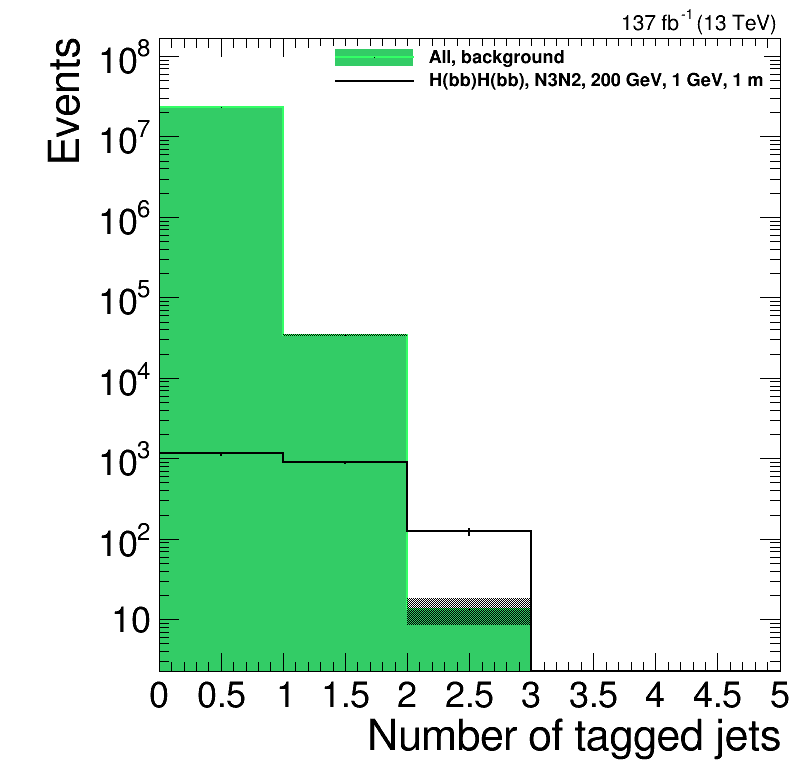

In [29]:
# plot the optimized situation
plotting = True

#signal>5
time_cuts = [0.29612602020051926] 
tmf_et_cuts = [0.12643216674114655] 
delta_r_cuts = [0.03974751272644846]
chef_cuts = [0.08572597974855801]

# time_cuts = [0.08676443430239597] 
# tmf_et_cuts = [0.16335152541277656] 
# delta_r_cuts = [0.06402562462487048]
# chef_cuts = [0.061590940809278155]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
#                     for i,ele in enumerate(nTags[k]):
# #                         print('nTags element: ', i, ' th, ', ele)
#                         if ele > 2:
#                             nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.88,0.96,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['All, background']
#                     keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
#                             cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[5,0,5],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*3)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
#                         cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[5,0,5],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(5):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()


QCD_HT_all, background 23087
QCD_HT_all, background bin 0  3.328964246020405
QCD_HT_all, background bin 1  0.11363057471498905
QCD_HT_all, background bin 2  0.0018828003303497098
unique nTags element:  [0 1 2]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1823
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.006395430667907931
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.007085293113050284
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.001314796660153661
unique nTags element:  [0 1 2 3]
PLOTTING
QCD_HT_all, background 16 0.0018828003303497098
QCD_HT_all, background bkg weight [8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05
 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05]
QCD_HT_all, background bkg bins 0.0
max_value 456068.1017047955
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m factor 0.0
cnt H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 162 0.001314796660153661
total 456068.1017047955 7281.247945054384
0 876.1740015033865 456068.1017047955
1 970.6851564878889 15

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Repl

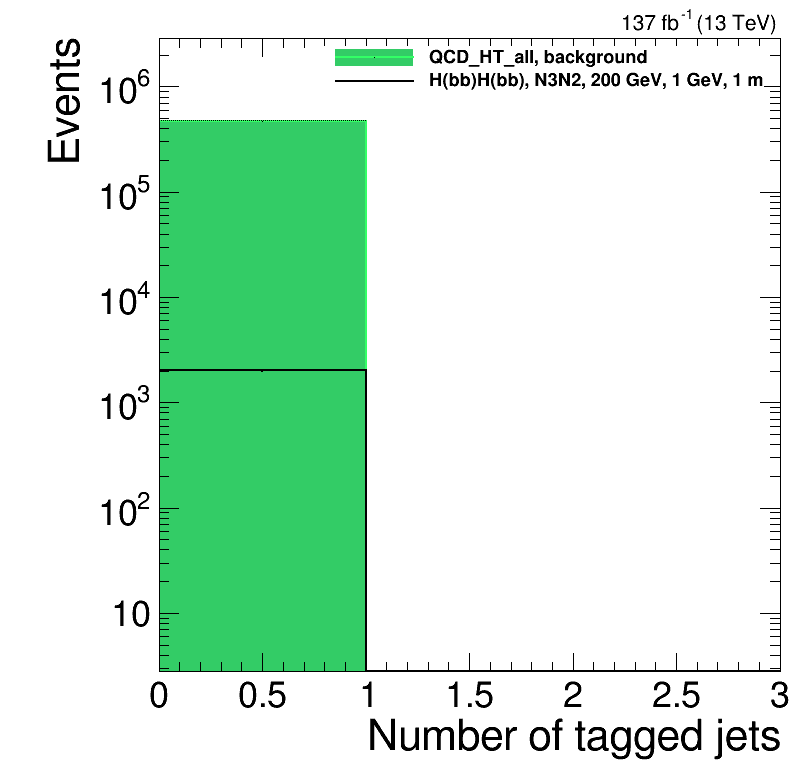

In [241]:
# loop over all the cuts and save the efficiency for each cut and a list for cuts
plotting = True

#signal>5
# time_cuts = [7.129553205232273] 
# tmf_et_cuts = [0.6427063892802387] 
# delta_r_cuts = [1.0363272825402927]
# chef_cuts = [1.0787254652321598]

#test
time_cuts = [0] 
tmf_et_cuts = [0.2] 
delta_r_cuts = [0.1]
chef_cuts = [0.75]

cut_variable = 1
# 1 = time,   2= tmf, 3=deltaR, 4 = chef 
if cut_variable == 1:#time
    time_cuts = list(np.array(range(20))/2.0)
    time_cuts.sort() 
elif cut_variable == 2:#gamma
    tmf_et_cuts = list(np.array(range(10))/10.0)
elif cut_variable == 3:#deltaR
    delta_r_cuts = list(np.array(range(10))/10.0)+ [0.22,0.24]
    delta_r_cuts.sort()
else:
    chef_cuts = list(np.array(range(10))/10.0)
    chef_cuts.sort()

validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.88,0.96,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*3)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()


137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


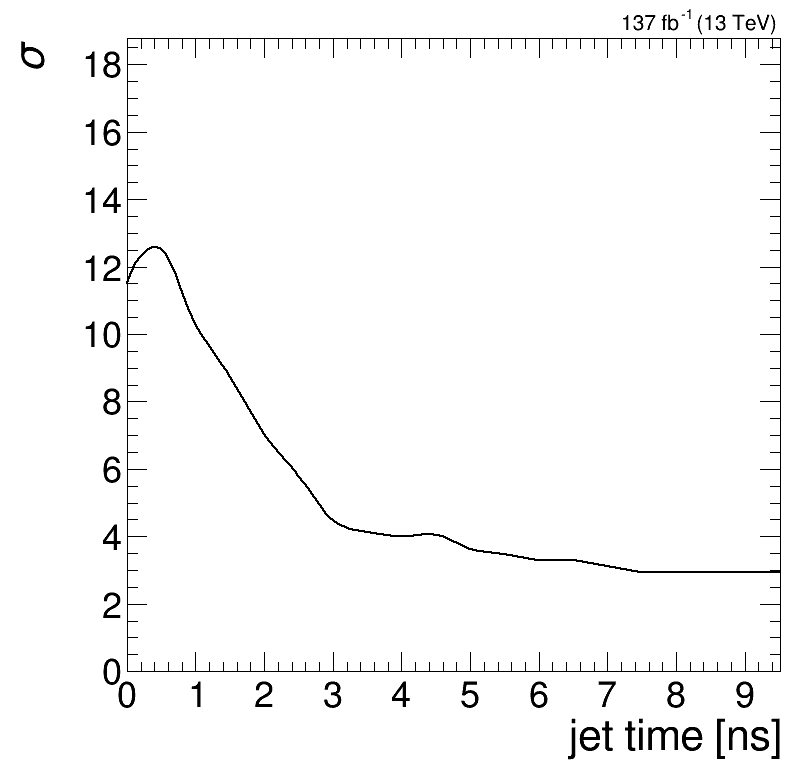

In [242]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

gr = {}

# cut_variable = 1
# # 1 = time,   2= tmf, 3=deltaR, 4 = chef 
# if cut_variable == 1:#time
#     time_cuts = list(np.array(range(10))/2.0)
#     time_cuts.sort() 
# elif cut_variable == 2:#gamma
#     tmf_et_cuts = list(np.array(range(16))/10.0)
# elif cut_variable == 3:#deltaR
#     delta_r_cuts = list(np.array(range(16))/10.0)+ [0.22,0.24]
#     delta_r_cuts.sort()
# else:
#     chef_cuts = list(np.array(range(16))/10.0)
#     chef_cuts.sort()


time_cuts = np.array(time_cuts)
tmf_et_cuts = np.array(tmf_et_cuts)
delta_r_cuts = np.array(delta_r_cuts)
chef_cuts = np.array(chef_cuts)
significance = np.array(significance)

# 1 = time,   2= tmf, 3=deltaR, 4 = chef 
 

if cut_variable == 1:
    gr['good'] = create_TGraph(time_cuts[validity],significance[validity],axis_title = ['jet time [ns]','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(time_cuts,significance,axis_title = ['jet time [ns]','\sigma'])
    x_max = np.max(time_cuts)
elif cut_variable == 2:
    gr['good'] = create_TGraph(tmf_et_cuts[validity],significance[validity],axis_title = ['TMF_{ET MAX}','\sigma'])
    gr['all'] = create_TGraph(tmf_et_cuts,significance,axis_title = ['TMF_{ET MAX}','\sigma'])
    x_max = np.max(tmf_et_cuts)
elif cut_variable == 3:
    gr['good'] = create_TGraph(delta_r_cuts[validity],significance[validity],axis_title = ['#Delta R_{min}','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(delta_r_cuts,significance,axis_title = ['#Delta R_{min}','\sigma'])
    x_max = np.max(delta_r_cuts)    
else:
    gr['good'] = create_TGraph(chef_cuts[validity],significance[validity],axis_title = ['CHEF','\sigma'])
    bad = np.logical_not(validity)
    gr['all'] = create_TGraph(chef_cuts,significance,axis_title = ['#sigma_{ET}','\sigma'])
    x_max = np.max(chef_cuts)
    

    
gr['all'].SetLineWidth(2)
gr['all'].SetLineColor(1)
gr['all'].GetXaxis().SetRangeUser(0,x_max)
gr['all'].GetYaxis().SetRangeUser(0,1.5*np.max(significance))
# leg.AddEntry(gr['all'],"Has > 5 signal events")
gr['all'].Draw('ac')

    
 
leg.Draw()
    
 

CMS_lumi.lumi_13TeV = "137 fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)


 
c.Draw()


QCD_HT_all, background 23087
QCD_HT_all, background bin 0  3.438593769763429
QCD_HT_all, background bin 1  0.005883851302314724
QCD_HT_all, background bin 2  0
QCD_HT_all, background bin >0  806.0876284171172
unique nTags element:  [0 1]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1823
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.007474862493836554
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.006557751243235543
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.0007629067040397786
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin >0  1002.9301387767191
unique nTags element:  [0 1 2]
PLOTTING
QCD_HT_all, background 0 0.0
QCD_HT_all, background bkg weight [8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05
 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05]
QCD_HT_all, background bkg bins 471087.34645757213
max_value 471087.34645757213
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m factor 0.0
cnt H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 94 0.0007629067040397786
bin 1 471087.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


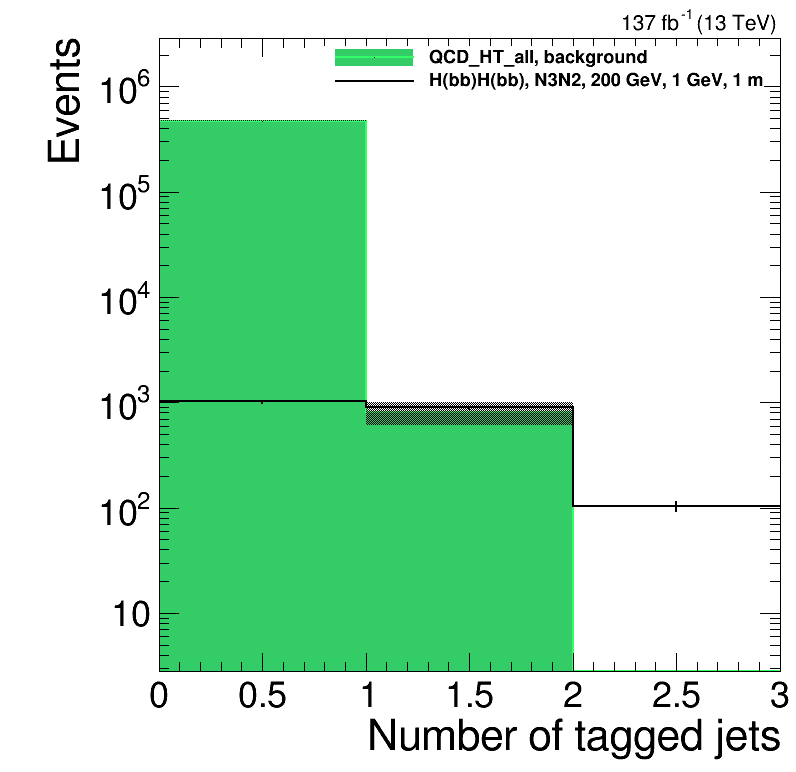

In [18]:
# validation of cut base chain
plotting = True


#base
# time_cuts = [-10] 
# tmf_et_cuts = [0] 
delta_r_cuts = [0]
# chef_cuts = [1.]
tmf_et_cuts = [0.16335152541277656] 
chef_cuts = [0.061590940809278155]
time_cuts = [0.08676443430239597] 

case=3
#signal>5
if case==1:
    time_cuts = [0.08676443430239597] 
# elif case==2:
#     tmf_et_cuts = [0.16335152541277656] 
elif case==3:
    delta_r_cuts = [0.06402562462487048]
# elif case==4:
#     chef_cuts = [0.061590940809278155]


 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin >0 ', 137000*sum(trg_jet_w[k][nTags[k]>=1]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.88,0.96,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(1))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*3)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("bin 1",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()


In [ ]:
# one leading cut, nTags>=1
#time
#0 tagged jets in both sig and bkg
#tmf
#sig 1759.019378652738
#bkg 116592.98850741106
#dr
#0 tagged jets in both sig and bkg
#chef
#0 tagged jets in both sig and bkg
  

In [ ]:
# 2nd leading cut, nTags>=1
#time
#bkg 46382.35272752536
#sig 1534.4163985719206
#dr
# bkg 46389.06775966916
# sig 1489.9405609321548
#chef
# bkg 4611.738703119954
# sig 1273.1208524382964

In [ ]:
# 3rd leading cut, nTags>=1
#time
#bkg 1282.1547083531186
#sig 1111.8959409941453
#dr 
#bkg 2630.796142705549
#sig 1140.8052354599931

In [ ]:
#CUT BASED SUMMARY
#Baseline: met>150, njets>=2, jetpt>30
#bkg 139426147.09670144 --> 1.4e+08
#sig 2898.712718171737
#Trigger
#bkg 471893.4340860069 --> 4.7e+05
#sig 2026.986300432327 
#nTags>=1
#tmf
#bkg 116592.98850741106 --> 1.2e+05
#sig 1759.019378652738
#chef
# bkg 4611.738703119954
# sig 1273.1208524382964
#time
#bkg 1282.1547083531186
#sig 1111.8959409941453
#dr
#bkg 806.0876284171172
#sig 1002.9301387767191

In [19]:
print(1017.7091028956311*137000)
print(0.021158486993954284*137000) 
print(3.4444776210657437*137000)
print(0.014795520441111876*137000)

139426147.09670144
2898.712718171737
471893.4340860069
2026.986300432327


In [9]:
#2-variable

In [13]:
## optimization
i=0
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

sig_bins = [0,1,2]


space2 = [
          Real(0, 10, name='jet_time'),
          Real(0.0,1.5, name='jet_tmf')
#           Real(0.0,1.5,name='jetMinDeltaRPVTracks'),
#           Real(0.0,1.5,name = 'jet_chef')
          ]

def figure_of_merit2(time_cut = -50, tmf_et_cut = 50):
# def figure_of_merit(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50, chef_cut = -50):
    nTags = {}
    sig_count = [] 
    bkg_count = np.zeros((3,))
    
    for k,T in trg_jet_tmf.items():
#         start_t = time.time()
        nTags[k] = []
        tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_t[k]>time_cut) 
#         tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
#         tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
#         tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)
#         nTags[k] = [len(x) for x in pf_jet_pt[k][tagged_jet]] #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.array(nTags[k])
        print(k, tagged_jet[:10])
        print(k, trg_jet_pt[k][:10])
        print(k, trg_jet_pt[k][tagged_jet][:10])
        print(k, 'count', trg_jet_pt[k][tagged_jet].count()[:10])
        nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.sum(w[tagged_jet])
#         nJets[k] = np.sum(w[w<8000000])
        print(k, 'nTags', nTags[k][:10])
        print(k, 'unique', np.unique(nTags[k]))
        nTags[k] = np.array(nTags[k])
            
        occurCount = []
        for i in sig_bins:
            print('sig bin', i)
            if i == 2:
#               #overflow bin
                tag_cut = nTags[k] >= i 
            else:
                tag_cut = nTags[k] == i
            w_sum = sum(trg_jet_w[k][tag_cut])
#             w_sum = sum(weight[k][tag_cut])
            print('sig bin', i, 'w_sum', w_sum)
            
            occurCount.append(w_sum)
        print(occurCount)
        occurCount = np.array(occurCount)
        
        if 'background' not in k :
            sig_count = list(occurCount[:2])
            sig_count.append(sum(occurCount[2:]))
            sig_count = np.array(sig_count)
        elif 'background' in k:
            bkg_count = bkg_count + occurCount

#     cond = np.logical_not(np.logical_or(sig_count < 5,bkg_count < 5))
    sig_count = sig_count*137000
    bkg_count = bkg_count*137000
    print("sig count", sig_count)
    print("bkg count", bkg_count)
    cond = sig_count > 5
    if not np.count_nonzero(cond) == len(sig_bins):
        return 1

#     return -1.0*np.sum(2*((s+b)*math.log(s/b+1)-s))**0.5

    # loss function: - significance  = - (sqrt(S/(S+B)))
    return -1.0 * np.sum(sig_count**2/(sig_count+bkg_count))**0.5

@use_named_args(space2)
def objective2(**X):
    print("New configuration: {}".format(X))
#     begt = time.time()
    fom = figure_of_merit2(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'])
#     fom = figure_of_merit(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'],chef_cut = X['jet_chef'])
#     fom = train(model, learning_rate=X['learning_rate'])
    return fom


# res_gp = gp_minimize(objective, space, n_calls=5, n_random_starts=1, random_state=123, verbose=True)
res_gp2 = gp_minimize(objective2, space2, n_calls=500, n_random_starts=100, random_state=123, verbose=True)


Iteration No: 1 started. Evaluating function at random point.
New configuration: {'jet_time': 7.129553205232273, 'jet_tmf': 0.6427063892802387}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.444314634463808
sig bin 1
sig bin 1 w_sum 0.00016298660193569958
sig bin 2
sig bin 2 w_sum 0
[3.444314634463808, 0.00016298660193569958, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[68.67287 52.03112] [295.94345] [199.29875] ... [71.74189] [391.05832] [338.78073]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[] [] [] ... [] [] []]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [0 0 0 0 0 0 0 0 0 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m nTags [0 0 0 0 0 0 0 0 0 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m unique [0 1]
sig bin 0
sig bin 0 w_sum 0.014738708239747211
sig bin 1
sig bin 1 w_sum 5.681220136466436e-05
sig bin 2
sig bin 2 w_sum 0
[0.014738708239747211, 5.681220136466436e-05, 0]
sig count [2019.20302885    7.78327159    0.        ]
bkg count [471330.5296042     562.90448181      0.        ]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0688
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 4 started. Evaluating function at random point.
New configuration: {'jet_time': 4.10924372709019, 'jet_

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 3.3894
Function value obtained: 1.0000
Current minimum: -9.2886
Iteration No: 102 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.7080084237669138, 'jet_tmf': 0.029381463330898923}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.444473344682592
sig bin 1
sig bin 1 w_sum 4.27638315159129e-06
sig bin 2
sig bin 2 w_sum 0
[3.444473344682592, 4.276383151

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 2.6418
Function value obtained: -11.0301
Current minimum: -11.0301
Iteration No: 103 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.6812679614200716, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.5682
Function value obtained: 1.0000
Current minimum: -11.0301
Iteration No: 104 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0017830590376466395, 'jet_tmf': 0.0933030454510814}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.23550467390578
sig bin 1
sig bin 1 w_sum 0.20270980338318623
sig bin 2
sig bin 2 w_sum 0.006263143776777724
[3.23550

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.0832
Function value obtained: -13.2224
Current minimum: -13.2224
Iteration No: 105 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.04609290657766275, 'jet_tmf': 0.013178072529716704}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4268760469531117
sig bin 1
sig bin 1 w_sum 0.017228907939170313
sig bin 2
sig bin 2 w_sum 0.00037266617346176645
[3.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.0706
Function value obtained: -16.0813
Current minimum: -16.0813
Iteration No: 106 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.2484
Function value obtained: 1.0000
Current minimum: -16.0813
Iteration No: 107 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.03958501079193489, 'jet_tmf': 0.019893928446279192}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4182784437480223
sig bin 1
sig bin 1 w_sum 0.025647507321991725
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.0371
Function value obtained: -17.2085
Current minimum: -17.2085
Iteration No: 108 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.04699193291129445, 'jet_tmf': 0.007945666267804354}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4313822328895185
sig bin 1
sig bin 1 w_sum 0.012901725825031463
sig bin 2
sig bin 2 w_sum 0.00019366235119377961
[3.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.3411
Function value obtained: -12.9323
Current minimum: -17.2085
Iteration No: 109 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.031176253677074335, 'jet_tmf': 0.022916342210182412}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4106186358303603
sig bin 1
sig bin 1 w_sum 0.03275251188824768
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.1547
Function value obtained: -16.6268
Current minimum: -17.2085
Iteration No: 110 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.03607459291022797, 'jet_tmf': 0.01663053032154455}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4228103033383377
sig bin 1
sig bin 1 w_sum 0.02111564773167629
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.0802
Function value obtained: -16.8789
Current minimum: -17.2085
Iteration No: 111 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.07503848271693371, 'jet_tmf': 0.008587305266807234}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4318377510553546
sig bin 1
sig bin 1 w_sum 0.012446207659195352
sig bin 2
sig bin 2 w_sum 0.00019366235119377961
[3.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.0761
Function value obtained: -13.5389
Current minimum: -17.2085
Iteration No: 112 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.18677362714782378, 'jet_tmf': 0.0017602849680288806}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4373948457159713
sig bin 1
sig bin 1 w_sum 0.006899495144352841
sig bin 2
sig bin 2 w_sum 0.00018328020541957812
[3

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.2977
Function value obtained: -9.1935
Current minimum: -17.2085
Iteration No: 113 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0045749891246393845, 'jet_tmf': 0.00690565212272626}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4306956392238135
sig bin 1
sig bin 1 w_sum 0.013588319490736467
sig bin 2
sig bin 2 w_sum 0.00019366235119377961
[

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.4091
Function value obtained: -11.9324
Current minimum: -17.2085
Iteration No: 114 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.024010986549589667, 'jet_tmf': 0.005807229295394347}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4314398285432617
sig bin 1
sig bin 1 w_sum 0.01284413017128827
sig bin 2
sig bin 2 w_sum 0.00019366235119377961
[

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.1187
Function value obtained: -10.9281
Current minimum: -17.2085
Iteration No: 115 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.015093142332418544, 'jet_tmf': 0.009777457917820202}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4287999550288077
sig bin 1
sig bin 1 w_sum 0.01548400368574221
sig bin 2
sig bin 2 w_sum 0.00019366235119377961
[

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.5017
Function value obtained: -14.4738
Current minimum: -17.2085
Iteration No: 116 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.4679297098193114, 'jet_tmf': 0.003776809606460597}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4410940836351074
sig bin 1
sig bin 1 w_sum 0.0033792610474847606
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.44

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.4547
Function value obtained: -9.1031
Current minimum: -17.2085
Iteration No: 117 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.01506999292704703, 'jet_tmf': 0.004137837160891001}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.430985453404901
sig bin 1
sig bin 1 w_sum 0.013298505309649045
sig bin 2
sig bin 2 w_sum 0.00019366235119377961
[3.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.4739
Function value obtained: -9.5234
Current minimum: -17.2085
Iteration No: 118 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.005072000588844939, 'jet_tmf': 0.0009392070279226619}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.430816831728407
sig bin 1
sig bin 1 w_sum 0.01346712698614283
sig bin 2
sig bin 2 w_sum 0.00019366235119377961
[3.4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.6039
Function value obtained: -8.3054
Current minimum: -17.2085
Iteration No: 119 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5964315311082381, 'jet_tmf': 5.765622031472797e-07}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4423696493468015
sig bin 1
sig bin 1 w_sum 0.0021036953357906896
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.44

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.2893
Function value obtained: -8.8720
Current minimum: -17.2085
Iteration No: 120 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.996801685448911, 'jet_tmf': 0.03905725555528912}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.5880
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 121 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.2321
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 122 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.4791
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 123 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.6959
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 124 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.4161
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 125 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.7456
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 126 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.9942
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 127 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.8659
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 128 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.6239
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 129 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.9381
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 130 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.7324
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 131 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7207845852356055, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 3.1139
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 132 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 3.2531
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 133 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [F

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 2.9154
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 134 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
si

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 3.2481
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 135 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 3.0097
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 136 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8914055061824162, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 3.2664
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 137 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
si

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 4.0811
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 138 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
s

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 3.7109
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 139 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 3.6286
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 140 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.9722640672041195, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 3.8301
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 141 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
si

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 4.2008
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 142 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
s

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 3.9443
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 143 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 4.1858
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 144 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.0576951883532981, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.5046
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 145 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
si

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 3.9549
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 146 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
s

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 4.0073
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 147 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 4.2546
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 148 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.128945074741167, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[F

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 4.5778
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 149 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
si

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.7278
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 150 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin 1 w_sum 1.010200461822933
s

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.6183
Function value obtained: -3.5210
Current minimum: -17.2085
Iteration No: 151 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.1004656767139356, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 3.1912207424429653
sig bin 1
sig bin 1 w_sum 0.24511553112824913
sig bin 2
sig bin 2 w_sum 0.008141347494529327
[3.1912207424429653, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 3.9645
Function value obtained: -3.3667
Current minimum: -17.2085
Iteration No: 152 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 4.3658
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 153 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.1932593846821549, 'jet_tmf': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.241376732158642
sig bin 1
sig bin 1 w_sum 0.1973982881218035
sig bin 2
sig bin 2 w_sum 0.005702600785298273
[3.241376732158642, 0.1973

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 4.2755
Function value obtained: -3.3777
Current minimum: -17.2085
Iteration No: 154 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.1783072630477616, 'jet_tmf': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 4.7904
Function value obtained: 1.0000
Current minimum: -17.2085
Iteration No: 155 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.572991855858397, 'jet_tmf': 0.017172508385939558}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4411044657808816
sig bin 1
sig bin 1 w_sum 0.003368878901710559
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.441104

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 4.4890
Function value obtained: -15.4509
Current minimum: -17.2085
Iteration No: 156 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.017328353311952958}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.419531470503898
sig bin 1
sig bin 1 w_sum 0.024394480566115817
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.419531470503898,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 4.6134
Function value obtained: -16.7814
Current minimum: -17.2085
Iteration No: 157 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.017280701405935284}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.419531470503898
sig bin 1
sig bin 1 w_sum 0.024394480566115817
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.419531470503898,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 5.0690
Function value obtained: -16.7814
Current minimum: -17.2085
Iteration No: 158 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.017237311667382862}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.419531470503898
sig bin 1
sig bin 1 w_sum 0.024394480566115817
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.419531470503898,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 5.0005
Function value obtained: -16.7422
Current minimum: -17.2085
Iteration No: 159 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.017192857240343397}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.419531470503898
sig bin 1
sig bin 1 w_sum 0.024394480566115817
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.419531470503898,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 4.2761
Function value obtained: -16.7292
Current minimum: -17.2085
Iteration No: 160 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6048067566040495, 'jet_tmf': 0.016900983992696673}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4415439667263854
sig bin 1
sig bin 1 w_sum 0.0029293779562067357
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.44

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 4.5292
Function value obtained: -15.0480
Current minimum: -17.2085
Iteration No: 161 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01923847727142052}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4171672233296704
sig bin 1
sig bin 1 w_sum 0.026758727740343602
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4171672233296704

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 4.3586
Function value obtained: -17.1846
Current minimum: -17.2085
Iteration No: 162 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019622091747204473}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4162544123337284
sig bin 1
sig bin 1 w_sum 0.027671538736285584
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.416254412333728

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 4.5880
Function value obtained: -17.2094
Current minimum: -17.2094
Iteration No: 163 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01667256989621324}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.420623285322108
sig bin 1
sig bin 1 w_sum 0.02330266574790585
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.420623285322108, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 4.5108
Function value obtained: -16.7163
Current minimum: -17.2094
Iteration No: 164 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.020647746055850073}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.414647238343605
sig bin 1
sig bin 1 w_sum 0.02927871272640914
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.414647238343605, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.5285
Function value obtained: -17.2567
Current minimum: -17.2567
Iteration No: 165 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02091202066019}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.414289230699069
sig bin 1
sig bin 1 w_sum 0.029636720370945113
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.414289230699069, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 4.4971
Function value obtained: -17.2447
Current minimum: -17.2567
Iteration No: 166 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.021138755133377513}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4137301509645113
sig bin 1
sig bin 1 w_sum 0.030195800105502713
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.413730150964511

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 4.7639
Function value obtained: -17.2700
Current minimum: -17.2700
Iteration No: 167 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.021378365542146685}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.412328900701141
sig bin 1
sig bin 1 w_sum 0.03159705036887317
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.412328900701141, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 4.6051
Function value obtained: -17.1422
Current minimum: -17.2700
Iteration No: 168 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.021432411659014886}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.411595093527467
sig bin 1
sig bin 1 w_sum 0.032330857542547164
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.411595093527467,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 4.7094
Function value obtained: -17.0441
Current minimum: -17.2700
Iteration No: 169 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.018743234000986563}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.417606724275174
sig bin 1
sig bin 1 w_sum 0.02631922679483978
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417606724275174, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 4.5919
Function value obtained: -17.0577
Current minimum: -17.2700
Iteration No: 170 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.021956122220826123}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.411115893378337
sig bin 1
sig bin 1 w_sum 0.032810057691676775
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.411115893378337,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 4.8757
Function value obtained: -17.2682
Current minimum: -17.2700
Iteration No: 171 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.022217803486474584}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.410006286675525
sig bin 1
sig bin 1 w_sum 0.03391966439448879
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.410006286675525, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 4.9677
Function value obtained: -17.2526
Current minimum: -17.2700
Iteration No: 172 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02244587437291211}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4090119823786154
sig bin 1
sig bin 1 w_sum 0.03491396869139862
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4090119823786154,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 4.7391
Function value obtained: -17.1830
Current minimum: -17.2700
Iteration No: 173 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019866101220381686}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4160754085114604
sig bin 1
sig bin 1 w_sum 0.02785054255855357
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4160754085114604

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 5.3283
Function value obtained: -17.1900
Current minimum: -17.2700
Iteration No: 174 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.022967766163875365}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.407198101223912
sig bin 1
sig bin 1 w_sum 0.03617304649469588
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.407198101223912, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 5.1495
Function value obtained: -16.4064
Current minimum: -17.2700
Iteration No: 175 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01905931486350039}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4171672233296704
sig bin 1
sig bin 1 w_sum 0.026758727740343602
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4171672233296704

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 4.6522
Function value obtained: -17.0800
Current minimum: -17.2700
Iteration No: 176 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019240269545690254}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4171672233296704
sig bin 1
sig bin 1 w_sum 0.026758727740343602
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417167223329670

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 5.0400
Function value obtained: -17.1846
Current minimum: -17.2700
Iteration No: 177 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01943196459614335}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4164334161559964
sig bin 1
sig bin 1 w_sum 0.027492534914017597
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4164334161559964

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 5.5398
Function value obtained: -17.1303
Current minimum: -17.2700
Iteration No: 178 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01968543367970447}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4162544123337284
sig bin 1
sig bin 1 w_sum 0.027671538736285584
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4162544123337284

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 5.2044
Function value obtained: -17.2094
Current minimum: -17.2700
Iteration No: 179 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02007879213297699}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4159124219095247
sig bin 1
sig bin 1 w_sum 0.02801352916048927
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4159124219095247,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 5.2754
Function value obtained: -17.2212
Current minimum: -17.2700
Iteration No: 180 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.022378574677729586}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4090119823786154
sig bin 1
sig bin 1 w_sum 0.03491396869139862
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4090119823786154

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 5.4775
Function value obtained: -17.1406
Current minimum: -17.2700
Iteration No: 181 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019905748833731977}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4159124219095247
sig bin 1
sig bin 1 w_sum 0.02801352916048927
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4159124219095247

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 5.4738
Function value obtained: -17.1774
Current minimum: -17.2700
Iteration No: 182 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.022632311012234375}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4090119823786154
sig bin 1
sig bin 1 w_sum 0.034359165339992614
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.409011982378615

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 5.8324
Function value obtained: -16.5847
Current minimum: -17.2700
Iteration No: 183 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019309170220751133}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4166124199782644
sig bin 1
sig bin 1 w_sum 0.02731353109174961
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4166124199782644

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 5.6644
Function value obtained: -17.1349
Current minimum: -17.2700
Iteration No: 184 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019400567542240812}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4164334161559964
sig bin 1
sig bin 1 w_sum 0.027492534914017597
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.416433416155996

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 5.5801
Function value obtained: -17.1303
Current minimum: -17.2700
Iteration No: 185 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019172991465691257}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4171672233296704
sig bin 1
sig bin 1 w_sum 0.026758727740343602
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417167223329670

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 5.8498
Function value obtained: -17.1722
Current minimum: -17.2700
Iteration No: 186 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.018819727264559688}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.417427720452906
sig bin 1
sig bin 1 w_sum 0.026498230617107765
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417427720452906,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 5.7086
Function value obtained: -17.0364
Current minimum: -17.2700
Iteration No: 187 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.018496484690756286}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4177961102432164
sig bin 1
sig bin 1 w_sum 0.02612984082679759
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4177961102432164

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 5.9669
Function value obtained: -16.9785
Current minimum: -17.2700
Iteration No: 188 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02229031798264225}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4097457895522894
sig bin 1
sig bin 1 w_sum 0.03418016151772463
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4097457895522894,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 6.1188
Function value obtained: -17.2172
Current minimum: -17.2700
Iteration No: 189 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.018706094833399488}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.417785728097442
sig bin 1
sig bin 1 w_sum 0.02614022297257179
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417785728097442, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 6.1125
Function value obtained: -17.0769
Current minimum: -17.2700
Iteration No: 190 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0229354024085274}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.40737710504618
sig bin 1
sig bin 1 w_sum 0.035994042672427895
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.40737710504618, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 6.0902
Function value obtained: -16.4301
Current minimum: -17.2700
Iteration No: 191 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.017581237784833083}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4190919695583943
sig bin 1
sig bin 1 w_sum 0.02483398151161964
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4190919695583943

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 6.0356
Function value obtained: -16.8378
Current minimum: -17.2700
Iteration No: 192 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01794208011458106}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.418550681708439
sig bin 1
sig bin 1 w_sum 0.025375269361575192
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.418550681708439, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 5.9945
Function value obtained: -16.8367
Current minimum: -17.2700
Iteration No: 193 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019119131171984827}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4171672233296704
sig bin 1
sig bin 1 w_sum 0.026758727740343602
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417167223329670

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 6.8106
Function value obtained: -17.1447
Current minimum: -17.2700
Iteration No: 194 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01769991025372581}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4189129657361264
sig bin 1
sig bin 1 w_sum 0.025012985333887627
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4189129657361264

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 6.6008
Function value obtained: -16.8277
Current minimum: -17.2700
Iteration No: 195 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.020283583787979776}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4157334180872567
sig bin 1
sig bin 1 w_sum 0.028192532982757257
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.415733418087256

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 6.3078
Function value obtained: -17.2896
Current minimum: -17.2896
Iteration No: 196 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02004007606094746}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4159124219095247
sig bin 1
sig bin 1 w_sum 0.02801352916048927
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4159124219095247,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 6.4779
Function value obtained: -17.2212
Current minimum: -17.2896
Iteration No: 197 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0175785113559788}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4190919695583943
sig bin 1
sig bin 1 w_sum 0.02483398151161964
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4190919695583943, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 6.1229
Function value obtained: -16.8378
Current minimum: -17.2896
Iteration No: 198 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02110479426754657}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4142849543159173
sig bin 1
sig bin 1 w_sum 0.029640996754096705
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4142849543159173

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 6.1545
Function value obtained: -17.3253
Current minimum: -17.3253
Iteration No: 199 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.022519238067385507}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4090119823786154
sig bin 1
sig bin 1 w_sum 0.03491396869139862
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4090119823786154

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 6.1872
Function value obtained: -17.2116
Current minimum: -17.3253
Iteration No: 200 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02040303622581608}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4157334180872567
sig bin 1
sig bin 1 w_sum 0.028192532982757257
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4157334180872567

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 6.1494
Function value obtained: -17.3253
Current minimum: -17.3253
Iteration No: 201 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.023886368839553963}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4059432998037664
sig bin 1
sig bin 1 w_sum 0.03742784791484155
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.4059432998037664

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 6.5878
Function value obtained: -16.5395
Current minimum: -17.3253
Iteration No: 202 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.06991726646126581}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.2956049895246906
sig bin 1
sig bin 1 w_sum 0.1453911129010521
sig bin 2
sig bin 2 w_sum 0.0034815186400010134
[3.2956049895246906, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 6.6952
Function value obtained: -14.9639
Current minimum: -17.3253
Iteration No: 203 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.05391543473392699}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.339404218758318
sig bin 1
sig bin 1 w_sum 0.10322723168792436
sig bin 2
sig bin 2 w_sum 0.0018461706195012084
[3.339404218758318, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 6.1764
Function value obtained: -16.8187
Current minimum: -17.3253
Iteration No: 204 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.043527821219043805}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.366266054402331
sig bin 1
sig bin 1 w_sum 0.07672204499704094
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.366266054402331, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 6.4042
Function value obtained: -17.0313
Current minimum: -17.3253
Iteration No: 205 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.049433192033556575}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3503357595109264
sig bin 1
sig bin 1 w_sum 0.09231034946424188
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.3503357595109264

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 6.5272
Function value obtained: -16.7253
Current minimum: -17.3253
Iteration No: 206 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.058428904813944}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.328148166716346
sig bin 1
sig bin 1 w_sum 0.1138469870775225
sig bin 2
sig bin 2 w_sum 0.0024824672718750662
[3.328148166716346, 0.11

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 6.1945
Function value obtained: -15.9887
Current minimum: -17.3253
Iteration No: 207 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03835282813724747}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.376727103095618
sig bin 1
sig bin 1 w_sum 0.06627137844952813
sig bin 2
sig bin 2 w_sum 0.0014791395205975277
[3.376727103095618, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 6.6018
Function value obtained: -16.8885
Current minimum: -17.3253
Iteration No: 208 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.045628785357819474}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3621768291131957
sig bin 1
sig bin 1 w_sum 0.08055077316294046
sig bin 2
sig bin 2 w_sum 0.0017500187896075659
[3.3621768291131957

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 6.5113
Function value obtained: -16.7890
Current minimum: -17.3253
Iteration No: 209 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03610694422131213}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.382091569002114
sig bin 1
sig bin 1 w_sum 0.06108591636530036
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.382091569002114, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 6.5597
Function value obtained: -17.1452
Current minimum: -17.3253
Iteration No: 210 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04374564341675569}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3655175886997313
sig bin 1
sig bin 1 w_sum 0.07747051069964073
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3655175886997313,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 6.4999
Function value obtained: -17.0074
Current minimum: -17.3253
Iteration No: 211 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.034705021517974624}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3858037970194346
sig bin 1
sig bin 1 w_sum 0.05737368834797962
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3858037970194346,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 6.4872
Function value obtained: -17.0463
Current minimum: -17.3253
Iteration No: 212 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04783914422176666}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.355535895479079
sig bin 1
sig bin 1 w_sum 0.08711021349608927
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.355535895479079, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 6.9922
Function value obtained: -16.7004
Current minimum: -17.3253
Iteration No: 213 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03974221999437776}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3737543671768435
sig bin 1
sig bin 1 w_sum 0.06923373222252849
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3737543671768435,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 6.8668
Function value obtained: -16.9459
Current minimum: -17.3253
Iteration No: 214 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03262654885028637}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3900354497927765
sig bin 1
sig bin 1 w_sum 0.05333142154267989
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3900354497927765,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 6.4515
Function value obtained: -17.2902
Current minimum: -17.3253
Iteration No: 215 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04003439808806704}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.373554599063027
sig bin 1
sig bin 1 w_sum 0.06943350033634488
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.373554599063027, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 6.3553
Function value obtained: -16.9363
Current minimum: -17.3253
Iteration No: 216 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.20257390503153988}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 2.886518113597049
sig bin 1
sig bin 1 w_sum 0.5077671934759564
sig bin 2
sig bin 2 w_sum 0.05019231399273849
[2.886518113597049, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 6.1453
Function value obtained: -6.7193
Current minimum: -17.3253
Iteration No: 217 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04967752403314571}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3498147652644548
sig bin 1
sig bin 1 w_sum 0.09283134371071355
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.3498147652644548, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 6.3715
Function value obtained: -16.7100
Current minimum: -17.3253
Iteration No: 218 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.032013063252929776}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909629193176443

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 6.7303
Function value obtained: -17.2402
Current minimum: -17.3253
Iteration No: 219 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03213460809127737}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909629193176443,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 6.9319
Function value obtained: -17.2484
Current minimum: -17.3253
Iteration No: 220 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03886832466599173}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3758867619462762
sig bin 1
sig bin 1 w_sum 0.06711171959886997
sig bin 2
sig bin 2 w_sum 0.0014791395205975277
[3.3758867619462762,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 6.8914
Function value obtained: -16.9578
Current minimum: -17.3253
Iteration No: 221 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03118461098137857}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392508893610284
sig bin 1
sig bin 1 w_sum 0.05085797772517253
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392508893610284, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 6.9352
Function value obtained: -17.2003
Current minimum: -17.3253
Iteration No: 222 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031349616021345894}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392248396487048
sig bin 1
sig bin 1 w_sum 0.05111847484840837
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392248396487048, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 7.1576
Function value obtained: -17.2252
Current minimum: -17.3253
Iteration No: 223 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.038395779227419866}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.37654809927335
sig bin 1
sig bin 1 w_sum 0.06645038227179612
sig bin 2
sig bin 2 w_sum 0.0014791395205975277
[3.37654809927335, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 7.2990
Function value obtained: -16.8791
Current minimum: -17.3253
Iteration No: 224 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030335653545658148}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.394068222455644
sig bin 1
sig bin 1 w_sum 0.04929864887981239
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.394068222455644, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 7.7072
Function value obtained: -17.0761
Current minimum: -17.3253
Iteration No: 225 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04221061053802258}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3687758624164417
sig bin 1
sig bin 1 w_sum 0.07421223698293034
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3687758624164417,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 7.2809
Function value obtained: -16.9450
Current minimum: -17.3253
Iteration No: 226 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.034839275857576624}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.384984220161641
sig bin 1
sig bin 1 w_sum 0.05819326520577306
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.384984220161641, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 7.4092
Function value obtained: -17.0499
Current minimum: -17.3253
Iteration No: 227 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.05295675392668854}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.341448543776096
sig bin 1
sig bin 1 w_sum 0.10118290667014662
sig bin 2
sig bin 2 w_sum 0.0018461706195012084
[3.341448543776096, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 7.5179
Function value obtained: -16.7438
Current minimum: -17.3253
Iteration No: 228 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02962776094308434}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.395766801204445
sig bin 1
sig bin 1 w_sum 0.04760007013101131
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.395766801204445, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 7.4377
Function value obtained: -17.1358
Current minimum: -17.3253
Iteration No: 229 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.036098322566300335}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.382091569002114
sig bin 1
sig bin 1 w_sum 0.06108591636530036
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.382091569002114, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 8.0567
Function value obtained: -17.1452
Current minimum: -17.3253
Iteration No: 230 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.043805234010528216}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3653385848774633
sig bin 1
sig bin 1 w_sum 0.07764951452190871
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3653385848774633

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 7.7552
Function value obtained: -17.0064
Current minimum: -17.3253
Iteration No: 231 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02950942684612147}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.396308559742465
sig bin 1
sig bin 1 w_sum 0.04705831159299123
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.396308559742465, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 7.5676
Function value obtained: -17.1487
Current minimum: -17.3253
Iteration No: 232 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.035916313598760435}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.383004379998056
sig bin 1
sig bin 1 w_sum 0.06017310536935838
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383004379998056, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 7.8971
Function value obtained: -17.1273
Current minimum: -17.3253
Iteration No: 233 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.029350387465012874}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.396390053043433
sig bin 1
sig bin 1 w_sum 0.04697681829202338
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.396390053043433, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 8.0902
Function value obtained: -17.1293
Current minimum: -17.3253
Iteration No: 234 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03633387754195413}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3813388269163624
sig bin 1
sig bin 1 w_sum 0.06183865845105174
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3813388269163624, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 7.6006
Function value obtained: -17.1276
Current minimum: -17.3253
Iteration No: 235 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04395908988175913}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3649805772329273
sig bin 1
sig bin 1 w_sum 0.07800752216644469
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3649805772329273,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 8.0090
Function value obtained: -17.0133
Current minimum: -17.3253
Iteration No: 236 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.029302227203441472}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.396390053043433
sig bin 1
sig bin 1 w_sum 0.04697681829202338
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.396390053043433, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 7.3855
Function value obtained: -17.1293
Current minimum: -17.3253
Iteration No: 237 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03567594494702202}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.383551773610634
sig bin 1
sig bin 1 w_sum 0.05962571175678022
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383551773610634, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 8.0821
Function value obtained: -17.1194
Current minimum: -17.3253
Iteration No: 238 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02913348138397715}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.396400435189207
sig bin 1
sig bin 1 w_sum 0.04696643614624918
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.396400435189207, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 7.4013
Function value obtained: -17.0858
Current minimum: -17.3253
Iteration No: 239 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04643466433545573}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3594510249658924
sig bin 1
sig bin 1 w_sum 0.08327657731024374
sig bin 2
sig bin 2 w_sum 0.0017500187896075659
[3.3594510249658924,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 8.6969
Function value obtained: -16.7902
Current minimum: -17.3253
Iteration No: 240 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.036292756442585644}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3813492090621367
sig bin 1
sig bin 1 w_sum 0.06182827630527754
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3813492090621367,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 8.0038
Function value obtained: -17.1282
Current minimum: -17.3253
Iteration No: 241 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.4115009906301157}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7085362502884891
sig bin 1
sig bin 1 w_sum 1.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 8.1396
Function value obtained: -3.5192
Current minimum: -17.3253
Iteration No: 242 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03308491170650432}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 8.0681
Function value obtained: -17.3143
Current minimum: -17.3253
Iteration No: 243 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.028900853391088298}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.396583715394627
sig bin 1
sig bin 1 w_sum 0.0467831559408296
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.396583715394627, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 8.1944
Function value obtained: -17.0667
Current minimum: -17.3253
Iteration No: 244 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03851642343506864}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.376537717127576
sig bin 1
sig bin 1 w_sum 0.06646076441757032
sig bin 2
sig bin 2 w_sum 0.0014791395205975277
[3.376537717127576, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 8.1519
Function value obtained: -16.8983
Current minimum: -17.3253
Iteration No: 245 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03296587124352407}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 8.7574
Function value obtained: -17.3064
Current minimum: -17.3253
Iteration No: 246 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02869308030240653}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3965879917777784
sig bin 1
sig bin 1 w_sum 0.04677887955767801
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3965879917777784,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 8.1443
Function value obtained: -16.9958
Current minimum: -17.3253
Iteration No: 247 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03457181015736477}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3862536801107126
sig bin 1
sig bin 1 w_sum 0.0569238052567016
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3862536801107126, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 8.4076
Function value obtained: -17.0608
Current minimum: -17.3253
Iteration No: 248 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0397682602129526}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3737543671768435
sig bin 1
sig bin 1 w_sum 0.06923373222252849
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3737543671768435, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 8.8120
Function value obtained: -16.9459
Current minimum: -17.3253
Iteration No: 249 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.051581446162291114}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3429814732553496
sig bin 1
sig bin 1 w_sum 0.09966035933666717
sig bin 2
sig bin 2 w_sum 0.001835788473727007
[3.3429814732553496,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 8.9181
Function value obtained: -16.6834
Current minimum: -17.3253
Iteration No: 250 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.028504868946537008}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.396852765284166
sig bin 1
sig bin 1 w_sum 0.04651410605129058
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.396852765284166, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 8.4412
Function value obtained: -16.9839
Current minimum: -17.3253
Iteration No: 251 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033938161740564576}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 8.9588
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 252 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03386123802331477}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 8.9704
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 253 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04105651448201134}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3717291927350743
sig bin 1
sig bin 1 w_sum 0.07125890666429768
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3717291927350743,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 9.3473
Function value obtained: -16.9168
Current minimum: -17.3253
Iteration No: 254 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02790425558852205}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.398388357431031
sig bin 1
sig bin 1 w_sum 0.04498279028757679
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.398388357431031, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 8.6307
Function value obtained: -16.9884
Current minimum: -17.3253
Iteration No: 255 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03400952110456173}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3876504930422016
sig bin 1
sig bin 1 w_sum 0.05552699232521263
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3876504930422016, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 8.9230
Function value obtained: -17.0715
Current minimum: -17.3253
Iteration No: 256 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.027824807752855056}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.398648854554267
sig bin 1
sig bin 1 w_sum 0.044722293164340954
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.398648854554267,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 9.1108
Function value obtained: -17.0133
Current minimum: -17.3253
Iteration No: 257 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.034710956548849134}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3858037970194346
sig bin 1
sig bin 1 w_sum 0.05737368834797962
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3858037970194346,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 9.5020
Function value obtained: -17.0463
Current minimum: -17.3253
Iteration No: 258 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04327928775261644}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.366912733200479
sig bin 1
sig bin 1 w_sum 0.07607536619889288
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.366912733200479, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 9.1936
Function value obtained: -16.9680
Current minimum: -17.3253
Iteration No: 259 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03354553063714201}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.388382941524469
sig bin 1
sig bin 1 w_sum 0.05479454384294513
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.388382941524469, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 9.8234
Function value obtained: -17.0724
Current minimum: -17.3253
Iteration No: 260 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02754575747474773}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.399464155028909
sig bin 1
sig bin 1 w_sum 0.04390699268969911
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.399464155028909, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 9.0674
Function value obtained: -17.0117
Current minimum: -17.3253
Iteration No: 261 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03741600244775355}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3779166834592615
sig bin 1
sig bin 1 w_sum 0.06526080190815264
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3779166834592615, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 9.4586
Function value obtained: -17.1051
Current minimum: -17.3253
Iteration No: 262 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03290037531424876}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890203812043183
sig bin 1
sig bin 1 w_sum 0.054346490131138125
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890203812043183

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 9.0781
Function value obtained: -17.2908
Current minimum: -17.3253
Iteration No: 263 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.032866740531714636}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3891122566510603
sig bin 1
sig bin 1 w_sum 0.054254614684396074
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.389112256651060

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 9.3442
Function value obtained: -17.2973
Current minimum: -17.3253
Iteration No: 264 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.036789776657573624}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3799921500494747
sig bin 1
sig bin 1 w_sum 0.06318533531793946
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3799921500494747,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 9.3175
Function value obtained: -17.0971
Current minimum: -17.3253
Iteration No: 265 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03145600370393538}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.391514589313374
sig bin 1
sig bin 1 w_sum 0.05185228202208236
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391514589313374, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 9.5088
Function value obtained: -17.1952
Current minimum: -17.3253
Iteration No: 266 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.027629619323661217}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.399464155028909
sig bin 1
sig bin 1 w_sum 0.04390699268969911
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.399464155028909, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 9.4815
Function value obtained: -17.0396
Current minimum: -17.3253
Iteration No: 267 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0335713902200577}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.388382941524469
sig bin 1
sig bin 1 w_sum 0.05479454384294513
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.388382941524469, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 9.9282
Function value obtained: -17.0804
Current minimum: -17.3253
Iteration No: 268 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03825656910715067}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.37681897854236
sig bin 1
sig bin 1 w_sum 0.06617950300278608
sig bin 2
sig bin 2 w_sum 0.0014791395205975277
[3.37681897854236, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 9.6676
Function value obtained: -16.8863
Current minimum: -17.3253
Iteration No: 269 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04686075044686509}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.358638857846927
sig bin 1
sig bin 1 w_sum 0.08400725112824148
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.358638857846927, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 10.1907
Function value obtained: -16.6938
Current minimum: -17.3253
Iteration No: 270 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031561340802083504}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.391514589313374
sig bin 1
sig bin 1 w_sum 0.05185228202208236
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391514589313374,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 10.2276
Function value obtained: -17.2118
Current minimum: -17.3253
Iteration No: 271 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.027347020332452985}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.399647905922393
sig bin 1
sig bin 1 w_sum 0.04372324179621501
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.399647905922393,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 9.6874
Function value obtained: -16.9615
Current minimum: -17.3253
Iteration No: 272 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03311960237921052}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 10.2483
Function value obtained: -17.3143
Current minimum: -17.3253
Iteration No: 273 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 1.4049748552699401}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 9.8983
Function value obtained: 1.0000
Current minimum: -17.3253
Iteration No: 274 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03320499236529148}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3888371009988987
sig bin 1
sig bin 1 w_sum 0.0545193881907835
sig bin 2
sig bin 2 w_sum 0.001121131876061554
[3.3888371009988987, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 9.9063
Function value obtained: -17.2951
Current minimum: -17.3253
Iteration No: 275 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03313790402186197}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 10.4475
Function value obtained: -17.3143
Current minimum: -17.3253
Iteration No: 276 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03298944949535343}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 10.2541
Function value obtained: -17.3143
Current minimum: -17.3253
Iteration No: 277 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03468038326365527}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3858037970194346
sig bin 1
sig bin 1 w_sum 0.05737368834797962
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3858037970194346,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 10.4420
Function value obtained: -17.0386
Current minimum: -17.3253
Iteration No: 278 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03076809741441073}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.39326033171983
sig bin 1
sig bin 1 w_sum 0.05010653961562639
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.39326033171983, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 10.4493
Function value obtained: -17.1166
Current minimum: -17.3253
Iteration No: 279 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03566701335483842}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.383551773610634
sig bin 1
sig bin 1 w_sum 0.05962571175678022
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383551773610634, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 10.7546
Function value obtained: -17.1194
Current minimum: -17.3253
Iteration No: 280 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.908117637097231}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 9.6607
Function value obtained: 1.0000
Current minimum: -17.3253
Iteration No: 281 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030670205731957743}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 10.5182
Function value obtained: -17.1131
Current minimum: -17.3253
Iteration No: 282 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.027342490351448548}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.399647905922393
sig bin 1
sig bin 1 w_sum 0.04372324179621501
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.399647905922393,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 10.0437
Function value obtained: -16.9615
Current minimum: -17.3253
Iteration No: 283 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03585241023385067}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.383193765966098
sig bin 1
sig bin 1 w_sum 0.05998371940131619
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383193765966098, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 10.6339
Function value obtained: -17.1315
Current minimum: -17.3253
Iteration No: 284 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.032777201052734725}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3893016426191025
sig bin 1
sig bin 1 w_sum 0.054065228716353886
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.38930164261910

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 10.7488
Function value obtained: -17.2949
Current minimum: -17.3253
Iteration No: 285 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03274317237951102}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3893016426191025
sig bin 1
sig bin 1 w_sum 0.054065228716353886
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.389301642619102

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 10.7350
Function value obtained: -17.2756
Current minimum: -17.3253
Iteration No: 286 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03584716284079186}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.383193765966098
sig bin 1
sig bin 1 w_sum 0.05998371940131619
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383193765966098, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 10.6570
Function value obtained: -17.1315
Current minimum: -17.3253
Iteration No: 287 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03186361753439052}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909629193176443

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 11.5226
Function value obtained: -17.2320
Current minimum: -17.3253
Iteration No: 288 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03193916471729161}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909629193176443

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 10.2106
Function value obtained: -17.2320
Current minimum: -17.3253
Iteration No: 289 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03206835674828516}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909629193176443

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 10.9561
Function value obtained: -17.2484
Current minimum: -17.3253
Iteration No: 290 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03565012728002218}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.383730777432902
sig bin 1
sig bin 1 w_sum 0.05944670793451223
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383730777432902, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 11.2726
Function value obtained: -17.1305
Current minimum: -17.3253
Iteration No: 291 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03114109486252771}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392508893610284
sig bin 1
sig bin 1 w_sum 0.05085797772517253
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392508893610284, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 11.7004
Function value obtained: -17.2003
Current minimum: -17.3253
Iteration No: 292 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03163584994207681}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3915042071676
sig bin 1
sig bin 1 w_sum 0.051862664167856565
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3915042071676, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 10.6936
Function value obtained: -17.2192
Current minimum: -17.3253
Iteration No: 293 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.035009001833652284}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3849027268606733
sig bin 1
sig bin 1 w_sum 0.05827475850674091
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3849027268606733

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 11.4756
Function value obtained: -17.1058
Current minimum: -17.3253
Iteration No: 294 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.027429460515908957}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.399556030475651
sig bin 1
sig bin 1 w_sum 0.04381511724295706
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.399556030475651,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 11.2680
Function value obtained: -16.9694
Current minimum: -17.3253
Iteration No: 295 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03305106882958013}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 11.4915
Function value obtained: -17.3143
Current minimum: -17.3253
Iteration No: 296 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03290638923181025}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890203812043183
sig bin 1
sig bin 1 w_sum 0.054346490131138125
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.389020381204318

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 11.6494
Function value obtained: -17.2908
Current minimum: -17.3253
Iteration No: 297 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.035467381773184876}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3839955509392894
sig bin 1
sig bin 1 w_sum 0.059181934428124805
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383995550939289

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 11.9552
Function value obtained: -17.0977
Current minimum: -17.3253
Iteration No: 298 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03150363205687983}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.391514589313374
sig bin 1
sig bin 1 w_sum 0.05185228202208236
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391514589313374, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 11.3096
Function value obtained: -17.2035
Current minimum: -17.3253
Iteration No: 299 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03166693445278004}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3915042071676
sig bin 1
sig bin 1 w_sum 0.051862664167856565
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3915042071676, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 12.5218
Function value obtained: -17.2192
Current minimum: -17.3253
Iteration No: 300 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03195595554449152}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909629193176443

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 11.5721
Function value obtained: -17.2320
Current minimum: -17.3253
Iteration No: 301 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03511455887169219}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3843479235092673
sig bin 1
sig bin 1 w_sum 0.05882956185814692
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3843479235092673,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 301 ended. Search finished for the next optimal point.
Time taken: 12.1258
Function value obtained: -17.0973
Current minimum: -17.3253
Iteration No: 302 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.20486982602690396}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 302 ended. Search finished for the next optimal point.
Time taken: 11.6515
Function value obtained: 1.0000
Current minimum: -17.3253
Iteration No: 303 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030557695973454015}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393618339364366
sig bin 1
sig bin 1 w_sum 0.049748531971090415
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393618339364366, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 303 ended. Search finished for the next optimal point.
Time taken: 12.2263
Function value obtained: -17.0744
Current minimum: -17.3253
Iteration No: 304 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03644872195489664}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3803445226194526
sig bin 1
sig bin 1 w_sum 0.06283296274796157
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3803445226194526,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 304 ended. Search finished for the next optimal point.
Time taken: 11.9044
Function value obtained: -17.0702
Current minimum: -17.3253
Iteration No: 305 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0315496053275507}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.391514589313374
sig bin 1
sig bin 1 w_sum 0.05185228202208236
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391514589313374, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 305 ended. Search finished for the next optimal point.
Time taken: 12.2025
Function value obtained: -17.2035
Current minimum: -17.3253
Iteration No: 306 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.384869387831969}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 306 ended. Search finished for the next optimal point.
Time taken: 13.0917
Function value obtained: 1.0000
Current minimum: -17.3253
Iteration No: 307 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02714706317714488}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.399826909744661
sig bin 1
sig bin 1 w_sum 0.04354423797394702
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.399826909744661, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 307 ended. Search finished for the next optimal point.
Time taken: 12.9938
Function value obtained: -16.9077
Current minimum: -17.3253
Iteration No: 308 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033922340886822396}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 11.6946
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 309 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03789741383187657}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3768293606881343
sig bin 1
sig bin 1 w_sum 0.06616912085701188
sig bin 2
sig bin 2 w_sum 0.0014791395205975277
[3.3768293606881343

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 12.5520
Function value obtained: -16.8334
Current minimum: -17.3253
Iteration No: 310 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031867276840027346}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.390962919317644

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 310 ended. Search finished for the next optimal point.
Time taken: 12.4050
Function value obtained: -17.2320
Current minimum: -17.3253
Iteration No: 311 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03193338149048909}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909629193176443

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 12.5160
Function value obtained: -17.2320
Current minimum: -17.3253
Iteration No: 312 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.032019469285044226}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.390962919317644

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 12.7541
Function value obtained: -17.2402
Current minimum: -17.3253
Iteration No: 313 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.032131161963834615}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.390962919317644

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 12.4443
Function value obtained: -17.2484
Current minimum: -17.3253
Iteration No: 314 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.032312008553583176}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909482607887185
sig bin 1
sig bin 1 w_sum 0.05241861054673791
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.390948260788718

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 12.8553
Function value obtained: -17.2824
Current minimum: -17.3253
Iteration No: 315 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0313220741770432}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392248396487048
sig bin 1
sig bin 1 w_sum 0.05111847484840837
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392248396487048, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 13.1870
Function value obtained: -17.2169
Current minimum: -17.3253
Iteration No: 316 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033336315393652984}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3884790933543627
sig bin 1
sig bin 1 w_sum 0.05469839201305149
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3884790933543627

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 12.8963
Function value obtained: -17.0526
Current minimum: -17.3253
Iteration No: 317 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.029696849618973207}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.395211997853039
sig bin 1
sig bin 1 w_sum 0.048154873482417315
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.395211997853039

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 12.7267
Function value obtained: -17.0956
Current minimum: -17.3253
Iteration No: 318 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03368995372239807}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 13.1439
Function value obtained: -17.0848
Current minimum: -17.3253
Iteration No: 319 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.026745514891482892}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4005900339761865
sig bin 1
sig bin 1 w_sum 0.04278111374242144
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.400590033976186

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 13.0349
Function value obtained: -16.8663
Current minimum: -17.3253
Iteration No: 320 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.07958735695092475}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.2669607393927436
sig bin 1
sig bin 1 w_sum 0.17297308093657193
sig bin 2
sig bin 2 w_sum 0.0045438007364282385
[3.2669607393927436

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 320 ended. Search finished for the next optimal point.
Time taken: 12.1161
Function value obtained: -14.2431
Current minimum: -17.3253
Iteration No: 321 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033945243353801814}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 321 ended. Search finished for the next optimal point.
Time taken: 13.3414
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 322 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03358634864818222}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.388382941524469
sig bin 1
sig bin 1 w_sum 0.05479454384294513
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.388382941524469, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 322 ended. Search finished for the next optimal point.
Time taken: 12.7841
Function value obtained: -17.0804
Current minimum: -17.3253
Iteration No: 323 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03157937766625457}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.391514589313374
sig bin 1
sig bin 1 w_sum 0.05185228202208236
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391514589313374, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 323 ended. Search finished for the next optimal point.
Time taken: 12.6235
Function value obtained: -17.2118
Current minimum: -17.3253
Iteration No: 324 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03391471041115181}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 324 ended. Search finished for the next optimal point.
Time taken: 14.0559
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 325 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03080523382349816}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393081327897562
sig bin 1
sig bin 1 w_sum 0.050285543437894376
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393081327897562,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 325 ended. Search finished for the next optimal point.
Time taken: 13.0811
Function value obtained: -17.1387
Current minimum: -17.3253
Iteration No: 326 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.034161093384320405}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.386903331315807
sig bin 1
sig bin 1 w_sum 0.056274154051607184
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.386903331315807,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 326 ended. Search finished for the next optimal point.
Time taken: 13.0891
Function value obtained: -17.0201
Current minimum: -17.3253
Iteration No: 327 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03044923830652737}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393618339364366
sig bin 1
sig bin 1 w_sum 0.049748531971090415
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393618339364366,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 14.3199
Function value obtained: -17.0562
Current minimum: -17.3253
Iteration No: 328 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03451761037241712}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3862536801107126
sig bin 1
sig bin 1 w_sum 0.0569238052567016
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3862536801107126, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 13.7577
Function value obtained: -17.0608
Current minimum: -17.3253
Iteration No: 329 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030521779006392687}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393618339364366
sig bin 1
sig bin 1 w_sum 0.049748531971090415
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393618339364366

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 329 ended. Search finished for the next optimal point.
Time taken: 13.2579
Function value obtained: -17.0744
Current minimum: -17.3253
Iteration No: 330 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03435683650474306}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.386453448224529
sig bin 1
sig bin 1 w_sum 0.05672403714288521
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.386453448224529, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 330 ended. Search finished for the next optimal point.
Time taken: 13.3485
Function value obtained: -17.0398
Current minimum: -17.3253
Iteration No: 331 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02568200497816902}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4020268116255465
sig bin 1
sig bin 1 w_sum 0.04134433609306143
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.4020268116255465

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 331 ended. Search finished for the next optimal point.
Time taken: 14.4054
Function value obtained: -16.6343
Current minimum: -17.3253
Iteration No: 332 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04035772769557848}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3724438493327398
sig bin 1
sig bin 1 w_sum 0.07054425006663223
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3724438493327398

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 332 ended. Search finished for the next optimal point.
Time taken: 13.7320
Function value obtained: -16.9168
Current minimum: -17.3253
Iteration No: 333 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03312625008833993}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 333 ended. Search finished for the next optimal point.
Time taken: 13.8724
Function value obtained: -17.3143
Current minimum: -17.3253
Iteration No: 334 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03307477804572795}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 334 ended. Search finished for the next optimal point.
Time taken: 13.1153
Function value obtained: -17.3143
Current minimum: -17.3253
Iteration No: 335 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033012475547952724}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.389016104821166

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 335 ended. Search finished for the next optimal point.
Time taken: 14.4917
Function value obtained: -17.3143
Current minimum: -17.3253
Iteration No: 336 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03293532480638536}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 336 ended. Search finished for the next optimal point.
Time taken: 13.7545
Function value obtained: -17.2984
Current minimum: -17.3253
Iteration No: 337 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03282958376117667}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3893016426191025
sig bin 1
sig bin 1 w_sum 0.054065228716353886
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.389301642619102

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 13.7032
Function value obtained: -17.2949
Current minimum: -17.3253
Iteration No: 338 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03270344069768309}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3894806464413705
sig bin 1
sig bin 1 w_sum 0.0538862248940859
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3894806464413705,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 338 ended. Search finished for the next optimal point.
Time taken: 13.2350
Function value obtained: -17.2692
Current minimum: -17.3253
Iteration No: 339 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03256962637298165}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3902144536150445
sig bin 1
sig bin 1 w_sum 0.053152417720411904
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.390214453615044

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 339 ended. Search finished for the next optimal point.
Time taken: 14.0351
Function value obtained: -17.3033
Current minimum: -17.3253
Iteration No: 340 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033735096942406326}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 340 ended. Search finished for the next optimal point.
Time taken: 14.6288
Function value obtained: -17.0848
Current minimum: -17.3253
Iteration No: 341 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03172367849328002}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3911419231399123
sig bin 1
sig bin 1 w_sum 0.05222494819554413
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3911419231399123

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 341 ended. Search finished for the next optimal point.
Time taken: 14.9355
Function value obtained: -17.2103
Current minimum: -17.3253
Iteration No: 342 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031788522831195515}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3911419231399123
sig bin 1
sig bin 1 w_sum 0.05222494819554413
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391141923139912

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 342 ended. Search finished for the next optimal point.
Time taken: 14.3605
Function value obtained: -17.2185
Current minimum: -17.3253
Iteration No: 343 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03419000535553869}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.386821838014839
sig bin 1
sig bin 1 w_sum 0.05635564735257503
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.386821838014839, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 343 ended. Search finished for the next optimal point.
Time taken: 15.3153
Function value obtained: -17.0334
Current minimum: -17.3253
Iteration No: 344 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031371736837143595}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.391693593135642
sig bin 1
sig bin 1 w_sum 0.051673278199814376
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391693593135642

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 344 ended. Search finished for the next optimal point.
Time taken: 14.5452
Function value obtained: -17.1820
Current minimum: -17.3253
Iteration No: 345 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031455104735127234}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.391514589313374
sig bin 1
sig bin 1 w_sum 0.05185228202208236
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391514589313374,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 14.6139
Function value obtained: -17.1952
Current minimum: -17.3253
Iteration No: 346 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03154558091701539}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.391514589313374
sig bin 1
sig bin 1 w_sum 0.05185228202208236
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.391514589313374, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 15.3999
Function value obtained: -17.2035
Current minimum: -17.3253
Iteration No: 347 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03424263429009977}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.386821838014839
sig bin 1
sig bin 1 w_sum 0.05635564735257503
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.386821838014839, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 14.9272
Function value obtained: -17.0412
Current minimum: -17.3253
Iteration No: 348 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03120480747206155}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392508893610284
sig bin 1
sig bin 1 w_sum 0.05085797772517253
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392508893610284, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 15.1239
Function value obtained: -17.2003
Current minimum: -17.3253
Iteration No: 349 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03128466101661195}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392427400309316
sig bin 1
sig bin 1 w_sum 0.05093947102614038
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392427400309316, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 349 ended. Search finished for the next optimal point.
Time taken: 16.0843
Function value obtained: -17.2310
Current minimum: -17.3253
Iteration No: 350 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03134839470283231}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392248396487048
sig bin 1
sig bin 1 w_sum 0.05111847484840837
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392248396487048, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 350 ended. Search finished for the next optimal point.
Time taken: 15.8387
Function value obtained: -17.2252
Current minimum: -17.3253
Iteration No: 351 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03387853482722882}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 351 ended. Search finished for the next optimal point.
Time taken: 15.6129
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 352 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031038886791294348}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392519275756058
sig bin 1
sig bin 1 w_sum 0.05084759557939833
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392519275756058,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 352 ended. Search finished for the next optimal point.
Time taken: 15.0917
Function value obtained: -17.1388
Current minimum: -17.3253
Iteration No: 353 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031204318597755742}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392508893610284
sig bin 1
sig bin 1 w_sum 0.05085797772517253
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392508893610284,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 353 ended. Search finished for the next optimal point.
Time taken: 15.1490
Function value obtained: -17.2003
Current minimum: -17.3253
Iteration No: 354 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03395882010275782}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 14.9637
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 355 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030942778823131664}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3925296579018323
sig bin 1
sig bin 1 w_sum 0.05083721343362413
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392529657901832

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 15.8453
Function value obtained: -17.1397
Current minimum: -17.3253
Iteration No: 356 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031128384040205265}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392508893610284
sig bin 1
sig bin 1 w_sum 0.05085797772517253
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392508893610284,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 15.0909
Function value obtained: -17.2003
Current minimum: -17.3253
Iteration No: 357 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033901745635461625}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 15.9363
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 358 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0308616622582725}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393081327897562
sig bin 1
sig bin 1 w_sum 0.050285543437894376
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393081327897562, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 16.0762
Function value obtained: -17.1755
Current minimum: -17.3253
Iteration No: 359 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.031012759210189925}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392519275756058
sig bin 1
sig bin 1 w_sum 0.05084759557939833
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.392519275756058,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 359 ended. Search finished for the next optimal point.
Time taken: 15.7530
Function value obtained: -17.1388
Current minimum: -17.3253
Iteration No: 360 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033885089564026374}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 360 ended. Search finished for the next optimal point.
Time taken: 15.6619
Function value obtained: -17.0531
Current minimum: -17.3253
Iteration No: 361 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030818695054260978}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393081327897562
sig bin 1
sig bin 1 w_sum 0.050285543437894376
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393081327897562

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 361 ended. Search finished for the next optimal point.
Time taken: 17.8058
Function value obtained: -17.1571
Current minimum: -17.3253
Iteration No: 362 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03360601471629795}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.388382941524469
sig bin 1
sig bin 1 w_sum 0.05479454384294513
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.388382941524469, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 362 ended. Search finished for the next optimal point.
Time taken: 16.2289
Function value obtained: -17.0804
Current minimum: -17.3253
Iteration No: 363 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03071060490370053}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 363 ended. Search finished for the next optimal point.
Time taken: 17.2389
Function value obtained: -17.1314
Current minimum: -17.3253
Iteration No: 364 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033618906701553194}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.388382941524469
sig bin 1
sig bin 1 w_sum 0.05479454384294513
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.388382941524469, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 364 ended. Search finished for the next optimal point.
Time taken: 17.6568
Function value obtained: -17.0804
Current minimum: -17.3253
Iteration No: 365 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030665077397694966}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 365 ended. Search finished for the next optimal point.
Time taken: 17.4878
Function value obtained: -17.1131
Current minimum: -17.3253
Iteration No: 366 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03370188116084169}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 16.2677
Function value obtained: -17.0848
Current minimum: -17.3253
Iteration No: 367 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 1.3384264324221313}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 367 ended. Search finished for the next optimal point.
Time taken: 17.0482
Function value obtained: 1.0000
Current minimum: -17.3253
Iteration No: 368 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030600324168831544}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393618339364366
sig bin 1
sig bin 1 w_sum 0.049748531971090415
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393618339364366, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 368 ended. Search finished for the next optimal point.
Time taken: 17.2637
Function value obtained: -17.0926
Current minimum: -17.3253
Iteration No: 369 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.034013704566363316}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3874714892199336
sig bin 1
sig bin 1 w_sum 0.05570599614748062
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3874714892199336

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 369 ended. Search finished for the next optimal point.
Time taken: 18.3883
Function value obtained: -17.0591
Current minimum: -17.3253
Iteration No: 370 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030648352627953585}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 370 ended. Search finished for the next optimal point.
Time taken: 17.1865
Function value obtained: -17.1131
Current minimum: -17.3253
Iteration No: 371 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.20328991082861575, 'jet_tmf': 0.049514538061300656}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.392559801714924
sig bin 1
sig bin 1 w_sum 0.051000731971726054
sig bin 2
sig bin 2 w_sum 0.000917087379093573
[3.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 371 ended. Search finished for the next optimal point.
Time taken: 18.4378
Function value obtained: -17.1845
Current minimum: -17.3253
Iteration No: 372 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.22892586001352744, 'jet_tmf': 0.07922697581170716}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3465144785313896
sig bin 1
sig bin 1 w_sum 0.09570976043414703
sig bin 2
sig bin 2 w_sum 0.002253382100207091
[3.3

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 372 ended. Search finished for the next optimal point.
Time taken: 16.3985
Function value obtained: -14.6196
Current minimum: -17.3253
Iteration No: 373 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.049215476542812775}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3507752604564303
sig bin 1
sig bin 1 w_sum 0.09187084851873806
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.350775260456430

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 373 ended. Search finished for the next optimal point.
Time taken: 17.9621
Function value obtained: -16.6955
Current minimum: -17.3253
Iteration No: 374 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.047123066942700284}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.357079368052837
sig bin 1
sig bin 1 w_sum 0.08556674092233152
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.357079368052837,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 374 ended. Search finished for the next optimal point.
Time taken: 16.6744
Function value obtained: -16.6608
Current minimum: -17.3253
Iteration No: 375 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03207876407189623}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909629193176443
sig bin 1
sig bin 1 w_sum 0.05240395201781212
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909629193176443

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 375 ended. Search finished for the next optimal point.
Time taken: 18.6715
Function value obtained: -17.2484
Current minimum: -17.3253
Iteration No: 376 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.41523450174046633, 'jet_tmf': 0.05190697804648957}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 3]
sig bin 0
sig bin 0 w_sum 3.417499807153945
sig bin 1
sig bin 1 w_sum 0.026973537528647284
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.417

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 17.6210
Function value obtained: -17.6445
Current minimum: -17.6445
Iteration No: 377 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6092794520736287, 'jet_tmf': 0.048593976504800664}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 3]
sig bin 0
sig bin 0 w_sum 3.4323991243245473
sig bin 1
sig bin 1 w_sum 0.01207422035804484
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.432

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 377 ended. Search finished for the next optimal point.
Time taken: 18.8104
Function value obtained: -16.5679
Current minimum: -17.6445
Iteration No: 378 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5041751525049135, 'jet_tmf': 0.0777432705394929}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 3]
sig bin 0
sig bin 0 w_sum 3.4041219640448617
sig bin 1
sig bin 1 w_sum 0.04035138063773047
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.40412

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 378 ended. Search finished for the next optimal point.
Time taken: 17.9953
Function value obtained: -15.7395
Current minimum: -17.6445
Iteration No: 379 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7245593766768601, 'jet_tmf': 0.07582350910021854}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 3]
sig bin 0
sig bin 0 w_sum 3.428704217503764
sig bin 1
sig bin 1 w_sum 0.015769127178828057
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.4287

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 18.5888
Function value obtained: -14.1379
Current minimum: -17.6445
Iteration No: 380 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.7243122903029182, 'jet_tmf': 0.05759518737795065}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4430898863038237
sig bin 1
sig bin 1 w_sum 0.001387734761920001
sig bin 2
sig bin 2 w_sum 0
[3.4430898863038237, 0.0013

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 18.4393
Function value obtained: -8.9558
Current minimum: -17.6445
Iteration No: 381 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.38606843962012627, 'jet_tmf': 0.10652686986284426}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3618972578960893
sig bin 1
sig bin 1 w_sum 0.08074008264884469
sig bin 2
sig bin 2 w_sum 0.0018402805208097561
[3.3

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 18.9460
Function value obtained: -13.0814
Current minimum: -17.6445
Iteration No: 382 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6316978052507094, 'jet_tmf': 0.10775673089502667}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.407813775842442
sig bin 1
sig bin 1 w_sum 0.03664918669437611
sig bin 2
sig bin 2 w_sum 1.465852892579278e-05
[3.40

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 18.4140
Function value obtained: -14.0581
Current minimum: -17.6445
Iteration No: 383 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8741567854056482, 'jet_tmf': 0.10556079501692835}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4284224854009153
sig bin 1
sig bin 1 w_sum 0.01604475351905421
sig bin 2
sig bin 2 w_sum 1.038214577420149e-05
[3.428

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 383 ended. Search finished for the next optimal point.
Time taken: 19.6257
Function value obtained: -12.4332
Current minimum: -17.6445
Iteration No: 384 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5278842202518492, 'jet_tmf': 0.14094318860847627}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3754788011974597
sig bin 1
sig bin 1 w_sum 0.06844714987255429
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.3

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 384 ended. Search finished for the next optimal point.
Time taken: 18.4127
Function value obtained: -13.0415
Current minimum: -17.6445
Iteration No: 385 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7748795527180664, 'jet_tmf': 0.14141343488866104}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.409882831795585
sig bin 1
sig bin 1 w_sum 0.034580130741233006
sig bin 2
sig bin 2 w_sum 1.465852892579278e-05
[3.4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 385 ended. Search finished for the next optimal point.
Time taken: 18.9896
Function value obtained: -11.9420
Current minimum: -17.6445
Iteration No: 386 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.16389591196980835, 'jet_tmf': 0.12436911367524796}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.246906884960481
sig bin 1
sig bin 1 w_sum 0.1893058842060782
sig bin 2
sig bin 2 w_sum 0.008264851899184578
[3.246

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 18.6278
Function value obtained: -11.2271
Current minimum: -17.6445
Iteration No: 387 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.9623967037827781, 'jet_tmf': 0.06763260891715159}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.438597736407246
sig bin 1
sig bin 1 w_sum 0.005879884658497758
sig bin 2
sig bin 2 w_sum 0
[3.438597736407246, 0.005879

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 387 ended. Search finished for the next optimal point.
Time taken: 19.4440
Function value obtained: -13.2072
Current minimum: -17.6445
Iteration No: 388 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.1470658848891286, 'jet_tmf': 0.09447444317801144}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4366789349924147
sig bin 1
sig bin 1 w_sum 0.007798686073329009
sig bin 2
sig bin 2 w_sum 0
[3.4366789349924147, 0.0077

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 388 ended. Search finished for the next optimal point.
Time taken: 19.9808
Function value obtained: -10.5944
Current minimum: -17.6445
Iteration No: 389 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.6078106440409454, 'jet_tmf': 0.17857498181899106}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3709531050953956
sig bin 1
sig bin 1 w_sum 0.07276566812197416
sig bin 2
sig bin 2 w_sum 0.0007588478483739891
[3.3

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 389 ended. Search finished for the next optimal point.
Time taken: 19.3163
Function value obtained: -11.1009
Current minimum: -17.6445
Iteration No: 390 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3182383104513363, 'jet_tmf': 0.16321321844771997}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.2821008324663126
sig bin 1
sig bin 1 w_sum 0.15588209729230584
sig bin 2
sig bin 2 w_sum 0.006494691307125322
[3.28

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 390 ended. Search finished for the next optimal point.
Time taken: 19.3154
Function value obtained: -10.1302
Current minimum: -17.6445
Iteration No: 391 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.063377900511375, 'jet_tmf': 0.1433391256039217}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.429149666273588
sig bin 1
sig bin 1 w_sum 0.014762769294975442
sig bin 2
sig bin 2 w_sum 0.0005651854971802095
[3.42914

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 391 ended. Search finished for the next optimal point.
Time taken: 19.3912
Function value obtained: -8.4821
Current minimum: -17.6445
Iteration No: 392 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.7929005225669576, 'jet_tmf': 0.22420602316585952}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.386330371299664
sig bin 1
sig bin 1 w_sum 0.057567405739973765
sig bin 2
sig bin 2 w_sum 0.0005798440261060023
[3.38

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 392 ended. Search finished for the next optimal point.
Time taken: 19.0152
Function value obtained: -9.0745
Current minimum: -17.6445
Iteration No: 393 started. Searching for the next optimal point.
New configuration: {'jet_time': 8.83066262184517, 'jet_tmf': 0.7152138610317842}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 18.4186
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 394 started. Searching for the next optimal point.
New configuration: {'jet_time': 4.085104850510678, 'jet_tmf': 1.4983599029458168}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4378398207873033
sig bin 1
sig bin 1 w_sum 0.006637800278440409
sig bin 2
sig bin 2 w_sum 0
[3.4378398207873033, 0.00663780

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 19.5693
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 395 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.8017832867110866, 'jet_tmf': 0.04595298973914286}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.439215407886877
sig bin 1
sig bin 1 w_sum 0.005257936795715068
sig bin 2
sig bin 2 w_sum 4.27638315159129e-06
[3.439215

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 19.9737
Function value obtained: -15.2543
Current minimum: -17.6445
Iteration No: 396 started. Searching for the next optimal point.
New configuration: {'jet_time': 6.6593002724138985, 'jet_tmf': 0.2929856478846127}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.444473344682592
sig bin 1
sig bin 1 w_sum 4.27638315159129e-06
sig bin 2
sig bin 2 w_sum 0
[3.444473344682592, 4.2763831

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 18.6345
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 397 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.1992157588478016, 'jet_tmf': 1.0921537790588787}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.2435486104677693
sig bin 1
sig bin 1 w_sum 0.19549728908168618
sig bin 2
sig bin 2 w_sum 0.005431721516288235
[3.24354

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 20.1790
Function value obtained: -3.3822
Current minimum: -17.6445
Iteration No: 398 started. Searching for the next optimal point.
New configuration: {'jet_time': 8.602946637134808, 'jet_tmf': 0.4810990265349423}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 398 ended. Search finished for the next optimal point.
Time taken: 19.2255
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 399 started. Searching for the next optimal point.
New configuration: {'jet_time': 2.7543414749520774, 'jet_tmf': 1.494404712000784}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.425240902438418
sig bin 1
sig bin 1 w_sum 0.0192367186273259
sig bin 2
sig bin 2 w_sum 0
[3.425240902438418, 0.019236718627

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 399 ended. Search finished for the next optimal point.
Time taken: 19.9600
Function value obtained: -4.0889
Current minimum: -17.6445
Iteration No: 400 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.32533913225776334, 'jet_tmf': 0.030650245426198548}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4257875641314968
sig bin 1
sig bin 1 w_sum 0.01813097719968937
sig bin 2
sig bin 2 w_sum 0.0005590797345575993
[3.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 400 ended. Search finished for the next optimal point.
Time taken: 18.5544
Function value obtained: -17.3527
Current minimum: -17.6445
Iteration No: 401 started. Searching for the next optimal point.
New configuration: {'jet_time': 8.211892178880417, 'jet_tmf': 0.8710720729282851}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4442986172434757
sig bin 1
sig bin 1 w_sum 0.00017900382226798683
sig bin 2
sig bin 2 w_sum 0
[3.4442986172434757, 0.0001

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 401 ended. Search finished for the next optimal point.
Time taken: 19.3461
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 402 started. Searching for the next optimal point.
New configuration: {'jet_time': 7.77407322743915, 'jet_tmf': 0.35158364042640267}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 402 ended. Search finished for the next optimal point.
Time taken: 20.0177
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 403 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.983751801153755, 'jet_tmf': 0.7351598260994578}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 403 ended. Search finished for the next optimal point.
Time taken: 20.9385
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 404 started. Searching for the next optimal point.
New configuration: {'jet_time': 3.6366486437250893, 'jet_tmf': 0.5458670186779816}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.438412886711376
sig bin 1
sig bin 1 w_sum 0.006064734354367829
sig bin 2
sig bin 2 w_sum 0
[3.438412886711376, 0.006064734

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 404 ended. Search finished for the next optimal point.
Time taken: 19.4818
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 405 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.845551278271809, 'jet_tmf': 0.37845835409149675}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3165446320817864
sig bin 1
sig bin 1 w_sum 0.1243178506501863
sig bin 2
sig bin 2 w_sum 0.0036151383337710286
[3.31654

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 405 ended. Search finished for the next optimal point.
Time taken: 21.1082
Function value obtained: -5.4426
Current minimum: -17.6445
Iteration No: 406 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.04317791662897919, 'jet_tmf': 1.059937107056906}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 2]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 2]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.8445194547721258
sig bin 1
sig bin 1 w_sum

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 22.5654
Function value obtained: -3.4181
Current minimum: -17.6445
Iteration No: 407 started. Searching for the next optimal point.
New configuration: {'jet_time': 2.873898131196904, 'jet_tmf': 0.22527020035116335}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.442657849812349
sig bin 1
sig bin 1 w_sum 0.0018197712533947197
sig bin 2
sig bin 2 w_sum 0
[3.442657849812349, 0.0018197

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 407 ended. Search finished for the next optimal point.
Time taken: 20.0274
Function value obtained: -4.4370
Current minimum: -17.6445
Iteration No: 408 started. Searching for the next optimal point.
New configuration: {'jet_time': 8.072068499869475, 'jet_tmf': 1.4974726304031385}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4442986172434757
sig bin 1
sig bin 1 w_sum 0.00017900382226798683
sig bin 2
sig bin 2 w_sum 0
[3.4442986172434757, 0.00017

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 408 ended. Search finished for the next optimal point.
Time taken: 20.8891
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 409 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.6385492322469488, 'jet_tmf': 0.7724710276680563}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.3665007417630477
sig bin 1
sig bin 1 w_sum 0.07787034532702819
sig bin 2
sig bin 2 w_sum 0.00010653397566784406
[3.36650

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 409 ended. Search finished for the next optimal point.
Time taken: 21.0639
Function value obtained: -4.4647
Current minimum: -17.6445
Iteration No: 410 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.769787028513505, 'jet_tmf': 1.4939932480620155}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4429372818476622
sig bin 1
sig bin 1 w_sum 0.001540339218081499
sig bin 2
sig bin 2 w_sum 0
[3.4429372818476622, 0.0015403

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 410 ended. Search finished for the next optimal point.
Time taken: 21.2326
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 411 started. Searching for the next optimal point.
New configuration: {'jet_time': 5.978365283698546, 'jet_tmf': 1.1765139269314502}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4433056716379724
sig bin 1
sig bin 1 w_sum 0.0011719494277713238
sig bin 2
sig bin 2 w_sum 0
[3.4433056716379724, 0.0011719

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 411 ended. Search finished for the next optimal point.
Time taken: 21.9618
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 412 started. Searching for the next optimal point.
New configuration: {'jet_time': 3.234227905607411, 'jet_tmf': 0.00716929048542107}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 412 ended. Search finished for the next optimal point.
Time taken: 21.4716
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 413 started. Searching for the next optimal point.
New configuration: {'jet_time': 1.6569589309640118, 'jet_tmf': 1.219455830797108}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.359073001914112
sig bin 1
sig bin 1 w_sum 0.08521659187499608
sig bin 2
sig bin 2 w_sum 0.00018802727663569385
[3.3590730

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 413 ended. Search finished for the next optimal point.
Time taken: 21.2656
Function value obtained: -4.1381
Current minimum: -17.6445
Iteration No: 414 started. Searching for the next optimal point.
New configuration: {'jet_time': 7.00175470811108, 'jet_tmf': 0.9176637223120488}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.443580827290134
sig bin 1
sig bin 1 w_sum 0.0008967937756096944
sig bin 2
sig bin 2 w_sum 0
[3.443580827290134, 0.000896793

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 414 ended. Search finished for the next optimal point.
Time taken: 21.5215
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 415 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.3432049462442316}
QCD_HT_all, background [[False False False False] [False False False False] [True] ... [True] [True False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [229.15395] ... [47.71397] [120.14871] []]
QCD_HT_all, background count [0 0 1 1 0 0 0 1 1 0]
QCD_HT_all, background nTags [0 0 1 1 0 0 0 1 1 0]
QCD_HT_all, background unique [0 1 2 3 4 5]
sig bin 0
sig bin 0 w_sum 2.244196557129726
sig bin 1
sig bin 1 w_sum 0.932748749678467
sig bin 2
sig bin 2 w_sum 0.26753231425755075


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 21.8232
Function value obtained: -4.0668
Current minimum: -17.6445
Iteration No: 416 started. Searching for the next optimal point.
New configuration: {'jet_time': 8.177196591127156, 'jet_tmf': 0.6164269818210331}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 Ge

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 20.1717
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 417 started. Searching for the next optimal point.
New configuration: {'jet_time': 6.012458469707332, 'jet_tmf': 1.3400946146296016}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4433056716379724
sig bin 1
sig bin 1 w_sum 0.0011719494277713238
sig bin 2
sig bin 2 w_sum 0
[3.4433056716379724, 0.0011719

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 417 ended. Search finished for the next optimal point.
Time taken: 21.5225
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 418 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.175993263579604, 'jet_tmf': 0.842075319235967}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4442986172434757
sig bin 1
sig bin 1 w_sum 0.00017900382226798683
sig bin 2
sig bin 2 w_sum 0
[3.4442986172434757, 0.0001790

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 418 ended. Search finished for the next optimal point.
Time taken: 20.6508
Function value obtained: 1.0000
Current minimum: -17.6445
Iteration No: 419 started. Searching for the next optimal point.
New configuration: {'jet_time': 2.043039833648311, 'jet_tmf': 0.34859459014582367}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1]
sig bin 0
sig bin 0 w_sum 3.4345200411562473
sig bin 1
sig bin 1 w_sum 0.009957579909496417
sig bin 2
sig bin 2 w_sum 0
[3.4345200411562473, 0.0099575

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 419 ended. Search finished for the next optimal point.
Time taken: 21.6893
Function value obtained: -5.1986
Current minimum: -17.6445
Iteration No: 420 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3265438154202378, 'jet_tmf': 0.03529504446967621}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4225609075401735
sig bin 1
sig bin 1 w_sum 0.021178629968744644
sig bin 2
sig bin 2 w_sum 0.0007380835568255861
[3.4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 420 ended. Search finished for the next optimal point.
Time taken: 21.5844
Function value obtained: -17.1339
Current minimum: -17.6445
Iteration No: 421 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.060520052344223245, 'jet_tmf': 0.01781531725906858}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.421641742290376
sig bin 1
sig bin 1 w_sum 0.022284208779637993
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 421 ended. Search finished for the next optimal point.
Time taken: 21.3421
Function value obtained: -16.7931
Current minimum: -17.6445
Iteration No: 422 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.040170755754853196, 'jet_tmf': 5.434941416361704e-05}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.4324842141895715
sig bin 1
sig bin 1 w_sum 0.01179974452497845
sig bin 2
sig bin 2 w_sum 0.00019366235119377961
[

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 422 ended. Search finished for the next optimal point.
Time taken: 20.1664
Function value obtained: -8.5921
Current minimum: -17.6445
Iteration No: 423 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.459934665158849}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7082195660532307
sig bin 1
sig bin 1 w_sum 1.01

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 423 ended. Search finished for the next optimal point.
Time taken: 22.0404
Function value obtained: -3.5207
Current minimum: -17.6445
Iteration No: 424 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.1614956777025904}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7150051873813936
sig bin 1
sig bin 1 w_sum 1.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 424 ended. Search finished for the next optimal point.
Time taken: 21.7540
Function value obtained: -3.5133
Current minimum: -17.6445
Iteration No: 425 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.0090467034692905}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7238104679972821
sig bin 1
sig bin 1 w_sum 1.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 425 ended. Search finished for the next optimal point.
Time taken: 22.2145
Function value obtained: -3.4997
Current minimum: -17.6445
Iteration No: 426 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.048557787669233694}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3537845727132662
sig bin 1
sig bin 1 w_sum 0.08886153626190207
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.3537845727132662

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 426 ended. Search finished for the next optimal point.
Time taken: 21.3407
Function value obtained: -16.7615
Current minimum: -17.6445
Iteration No: 427 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.046331916414423385}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.361278421622046
sig bin 1
sig bin 1 w_sum 0.08144918065409001
sig bin 2
sig bin 2 w_sum 0.0017500187896075659
[3.361278421622046,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 427 ended. Search finished for the next optimal point.
Time taken: 21.6240
Function value obtained: -16.8560
Current minimum: -17.6445
Iteration No: 428 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.050321393522111936}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3467149362522832
sig bin 1
sig bin 1 w_sum 0.0959311727228851
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.3467149362522832

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 428 ended. Search finished for the next optimal point.
Time taken: 23.1718
Function value obtained: -16.6973
Current minimum: -17.6445
Iteration No: 429 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.043339624917241124}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.366912733200479
sig bin 1
sig bin 1 w_sum 0.07607536619889288
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.366912733200479,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 429 ended. Search finished for the next optimal point.
Time taken: 23.3618
Function value obtained: -16.9888
Current minimum: -17.6445
Iteration No: 430 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04322733515472954}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3669170095836307
sig bin 1
sig bin 1 w_sum 0.07607108981574129
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3669170095836307

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 430 ended. Search finished for the next optimal point.
Time taken: 22.1224
Function value obtained: -16.9473
Current minimum: -17.6445
Iteration No: 431 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.023758321925168892}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4059432998037664
sig bin 1
sig bin 1 w_sum 0.03742784791484155
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.405943299803766

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 431 ended. Search finished for the next optimal point.
Time taken: 22.5808
Function value obtained: -16.4973
Current minimum: -17.6445
Iteration No: 432 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.042189900608310654}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3687758624164417
sig bin 1
sig bin 1 w_sum 0.07421223698293034
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.368775862416441

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 432 ended. Search finished for the next optimal point.
Time taken: 22.4676
Function value obtained: -16.9450
Current minimum: -17.6445
Iteration No: 433 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03950715244618182}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3742913786436475
sig bin 1
sig bin 1 w_sum 0.06869672075572453
sig bin 2
sig bin 2 w_sum 0.0014895216663717292
[3.3742913786436475

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 433 ended. Search finished for the next optimal point.
Time taken: 23.2226
Function value obtained: -16.9587
Current minimum: -17.6445
Iteration No: 434 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.05016479027717911}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3469043222203254
sig bin 1
sig bin 1 w_sum 0.0957417867548429
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.3469043222203254,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 22.4579
Function value obtained: -16.7026
Current minimum: -17.6445
Iteration No: 435 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019236314443534075}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4171672233296704
sig bin 1
sig bin 1 w_sum 0.026758727740343602
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.41716722332967

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 23.1266
Function value obtained: -17.1846
Current minimum: -17.6445
Iteration No: 436 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.038313186119319546}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3767374852413923
sig bin 1
sig bin 1 w_sum 0.06626099630375393
sig bin 2
sig bin 2 w_sum 0.0014791395205975277
[3.376737485241392

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 436 ended. Search finished for the next optimal point.
Time taken: 23.3154
Function value obtained: -16.8820
Current minimum: -17.6445
Iteration No: 437 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.019177936205810764}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4171672233296704
sig bin 1
sig bin 1 w_sum 0.026758727740343602
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.41716722332967

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 437 ended. Search finished for the next optimal point.
Time taken: 23.7878
Function value obtained: -17.1722
Current minimum: -17.6445
Iteration No: 438 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01915573464160404}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4171672233296704
sig bin 1
sig bin 1 w_sum 0.026758727740343602
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417167223329670

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 438 ended. Search finished for the next optimal point.
Time taken: 22.4017
Function value obtained: -17.1571
Current minimum: -17.6445
Iteration No: 439 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.024377164211081062}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.404644307132912
sig bin 1
sig bin 1 w_sum 0.038726840585695754
sig bin 2
sig bin 2 w_sum 0.0011064733471357613
[3.404644307132912

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 439 ended. Search finished for the next optimal point.
Time taken: 23.5561
Function value obtained: -16.5830
Current minimum: -17.6445
Iteration No: 440 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.037247211063795055}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.378817753618023
sig bin 1
sig bin 1 w_sum 0.06435973174939136
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.378817753618023, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 440 ended. Search finished for the next optimal point.
Time taken: 23.4128
Function value obtained: -17.1192
Current minimum: -17.6445
Iteration No: 441 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.018638772388840427}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.417785728097442
sig bin 1
sig bin 1 w_sum 0.02614022297257179
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417785728097442,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 441 ended. Search finished for the next optimal point.
Time taken: 23.7708
Function value obtained: -17.0392
Current minimum: -17.6445
Iteration No: 442 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.036988626910592}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3792700837129814
sig bin 1
sig bin 1 w_sum 0.06390740165443276
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3792700837129814, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 442 ended. Search finished for the next optimal point.
Time taken: 23.4707
Function value obtained: -17.0839
Current minimum: -17.6445
Iteration No: 443 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.04567637978039102}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.36191633198996
sig bin 1
sig bin 1 w_sum 0.0808112702861763
sig bin 2
sig bin 2 w_sum 0.0017500187896075659
[3.36191633198996, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 443 ended. Search finished for the next optimal point.
Time taken: 23.9559
Function value obtained: -16.7793
Current minimum: -17.6445
Iteration No: 444 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03641067329895581}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3812573336153946
sig bin 1
sig bin 1 w_sum 0.06192015175201959
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3812573336153946,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 444 ended. Search finished for the next optimal point.
Time taken: 24.1629
Function value obtained: -17.1228
Current minimum: -17.6445
Iteration No: 445 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01859437660790003}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.417785728097442
sig bin 1
sig bin 1 w_sum 0.02614022297257179
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417785728097442, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 445 ended. Search finished for the next optimal point.
Time taken: 24.3938
Function value obtained: -17.0267
Current minimum: -17.6445
Iteration No: 446 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03620171463148954}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3819082887966943
sig bin 1
sig bin 1 w_sum 0.06126919657071994
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3819082887966943,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 446 ended. Search finished for the next optimal point.
Time taken: 23.1584
Function value obtained: -17.1611
Current minimum: -17.6445
Iteration No: 447 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.036081707361933585}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.382091569002114
sig bin 1
sig bin 1 w_sum 0.06108591636530036
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.382091569002114, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 447 ended. Search finished for the next optimal point.
Time taken: 24.7806
Function value obtained: -17.1452
Current minimum: -17.6445
Iteration No: 448 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.018575451980119402}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4177961102432164
sig bin 1
sig bin 1 w_sum 0.02612984082679759
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417796110243216

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 448 ended. Search finished for the next optimal point.
Time taken: 23.7779
Function value obtained: -17.0287
Current minimum: -17.6445
Iteration No: 449 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.035868295834397}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.383193765966098
sig bin 1
sig bin 1 w_sum 0.05998371940131619
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383193765966098, 0.0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 449 ended. Search finished for the next optimal point.
Time taken: 24.3725
Function value obtained: -17.1315
Current minimum: -17.6445
Iteration No: 450 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03569817491228135}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.383551773610634
sig bin 1
sig bin 1 w_sum 0.05962571175678022
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.383551773610634, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 450 ended. Search finished for the next optimal point.
Time taken: 24.3828
Function value obtained: -17.1269
Current minimum: -17.6445
Iteration No: 451 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03550341299091322}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3839955509392894
sig bin 1
sig bin 1 w_sum 0.059181934428124805
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3839955509392894

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 451 ended. Search finished for the next optimal point.
Time taken: 25.0437
Function value obtained: -17.1053
Current minimum: -17.6445
Iteration No: 452 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.029295065705057903}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.396390053043433
sig bin 1
sig bin 1 w_sum 0.04697681829202338
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.396390053043433,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 452 ended. Search finished for the next optimal point.
Time taken: 24.5109
Function value obtained: -17.1293
Current minimum: -17.6445
Iteration No: 453 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.02947959842677742}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.396390053043433
sig bin 1
sig bin 1 w_sum 0.04697681829202338
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.396390053043433, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 453 ended. Search finished for the next optimal point.
Time taken: 26.3240
Function value obtained: -17.1561
Current minimum: -17.6445
Iteration No: 454 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03493197092584439}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3849027268606733
sig bin 1
sig bin 1 w_sum 0.05827475850674091
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3849027268606733,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 454 ended. Search finished for the next optimal point.
Time taken: 24.3230
Function value obtained: -17.0446
Current minimum: -17.6445
Iteration No: 455 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.029599842528180726}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.395766801204445
sig bin 1
sig bin 1 w_sum 0.04760007013101131
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.395766801204445,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 455 ended. Search finished for the next optimal point.
Time taken: 25.6114
Function value obtained: -17.1358
Current minimum: -17.6445
Iteration No: 456 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.029821232625929547}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.395032994030771
sig bin 1
sig bin 1 w_sum 0.0483338773046853
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.395032994030771, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 456 ended. Search finished for the next optimal point.
Time taken: 25.3514
Function value obtained: -17.0799
Current minimum: -17.6445
Iteration No: 457 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.018469099684465414}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4177961102432164
sig bin 1
sig bin 1 w_sum 0.02612984082679759
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417796110243216

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 457 ended. Search finished for the next optimal point.
Time taken: 25.8532
Function value obtained: -16.9785
Current minimum: -17.6445
Iteration No: 458 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03438091251198099}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.386453448224529
sig bin 1
sig bin 1 w_sum 0.05672403714288521
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.386453448224529, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 458 ended. Search finished for the next optimal point.
Time taken: 25.6039
Function value obtained: -17.0398
Current minimum: -17.6445
Iteration No: 459 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030095209060240363}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3944305064833316
sig bin 1
sig bin 1 w_sum 0.048936364852124825
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.39443050648333

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 459 ended. Search finished for the next optimal point.
Time taken: 26.5467
Function value obtained: -17.0896
Current minimum: -17.6445
Iteration No: 460 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.034169423879636444}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.386903331315807
sig bin 1
sig bin 1 w_sum 0.056274154051607184
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.386903331315807,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 460 ended. Search finished for the next optimal point.
Time taken: 24.8715
Function value obtained: -17.0201
Current minimum: -17.6445
Iteration No: 461 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03015891186216093}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3944305064833316
sig bin 1
sig bin 1 w_sum 0.048936364852124825
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.394430506483331

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 461 ended. Search finished for the next optimal point.
Time taken: 26.7457
Function value obtained: -17.0983
Current minimum: -17.6445
Iteration No: 462 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03395712719153002}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.387654769425353
sig bin 1
sig bin 1 w_sum 0.05552271594206104
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.387654769425353, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 462 ended. Search finished for the next optimal point.
Time taken: 25.9705
Function value obtained: -17.0531
Current minimum: -17.6445
Iteration No: 463 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030261999897039465}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.394068222455644
sig bin 1
sig bin 1 w_sum 0.04929864887981239
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.394068222455644,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 463 ended. Search finished for the next optimal point.
Time taken: 27.1908
Function value obtained: -17.0761
Current minimum: -17.6445
Iteration No: 464 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03397718662380687}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3876504930422016
sig bin 1
sig bin 1 w_sum 0.05552699232521263
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3876504930422016,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 26.1631
Function value obtained: -17.0528
Current minimum: -17.6445
Iteration No: 465 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030429385587003963}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.39362872151014
sig bin 1
sig bin 1 w_sum 0.049738149825316214
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.39362872151014, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 465 ended. Search finished for the next optimal point.
Time taken: 27.3471
Function value obtained: -17.0570
Current minimum: -17.6445
Iteration No: 466 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.034083223895902265}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3872821032518914
sig bin 1
sig bin 1 w_sum 0.05589538211552281
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3872821032518914

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 466 ended. Search finished for the next optimal point.
Time taken: 26.5603
Function value obtained: -17.0460
Current minimum: -17.6445
Iteration No: 467 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.01838433718290818}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.4179751140654844
sig bin 1
sig bin 1 w_sum 0.025950837004529603
sig bin 2
sig bin 2 w_sum 0.0005516699957297533
[3.417975114065484

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 467 ended. Search finished for the next optimal point.
Time taken: 26.2075
Function value obtained: -16.9726
Current minimum: -17.6445
Iteration No: 468 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03305008443483702}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 468 ended. Search finished for the next optimal point.
Time taken: 26.0787
Function value obtained: -17.3143
Current minimum: -17.6445
Iteration No: 469 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.032937221342534975}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.389016104821166

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 469 ended. Search finished for the next optimal point.
Time taken: 26.6488
Function value obtained: -17.2984
Current minimum: -17.6445
Iteration No: 470 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03276587315025941}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3893016426191025
sig bin 1
sig bin 1 w_sum 0.054065228716353886
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.389301642619102

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 470 ended. Search finished for the next optimal point.
Time taken: 26.2018
Function value obtained: -17.2756
Current minimum: -17.6445
Iteration No: 471 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.050693869886321935}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.345232192687945
sig bin 1
sig bin 1 w_sum 0.0974139162872234
sig bin 2
sig bin 2 w_sum 0.0018315120905754156
[3.345232192687945, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 471 ended. Search finished for the next optimal point.
Time taken: 27.8714
Function value obtained: -16.6891
Current minimum: -17.6445
Iteration No: 472 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03298426177144068}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3890161048211667
sig bin 1
sig bin 1 w_sum 0.05435076651428972
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3890161048211667

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 472 ended. Search finished for the next optimal point.
Time taken: 26.7074
Function value obtained: -17.3143
Current minimum: -17.6445
Iteration No: 473 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03281441024948243}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3893016426191025
sig bin 1
sig bin 1 w_sum 0.054065228716353886
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.389301642619102

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 473 ended. Search finished for the next optimal point.
Time taken: 27.5400
Function value obtained: -17.2949
Current minimum: -17.6445
Iteration No: 474 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03228764499806844}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3909482607887185
sig bin 1
sig bin 1 w_sum 0.05241861054673791
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3909482607887185

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 27.1793
Function value obtained: -17.2824
Current minimum: -17.6445
Iteration No: 475 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03181859956207222}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3911419231399123
sig bin 1
sig bin 1 w_sum 0.05222494819554413
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.3911419231399123

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 475 ended. Search finished for the next optimal point.
Time taken: 27.9839
Function value obtained: -17.2267
Current minimum: -17.6445
Iteration No: 476 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03325806771366527}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3886580971766307
sig bin 1
sig bin 1 w_sum 0.0545193881907835
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3886580971766307, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 476 ended. Search finished for the next optimal point.
Time taken: 27.3928
Function value obtained: -17.0469
Current minimum: -17.6445
Iteration No: 477 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030823024622614843}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393081327897562
sig bin 1
sig bin 1 w_sum 0.050285543437894376
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393081327897562

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 477 ended. Search finished for the next optimal point.
Time taken: 28.8124
Function value obtained: -17.1571
Current minimum: -17.6445
Iteration No: 478 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033524521212342444}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.388382941524469
sig bin 1
sig bin 1 w_sum 0.05479454384294513
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.388382941524469, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 478 ended. Search finished for the next optimal point.
Time taken: 27.9404
Function value obtained: -17.0724
Current minimum: -17.6445
Iteration No: 479 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03066934899277249}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 479 ended. Search finished for the next optimal point.
Time taken: 28.5049
Function value obtained: -17.1131
Current minimum: -17.6445
Iteration No: 480 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033738451253161224}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 480 ended. Search finished for the next optimal point.
Time taken: 26.8968
Function value obtained: -17.0848
Current minimum: -17.6445
Iteration No: 481 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030676959293747395}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 481 ended. Search finished for the next optimal point.
Time taken: 28.2079
Function value obtained: -17.1314
Current minimum: -17.6445
Iteration No: 482 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03370087331148913}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 482 ended. Search finished for the next optimal point.
Time taken: 27.2770
Function value obtained: -17.0848
Current minimum: -17.6445
Iteration No: 483 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030647064585930507}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 483 ended. Search finished for the next optimal point.
Time taken: 28.7639
Function value obtained: -17.1131
Current minimum: -17.6445
Iteration No: 484 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03376351859970902}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 28.0933
Function value obtained: -17.0848
Current minimum: -17.6445
Iteration No: 485 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03066962503709926}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 485 ended. Search finished for the next optimal point.
Time taken: 28.7734
Function value obtained: -17.1131
Current minimum: -17.6445
Iteration No: 486 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03377883486752656}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 486 ended. Search finished for the next optimal point.
Time taken: 27.5614
Function value obtained: -17.0848
Current minimum: -17.6445
Iteration No: 487 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0306900835786005}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 0.

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 487 ended. Search finished for the next optimal point.
Time taken: 28.4539
Function value obtained: -17.1314
Current minimum: -17.6445
Iteration No: 488 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03367842417786361}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 488 ended. Search finished for the next optimal point.
Time taken: 28.4398
Function value obtained: -17.0848
Current minimum: -17.6445
Iteration No: 489 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030650630075278455}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 489 ended. Search finished for the next optimal point.
Time taken: 28.9716
Function value obtained: -17.1131
Current minimum: -17.6445
Iteration No: 490 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03373144711427903}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 490 ended. Search finished for the next optimal point.
Time taken: 28.3592
Function value obtained: -17.0848
Current minimum: -17.6445
Iteration No: 491 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03068340496317162}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 491 ended. Search finished for the next optimal point.
Time taken: 28.9483
Function value obtained: -17.1314
Current minimum: -17.6445
Iteration No: 492 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03362729690033734}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.388382941524469
sig bin 1
sig bin 1 w_sum 0.05479454384294513
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.388382941524469, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 492 ended. Search finished for the next optimal point.
Time taken: 28.4594
Function value obtained: -17.0884
Current minimum: -17.6445
Iteration No: 493 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030651458288765976}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 493 ended. Search finished for the next optimal point.
Time taken: 29.3470
Function value obtained: -17.1131
Current minimum: -17.6445
Iteration No: 494 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.033709178668343935}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 28.8888
Function value obtained: -17.0848
Current minimum: -17.6445
Iteration No: 495 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030696698830061386}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393439335542098
sig bin 1
sig bin 1 w_sum 0.0499275357933584
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393439335542098, 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 495 ended. Search finished for the next optimal point.
Time taken: 30.1583
Function value obtained: -17.1314
Current minimum: -17.6445
Iteration No: 496 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03358892369821878}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.388382941524469
sig bin 1
sig bin 1 w_sum 0.05479454384294513
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.388382941524469, 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 496 ended. Search finished for the next optimal point.
Time taken: 28.7907
Function value obtained: -17.0804
Current minimum: -17.6445
Iteration No: 497 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03060480936998825}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393618339364366
sig bin 1
sig bin 1 w_sum 0.049748531971090415
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393618339364366,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 497 ended. Search finished for the next optimal point.
Time taken: 29.2575
Function value obtained: -17.0926
Current minimum: -17.6445
Iteration No: 498 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03379931556619915}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3876651515711274
sig bin 1
sig bin 1 w_sum 0.05551233379628684
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3876651515711274,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 498 ended. Search finished for the next optimal point.
Time taken: 29.4191
Function value obtained: -17.0538
Current minimum: -17.6445
Iteration No: 499 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.030617986787761627}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.393618339364366
sig bin 1
sig bin 1 w_sum 0.049748531971090415
sig bin 2
sig bin 2 w_sum 0.0011107497302873526
[3.393618339364366

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 499 ended. Search finished for the next optimal point.
Time taken: 30.1586
Function value obtained: -17.1012
Current minimum: -17.6445
Iteration No: 500 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.03368438934097158}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3]
sig bin 0
sig bin 0 w_sum 3.3882199549225334
sig bin 1
sig bin 1 w_sum 0.05495753044488083
sig bin 2
sig bin 2 w_sum 0.001300135698329541
[3.3882199549225334,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 500 ended. Search finished for the next optimal point.
Time taken: 29.0309
Function value obtained: -17.0848
Current minimum: -17.6445


Best parameters: 
 jet_time_cuts = [0.41523450174046633] 
 jet_tmf_cuts = [0.05190697804648957]


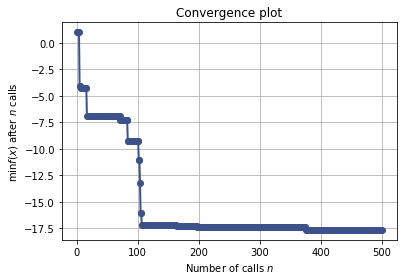

In [15]:
#convergence plot
from skopt.plots import plot_convergence
plot_convergence(res_gp2)
print("Best parameters: \
\n jet_time_cuts = [{}] \
\n jet_tmf_cuts = [{}]".format(res_gp2.x[0],
                               res_gp2.x[1]))
      

QCD_HT_all, background 23087
QCD_HT_all, background bin 0  3.417499807153945
QCD_HT_all, background bin 1  0.026973537528647284
QCD_HT_all, background bin 2  4.27638315159129e-06
QCD_HT_all, background bin >0  3695.960505916446
unique nTags element:  [0 1 3]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1823
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.007629067040397786
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.00599774525835528
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.0011687081423588097
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin >0  981.8041158978303
unique nTags element:  [0 1 2 3]
PLOTTING
QCD_HT_all, background 1 4.27638315159129e-06
QCD_HT_all, background bkg weight [8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05
 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05]
QCD_HT_all, background bkg bins 0.0
max_value 468197.47358007287
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m factor 0.0
cnt H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 144 0.001168708

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


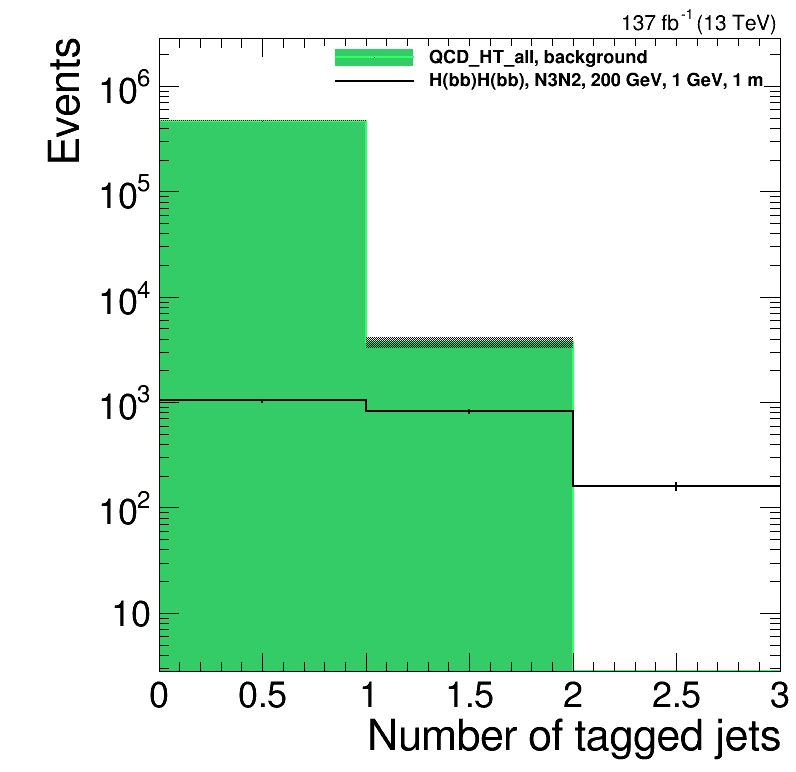

In [21]:
# plot the optimized situation
plotting = True

#2-variable
time_cuts = [0.41523450174046633]
tmf_et_cuts = [0.05190697804648957]
delta_r_cuts = [0]
chef_cuts = [500]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin >0 ', 137000*sum(trg_jet_w[k][nTags[k]>=1]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.88,0.96,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*3)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(5):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()


QCD_HT_all, background 23087
QCD_HT_all, background bin 0  3.417499807153945
QCD_HT_all, background bin 1  0.026973537528647284
QCD_HT_all, background bin 2  4.27638315159129e-06
QCD_HT_all, background bin >0  3695.960505916446
unique nTags element:  [0 1 3]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1823
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.007629067040397786
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.00599774525835528
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.0011687081423588097
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin >0  981.8041158978303
unique nTags element:  [0 1 2 3]
PLOTTING
QCD_HT_all, background 0 0.0
QCD_HT_all, background bkg weight [8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05
 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05]
QCD_HT_all, background bkg bins 0.0
max_value 468197.47358007287
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m factor 0.0
cnt H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 141 0.0011443600560596678
total 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TH1D::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


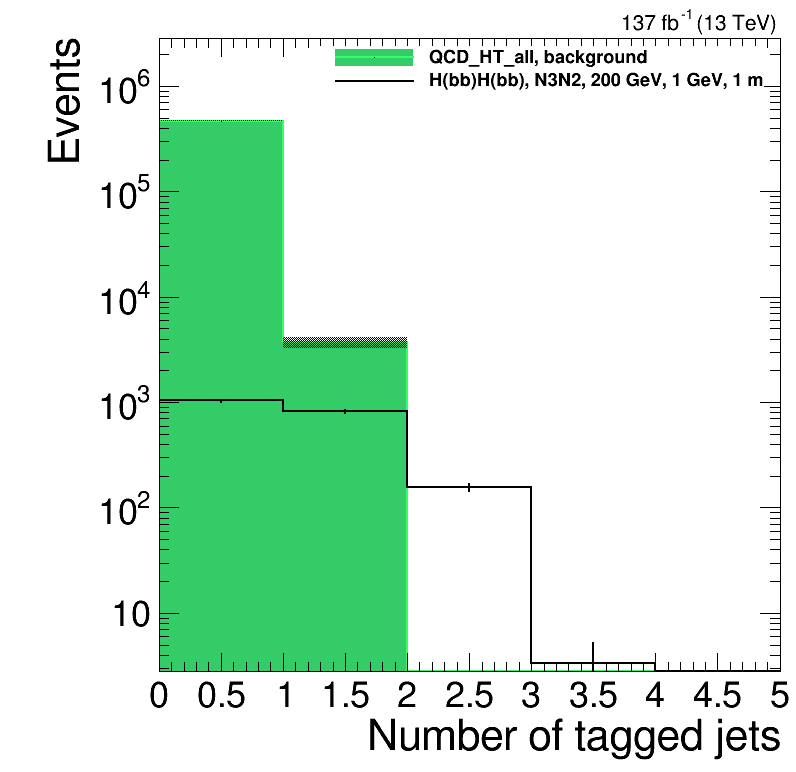

In [82]:
# plot the optimized situation
plotting = True

#2-variable
time_cuts = [0.41523450174046633]
tmf_et_cuts = [0.05190697804648957]
delta_r_cuts = [0]
chef_cuts = [500]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin >0 ', 137000*sum(trg_jet_w[k][nTags[k]>=1]))
                    print('unique nTags element: ', np.unique(nTags[k]))
#                     for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
#                         if ele > 2:
#                             nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.88,0.96,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[5,0,5],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*3)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[5,0,5],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(5):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()


In [17]:
#3-variable

In [22]:
## optimization
i=0
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

sig_bins = [0,1,2]


space3 = [
          Real(0, 10, name='jet_time'),
          Real(0.0,1.5, name='jet_tmf'),
          Real(0.0,1.5,name='jetMinDeltaRPVTracks')
# ,
#           Real(0.0,1.5,name = 'jet_chef')
          ]

# def figure_of_merit2(time_cut = -50, tmf_et_cut = 50):
def figure_of_merit3(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50):
# def figure_of_merit(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50, chef_cut = -50):
    nTags = {}
    sig_count = [] 
    bkg_count = np.zeros((3,))
    
    for k,T in trg_jet_tmf.items():
#         start_t = time.time()
        nTags[k] = []
#         tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_t[k]>time_cut) 
        tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
        tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
#         tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)
#         nTags[k] = [len(x) for x in pf_jet_pt[k][tagged_jet]] #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.array(nTags[k])
        print(k, tagged_jet[:10])
        print(k, trg_jet_pt[k][:10])
        print(k, trg_jet_pt[k][tagged_jet][:10])
        print(k, 'count', trg_jet_pt[k][tagged_jet].count()[:10])
        nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.sum(w[tagged_jet])
#         nJets[k] = np.sum(w[w<8000000])
        print(k, 'nTags', nTags[k][:10])
        print(k, 'unique', np.unique(nTags[k]))
        nTags[k] = np.array(nTags[k])
            
        occurCount = []
        for i in sig_bins:
            print('sig bin', i)
            if i == 2:
#               #overflow bin
                tag_cut = nTags[k] >= i 
            else:
                tag_cut = nTags[k] == i
            w_sum = sum(trg_jet_w[k][tag_cut])
#             w_sum = sum(weight[k][tag_cut])
            print('sig bin', i, 'w_sum', w_sum)
            
            occurCount.append(w_sum)
        print(occurCount)
        occurCount = np.array(occurCount)
        
        if 'background' not in k :
            sig_count = list(occurCount[:2])
            sig_count.append(sum(occurCount[2:]))
            sig_count = np.array(sig_count)
        elif 'background' in k:
            bkg_count = bkg_count + occurCount

#     cond = np.logical_not(np.logical_or(sig_count < 5,bkg_count < 5))
    sig_count = sig_count*137000
    bkg_count = bkg_count*137000
    print("sig count", sig_count)
    print("bkg count", bkg_count)
    cond = sig_count > 5
    if not np.count_nonzero(cond) == len(sig_bins):
        return 1

#     return -1.0*np.sum(2*((s+b)*math.log(s/b+1)-s))**0.5

    # loss function: - significance  = - (sqrt(S/(S+B)))
    return -1.0 * np.sum(sig_count**2/(sig_count+bkg_count))**0.5

@use_named_args(space3)
def objective3(**X):
    print("New configuration: {}".format(X))
#     begt = time.time()
#     fom = figure_of_merit2(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'])
    fom = figure_of_merit3(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'])
#     fom = figure_of_merit(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'],chef_cut = X['jet_chef'])
#     fom = train(model, learning_rate=X['learning_rate'])
    return fom


# res_gp = gp_minimize(objective, space, n_calls=5, n_random_starts=1, random_state=123, verbose=True)
# res_gp2 = gp_minimize(objective2, space2, n_calls=500, n_random_starts=100, random_state=123, verbose=True)
res_gp3 = gp_minimize(objective3, space3, n_calls=500, n_random_starts=100, random_state=123, verbose=True)


Iteration No: 1 started. Evaluating function at random point.
New configuration: {'jet_time': 7.129553205232273, 'jet_tmf': 0.6427063892802387, 'jetMinDeltaRPVTracks': 1.0363272825402927}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m [[False False] [False] [False] ... [False] [False] [False]]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 1.6966
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 102 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 1.7797
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 103 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 1.7222
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 104 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.3366552949290125, 'jet_tmf': 1.4703355801766995, 'jetMinDeltaRPVTracks': 0.018942222849763775}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] [91.43986]]
QCD_HT_all, background count [0 0 0 1 0 0 1 0 0 1]
QCD_HT_all, background nTags [0 0 0 1 0 0 1 0 0 1]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7]
sig bin 0
sig bin 0 w_sum 1.9927765331040064
sig bin 1
sig bin 1 w_sum 0.993704141886155

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.5048
Function value obtained: -3.1897
Current minimum: -3.1897
Iteration No: 105 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.6006
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 106 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444776210657437, 0, 0]
H(bb)H(bb), N3N2, 200 GeV,

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.3279
Function value obtained: 1.0000
Current minimum: -3.5210
Iteration No: 107 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.565938809661828, 'jet_tmf': 1.4957021999599354, 'jetMinDeltaRPVTracks': 0.004117070144688152}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2 3 4 5]
sig bin 0
sig bin 0 w_sum 2.530672197871354
sig bin 1
sig bin 1 w_sum 0.7345506952196956
sig bin 2


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.3880
Function value obtained: -3.1920
Current minimum: -3.5210
Iteration No: 108 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.025861835994851, 'jet_tmf': 0.0033768665680504193, 'jetMinDeltaRPVTracks': 1.489983379789349}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
[3.4444

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.3528
Function value obtained: 1.0000
Current minimum: -3.5210
Iteration No: 109 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.1555309992262577, 'jet_tmf': 1.3653959927175765, 'jetMinDeltaRPVTracks': 0.0009340988603966929}
QCD_HT_all, background [[False False False True] [False False True False] [True] ... [True] [False False] [False False False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[74.90998] [200.28743] [229.15395] ... [47.71397] [] [91.43986]]
QCD_HT_all, background count [1 1 1 1 0 0 1 1 0 1]
QCD_HT_all, background nTags [1 1 1 1 0 0 1 1 0 1]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 1.2069499069848462
sig bin

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.4754
Function value obtained: -3.2359
Current minimum: -3.5210
Iteration No: 110 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.5800
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 111 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.3674
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 112 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.6336
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 113 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.4739
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 114 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.6268
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 115 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.6326
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 116 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.6161
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 117 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.5223
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 118 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.6534
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 119 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.6862
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 120 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.9326
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 121 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 3.1423
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 122 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 3.1969
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 123 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.8873
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 124 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.7573
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 125 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 3.0214
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 126 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 3.0475
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 127 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 3.2066
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 128 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.8944
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 129 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 3.1107
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 130 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 3.0507
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 131 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 3.4118
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 132 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 3.2440
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 133 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 3.4842
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 134 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 3.0040
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 135 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 3.5322
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 136 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 3.4844
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 137 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 3.5205
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 138 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 3.6595
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 139 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 3.9490
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 140 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 3.7670
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 141 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 3.7172
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 142 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 3.2215
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 143 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.8025
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 144 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.7545
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 145 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 4.0895
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 146 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.5367
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 147 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 4.2115
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 148 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 3.7019
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 149 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.6853
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 150 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.6869
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 151 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 4.2795
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 152 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 3.6917
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 153 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 4.4314
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 154 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 3.9013
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 155 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 4.1368
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 156 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 4.1895
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 157 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 4.5773
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 158 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 4.3573
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 159 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 4.1198
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 160 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 4.4121
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 161 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 3.8923
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 162 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 4.6004
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 163 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 4.1192
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 164 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 5.0799
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 165 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 4.8779
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 166 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 4.7747
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 167 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 5.1798
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 168 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 5.1362
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 169 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 4.9409
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 170 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 4.7217
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 171 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 5.3882
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 172 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 5.1339
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 173 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 4.6593
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 174 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 5.2882
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 175 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 4.9363
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 176 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 5.0633
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 177 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 5.2480
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 178 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 5.0868
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 179 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 4.9812
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 180 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 5.7832
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 181 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 6.5824
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 182 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 5.3958
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 183 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 5.6158
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 184 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 5.6858
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 185 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 5.6703
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 186 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 5.6048
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 187 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 5.4241
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 188 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 5.7771
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 189 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 5.8088
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 190 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 5.5073
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 191 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 6.0271
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 192 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 5.8745
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 193 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 6.1574
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 194 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 5.7716
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 195 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 5.9836
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 196 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 6.1321
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 197 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 6.4674
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 198 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 5.5513
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 199 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 6.2380
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 200 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 7.0413
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 201 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 6.6559
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 202 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 6.6858
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 203 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 6.9062
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 204 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 6.7768
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 205 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 6.9722
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 206 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 6.5318
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 207 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 7.1024
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 208 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 6.4386
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 209 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 7.0036
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 210 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 7.2269
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 211 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 7.0013
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 212 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 7.0367
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 213 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 6.6008
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 214 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 6.8839
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 215 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 6.9729
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 216 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 6.5872
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 217 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 7.7492
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 218 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 7.5259
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 219 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 7.6188
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 220 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 7.2682
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 221 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 7.8320
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 222 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 8.3163
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 223 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 8.4235
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 224 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 8.5153
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 225 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 8.3145
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 226 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 7.9554
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 227 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 8.0188
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 228 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 8.2231
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 229 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 8.5239
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 230 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 8.5128
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 231 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 9.2574
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 232 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 8.5576
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 233 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 9.5097
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 234 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 8.1978
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 235 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 8.9723
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 236 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 9.3295
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 237 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 9.1646
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 238 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 8.8994
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 239 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 9.0817
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 240 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 10.0551
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 241 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 10.3817
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 242 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 10.1660
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 243 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 9.5448
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 244 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 10.5417
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 245 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 9.4471
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 246 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 8.9075
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 247 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 10.8167
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 248 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 9.5170
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 249 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 9.8335
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 250 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 9.9020
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 251 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 9.6021
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 252 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 9.5774
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 253 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bin

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 10.0272
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 254 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 11.3852
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 255 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 10.8909
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 256 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 10.2259
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 257 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 12.2066
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 258 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 10.5822
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 259 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 10.9210
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 260 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 10.2207
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 261 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 10.6271
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 262 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 11.0793
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 263 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 11.7939
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 264 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 10.9194
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 265 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 11.2547
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 266 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 10.6527
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 267 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 10.7039
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 268 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 10.4983
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 269 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 11.1161
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 270 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 11.8244
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 271 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 11.5780
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 272 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 11.3846
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 273 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 10.5755
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 274 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 11.5132
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 275 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 11.0709
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 276 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 11.2606
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 277 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 11.0002
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 278 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 11.4200
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 279 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 11.7930
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 280 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 11.0115
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 281 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 12.1614
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 282 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 12.4907
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 283 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 12.6247
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 284 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 11.9701
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 285 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 12.4070
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 286 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 11.5172
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 287 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 12.0984
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 288 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 11.9104
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 289 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 12.7147
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 290 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 12.2285
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 291 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 13.7831
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 292 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 12.1017
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 293 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 12.0504
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 294 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 13.2968
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 295 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 13.3332
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 296 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 12.9520
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 297 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 12.9545
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 298 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 13.1176
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 299 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 13.1296
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 300 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 13.3473
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 301 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 301 ended. Search finished for the next optimal point.
Time taken: 12.9896
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 302 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 302 ended. Search finished for the next optimal point.
Time taken: 13.3918
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 303 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 303 ended. Search finished for the next optimal point.
Time taken: 13.7771
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 304 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 304 ended. Search finished for the next optimal point.
Time taken: 13.3602
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 305 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 305 ended. Search finished for the next optimal point.
Time taken: 13.8814
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 306 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 306 ended. Search finished for the next optimal point.
Time taken: 14.0446
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 307 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 307 ended. Search finished for the next optimal point.
Time taken: 13.8876
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 308 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 13.4805
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 309 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 14.2176
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 310 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 310 ended. Search finished for the next optimal point.
Time taken: 13.6950
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 311 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 13.7129
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 312 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 13.8343
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 313 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 14.9836
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 314 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 15.0246
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 315 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 14.4876
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 316 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 14.4451
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 317 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 14.8605
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 318 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 14.4475
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 319 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 15.9714
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 320 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 320 ended. Search finished for the next optimal point.
Time taken: 14.9525
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 321 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 321 ended. Search finished for the next optimal point.
Time taken: 15.7655
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 322 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 322 ended. Search finished for the next optimal point.
Time taken: 16.1727
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 323 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 323 ended. Search finished for the next optimal point.
Time taken: 16.5534
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 324 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 324 ended. Search finished for the next optimal point.
Time taken: 15.4520
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 325 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m nTags [1 0 1 1 0 0 1 1 1 1]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 0.002840610068233218
sig bin 1
sig bin 1 w_sum 0.00860299049236346
sig bin 2
sig bin 2 w_sum 0.0033519198805151973
[0.002840610068233218, 0.00860299049236346, 0.0033519198805151973]
sig count [ 389.16357935 1178.60969745  459.21302363]
bkg count [ 96975.02528353 138397.46326974 236520.94553274]
Iteration No: 325 ended. Search finished for the next optimal point.
Time taken: 15.2858
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 326 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] 

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 326 ended. Search finished for the next optimal point.
Time taken: 16.0040
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 327 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 16.4177
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 328 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 16.6854
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 329 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 329 ended. Search finished for the next optimal point.
Time taken: 16.7100
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 330 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 330 ended. Search finished for the next optimal point.
Time taken: 17.0400
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 331 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 331 ended. Search finished for the next optimal point.
Time taken: 18.6278
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 332 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 332 ended. Search finished for the next optimal point.
Time taken: 17.3789
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 333 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 333 ended. Search finished for the next optimal point.
Time taken: 18.3231
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 334 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 334 ended. Search finished for the next optimal point.
Time taken: 16.3185
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 335 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 335 ended. Search finished for the next optimal point.
Time taken: 17.1000
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 336 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 336 ended. Search finished for the next optimal point.
Time taken: 17.2277
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 337 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 16.8650
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 338 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 338 ended. Search finished for the next optimal point.
Time taken: 15.8334
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 339 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 339 ended. Search finished for the next optimal point.
Time taken: 17.9480
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 340 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 340 ended. Search finished for the next optimal point.
Time taken: 17.3182
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 341 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 341 ended. Search finished for the next optimal point.
Time taken: 17.7350
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 342 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 342 ended. Search finished for the next optimal point.
Time taken: 17.8432
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 343 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 343 ended. Search finished for the next optimal point.
Time taken: 18.3262
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 344 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 344 ended. Search finished for the next optimal point.
Time taken: 16.9247
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 345 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 18.7188
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 346 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 17.5857
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 347 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 18.0576
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 348 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 17.3650
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 349 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 349 ended. Search finished for the next optimal point.
Time taken: 18.1313
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 350 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 350 ended. Search finished for the next optimal point.
Time taken: 17.6275
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 351 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 351 ended. Search finished for the next optimal point.
Time taken: 18.0761
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 352 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 352 ended. Search finished for the next optimal point.
Time taken: 18.3200
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 353 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 353 ended. Search finished for the next optimal point.
Time taken: 18.4583
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 354 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 18.4324
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 355 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 17.2518
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 356 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 20.2925
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 357 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 18.1608
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 358 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 18.5779
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 359 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 359 ended. Search finished for the next optimal point.
Time taken: 18.7512
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 360 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 360 ended. Search finished for the next optimal point.
Time taken: 18.4811
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 361 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 361 ended. Search finished for the next optimal point.
Time taken: 17.8652
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 362 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 362 ended. Search finished for the next optimal point.
Time taken: 18.6471
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 363 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 363 ended. Search finished for the next optimal point.
Time taken: 19.6242
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 364 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 364 ended. Search finished for the next optimal point.
Time taken: 18.7255
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 365 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 365 ended. Search finished for the next optimal point.
Time taken: 19.0336
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 366 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 18.6388
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 367 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 367 ended. Search finished for the next optimal point.
Time taken: 19.3431
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 368 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 368 ended. Search finished for the next optimal point.
Time taken: 19.8426
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 369 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 369 ended. Search finished for the next optimal point.
Time taken: 20.0999
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 370 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 370 ended. Search finished for the next optimal point.
Time taken: 18.5671
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 371 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


 0 w_sum 0.002840610068233218
sig bin 1
sig bin 1 w_sum 0.00860299049236346
sig bin 2
sig bin 2 w_sum 0.0033519198805151973
[0.002840610068233218, 0.00860299049236346, 0.0033519198805151973]
sig count [ 389.16357935 1178.60969745  459.21302363]
bkg count [ 96975.02528353 138397.46326974 236520.94553274]
Iteration No: 371 ended. Search finished for the next optimal point.
Time taken: 20.3688
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 372 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.9

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 372 ended. Search finished for the next optimal point.
Time taken: 18.7906
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 373 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 373 ended. Search finished for the next optimal point.
Time taken: 19.7880
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 374 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 374 ended. Search finished for the next optimal point.
Time taken: 20.3093
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 375 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 375 ended. Search finished for the next optimal point.
Time taken: 19.3155
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 376 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 19.5508
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 377 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 377 ended. Search finished for the next optimal point.
Time taken: 19.9296
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 378 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 378 ended. Search finished for the next optimal point.
Time taken: 20.2502
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 379 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 23.2444
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 380 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 20.4421
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 381 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 21.8267
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 382 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 20.9243
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 383 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 383 ended. Search finished for the next optimal point.
Time taken: 21.4748
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 384 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 384 ended. Search finished for the next optimal point.
Time taken: 21.1615
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 385 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 385 ended. Search finished for the next optimal point.
Time taken: 22.3900
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 386 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 20.9103
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 387 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 387 ended. Search finished for the next optimal point.
Time taken: 21.9807
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 388 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 388 ended. Search finished for the next optimal point.
Time taken: 21.7712
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 389 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 389 ended. Search finished for the next optimal point.
Time taken: 21.1735
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 390 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 390 ended. Search finished for the next optimal point.
Time taken: 21.5396
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 391 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 391 ended. Search finished for the next optimal point.
Time taken: 23.0215
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 392 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 392 ended. Search finished for the next optimal point.
Time taken: 21.5151
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 393 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 22.0598
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 394 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 21.7348
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 395 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 21.9179
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 396 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 22.2473
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 397 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 24.0868
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 398 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 398 ended. Search finished for the next optimal point.
Time taken: 23.0364
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 399 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 399 ended. Search finished for the next optimal point.
Time taken: 23.9922
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 400 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 400 ended. Search finished for the next optimal point.
Time taken: 23.0224
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 401 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 401 ended. Search finished for the next optimal point.
Time taken: 23.3982
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 402 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 402 ended. Search finished for the next optimal point.
Time taken: 24.2165
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 403 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 403 ended. Search finished for the next optimal point.
Time taken: 22.1989
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 404 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 404 ended. Search finished for the next optimal point.
Time taken: 25.4323
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 405 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 405 ended. Search finished for the next optimal point.
Time taken: 25.0236
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 406 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 22.0096
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 407 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 407 ended. Search finished for the next optimal point.
Time taken: 23.8877
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 408 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 408 ended. Search finished for the next optimal point.
Time taken: 26.5261
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 409 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 409 ended. Search finished for the next optimal point.
Time taken: 24.0237
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 410 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 410 ended. Search finished for the next optimal point.
Time taken: 23.3652
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 411 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 411 ended. Search finished for the next optimal point.
Time taken: 24.4513
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 412 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 412 ended. Search finished for the next optimal point.
Time taken: 23.5516
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 413 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 413 ended. Search finished for the next optimal point.
Time taken: 24.3995
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 414 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 414 ended. Search finished for the next optimal point.
Time taken: 23.3114
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 415 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 25.2399
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 416 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 23.5151
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 417 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 417 ended. Search finished for the next optimal point.
Time taken: 24.6793
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 418 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 418 ended. Search finished for the next optimal point.
Time taken: 27.1684
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 419 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 419 ended. Search finished for the next optimal point.
Time taken: 24.1127
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 420 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 420 ended. Search finished for the next optimal point.
Time taken: 25.1039
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 421 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 421 ended. Search finished for the next optimal point.
Time taken: 25.6059
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 422 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 422 ended. Search finished for the next optimal point.
Time taken: 24.6944
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 423 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 423 ended. Search finished for the next optimal point.
Time taken: 25.2105
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 424 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 424 ended. Search finished for the next optimal point.
Time taken: 25.0227
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 425 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 425 ended. Search finished for the next optimal point.
Time taken: 25.7791
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 426 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 426 ended. Search finished for the next optimal point.
Time taken: 25.4488
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 427 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 427 ended. Search finished for the next optimal point.
Time taken: 25.8195
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 428 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 428 ended. Search finished for the next optimal point.
Time taken: 27.1664
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 429 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 429 ended. Search finished for the next optimal point.
Time taken: 25.1430
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 430 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 430 ended. Search finished for the next optimal point.
Time taken: 23.7633
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 431 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 431 ended. Search finished for the next optimal point.
Time taken: 24.7443
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 432 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 432 ended. Search finished for the next optimal point.
Time taken: 25.4612
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 433 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 433 ended. Search finished for the next optimal point.
Time taken: 26.5433
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 434 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 26.9585
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 435 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 28.7294
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 436 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 436 ended. Search finished for the next optimal point.
Time taken: 26.1818
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 437 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 437 ended. Search finished for the next optimal point.
Time taken: 27.6045
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 438 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 438 ended. Search finished for the next optimal point.
Time taken: 27.2245
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 439 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 439 ended. Search finished for the next optimal point.
Time taken: 28.1804
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 440 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 440 ended. Search finished for the next optimal point.
Time taken: 25.6693
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 441 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 441 ended. Search finished for the next optimal point.
Time taken: 27.5368
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 442 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 442 ended. Search finished for the next optimal point.
Time taken: 26.6236
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 443 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 443 ended. Search finished for the next optimal point.
Time taken: 26.3863
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 444 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 444 ended. Search finished for the next optimal point.
Time taken: 26.5016
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 445 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 445 ended. Search finished for the next optimal point.
Time taken: 28.0140
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 446 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 446 ended. Search finished for the next optimal point.
Time taken: 28.1211
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 447 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 447 ended. Search finished for the next optimal point.
Time taken: 29.3297
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 448 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 448 ended. Search finished for the next optimal point.
Time taken: 26.7525
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 449 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 449 ended. Search finished for the next optimal point.
Time taken: 31.1330
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 450 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m nTags [1 0 1 1 0 0 1 1 1 1]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 0.002840610068233218
sig bin 1
sig bin 1 w_sum 0.00860299049236346
sig bin 2
sig bin 2 w_sum 0.0033519198805151973
[0.002840610068233218, 0.00860299049236346, 0.0033519198805151973]
sig count [ 389.16357935 1178.60969745  459.21302363]
bkg count [ 96975.02528353 138397.46326974 236520.94553274]
Iteration No: 450 ended. Search finished for the next optimal point.
Time taken: 28.5552
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 451 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] 

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 451 ended. Search finished for the next optimal point.
Time taken: 27.7039
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 452 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 452 ended. Search finished for the next optimal point.
Time taken: 28.0909
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 453 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 453 ended. Search finished for the next optimal point.
Time taken: 27.9090
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 454 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 454 ended. Search finished for the next optimal point.
Time taken: 28.6662
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 455 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 455 ended. Search finished for the next optimal point.
Time taken: 31.3924
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 456 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 456 ended. Search finished for the next optimal point.
Time taken: 28.3068
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 457 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 457 ended. Search finished for the next optimal point.
Time taken: 31.7489
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 458 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 458 ended. Search finished for the next optimal point.
Time taken: 30.5672
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 459 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 459 ended. Search finished for the next optimal point.
Time taken: 28.7852
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 460 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 460 ended. Search finished for the next optimal point.
Time taken: 31.0340
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 461 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 461 ended. Search finished for the next optimal point.
Time taken: 29.2677
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 462 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 462 ended. Search finished for the next optimal point.
Time taken: 31.5469
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 463 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 463 ended. Search finished for the next optimal point.
Time taken: 31.0384
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 464 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 30.3864
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 465 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 465 ended. Search finished for the next optimal point.
Time taken: 32.1015
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 466 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 466 ended. Search finished for the next optimal point.
Time taken: 31.2479
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 467 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 467 ended. Search finished for the next optimal point.
Time taken: 31.5288
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 468 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 468 ended. Search finished for the next optimal point.
Time taken: 31.2787
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 469 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 469 ended. Search finished for the next optimal point.
Time taken: 32.6973
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 470 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 470 ended. Search finished for the next optimal point.
Time taken: 30.8967
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 471 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 471 ended. Search finished for the next optimal point.
Time taken: 32.8391
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 472 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 472 ended. Search finished for the next optimal point.
Time taken: 31.3679
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 473 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 473 ended. Search finished for the next optimal point.
Time taken: 33.0341
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 474 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 31.5956
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 475 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 475 ended. Search finished for the next optimal point.
Time taken: 30.9841
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 476 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 476 ended. Search finished for the next optimal point.
Time taken: 30.7575
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 477 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 477 ended. Search finished for the next optimal point.
Time taken: 32.5790
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 478 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 478 ended. Search finished for the next optimal point.
Time taken: 30.8467
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 479 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 479 ended. Search finished for the next optimal point.
Time taken: 31.5362
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 480 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 480 ended. Search finished for the next optimal point.
Time taken: 31.6600
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 481 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 481 ended. Search finished for the next optimal point.
Time taken: 32.2855
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 482 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 482 ended. Search finished for the next optimal point.
Time taken: 31.7923
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 483 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 483 ended. Search finished for the next optimal point.
Time taken: 32.3507
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 484 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 32.9454
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 485 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 485 ended. Search finished for the next optimal point.
Time taken: 31.8975
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 486 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)



H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m count [1 0 1 1 0 0 1 1 1 1]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m nTags [1 0 1 1 0 0 1 1 1 1]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m unique [0 1 2 3 4]
sig bin 0
sig bin 0 w_sum 0.002840610068233218
sig bin 1
sig bin 1 w_sum 0.00860299049236346
sig bin 2
sig bin 2 w_sum 0.0033519198805151973
[0.002840610068233218, 0.00860299049236346, 0.0033519198805151973]
sig count [ 389.16357935 1178.60969745  459.21302363]
bkg count [ 96975.02528353 138397.46326974 236520.94553274]
Iteration No: 486 ended. Search finished for the next optimal point.
Time taken: 30.7641
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 487 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.1

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 487 ended. Search finished for the next optimal point.
Time taken: 33.4394
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 488 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 488 ended. Search finished for the next optimal point.
Time taken: 35.5817
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 489 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 489 ended. Search finished for the next optimal point.
Time taken: 33.6027
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 490 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 490 ended. Search finished for the next optimal point.
Time taken: 31.8354
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 491 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 491 ended. Search finished for the next optimal point.
Time taken: 33.0001
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 492 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 492 ended. Search finished for the next optimal point.
Time taken: 30.9715
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 493 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 493 ended. Search finished for the next optimal point.
Time taken: 34.2966
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 494 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 31.8369
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 495 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 495 ended. Search finished for the next optimal point.
Time taken: 34.0625
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 496 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 496 ended. Search finished for the next optimal point.
Time taken: 32.3765
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 497 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 497 ended. Search finished for the next optimal point.
Time taken: 36.2860
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 498 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 498 ended. Search finished for the next optimal point.
Time taken: 32.3671
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 499 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 499 ended. Search finished for the next optimal point.
Time taken: 32.9878
Function value obtained: -3.5210
Current minimum: -3.5210
Iteration No: 500 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
sig bin 1
sig bi

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 500 ended. Search finished for the next optimal point.
Time taken: 32.5334
Function value obtained: -3.5210
Current minimum: -3.5210


Best parameters: 
 jet_time_cuts = [0.0] 
 jet_tmf_cuts = [1.5] 
 jet_delta_r_cuts = [0.0]


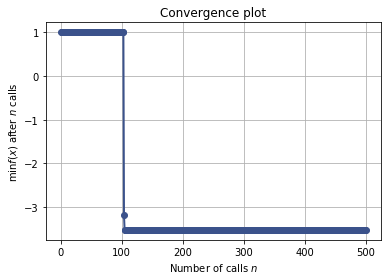

In [23]:
#convergence plot
from skopt.plots import plot_convergence
plot_convergence(res_gp3)
print("Best parameters: \
\n jet_time_cuts = [{}] \
\n jet_tmf_cuts = [{}] \
\n jet_delta_r_cuts = [{}]".format(res_gp3.x[0],
                                 res_gp3.x[1],
                                 res_gp3.x[2]))


QCD_HT_all, background 23087
QCD_HT_all, background bin 0  3.438593769763429
QCD_HT_all, background bin 1  0.005883851302314724
QCD_HT_all, background bin 2  0
unique nTags element:  [0 1]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 1823
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 0  0.007474862493836554
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 1  0.006557751243235543
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m bin 2  0.0007629067040397786
unique nTags element:  [0 1 2]
PLOTTING
QCD_HT_all, background 0 0.0
QCD_HT_all, background bkg weight [8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05
 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05 8.1493301e-05]
QCD_HT_all, background bkg bins 0.0
max_value 471087.34645757213
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m factor 0.0
cnt H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 94 0.0007629067040397786
total 471087.34645757213 7327.398981908168
0 1024.0561616556079 471087.34645757213
1 898.4119203232694 806.0876284171172
2 104.51821845344966 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: total (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: QCD_HT_all, background (Potential memory leak).
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


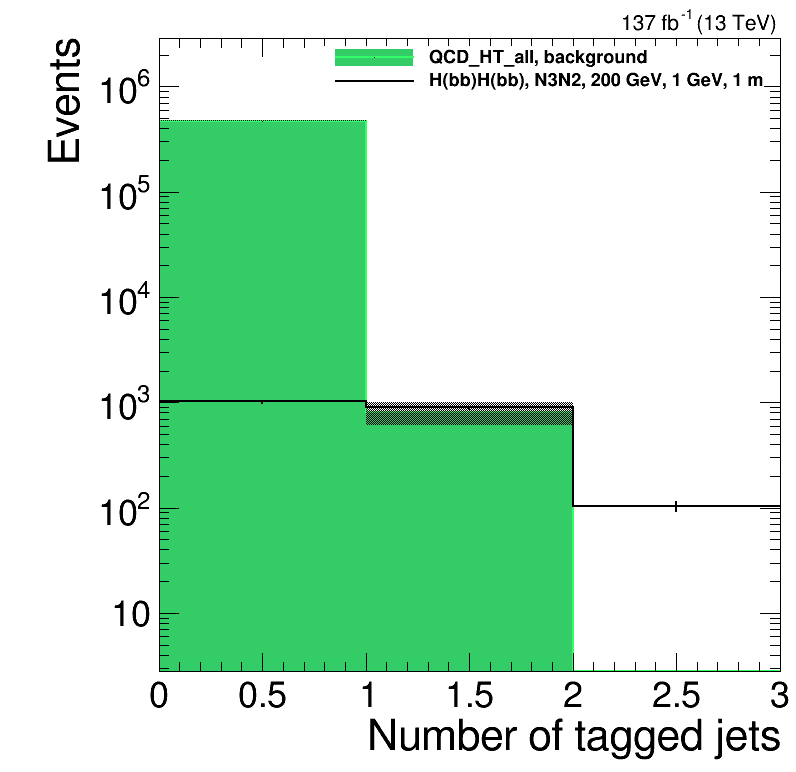

In [247]:
# plot the optimized situation
plotting = True

#signal>5
time_cuts = [0.08676443430239597] 
tmf_et_cuts = [0.16335152541277656] 
delta_r_cuts = [0.06402562462487048]
chef_cuts = [0.061590940809278155]

#test
# time_cuts = [0] 
# tmf_et_cuts = [0.2] 
# delta_r_cuts = [0.1]
# chef_cuts = [0.75]

 
validity = []
significance = []
nTags = {}
nJets = {}
for chef_cut in chef_cuts:
    for tmf_et_cut in tmf_et_cuts: #loop over the three variables
        for time_cut in time_cuts:
            for delta_r_cut in delta_r_cuts:
                #go through each sample
    #         
                for k,T in trg_jet_tmf.items():
                    print(k, len(T))
                    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
                    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)

                    nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no trg_jet_ws added
#                     print(k, 'bin 0 ', len(trg_jet_w[k][nTags[k]==0]))
#                     print(k, 'bin 1 ', len(trg_jet_w[k][nTags[k]==1]))
#                     print(k, 'bin 2 ', len(trg_jet_w[k][nTags[k]>=2]))
                    print(k, 'bin 0 ', sum(trg_jet_w[k][nTags[k]==0]))
                    print(k, 'bin 1 ', sum(trg_jet_w[k][nTags[k]==1]))
                    print(k, 'bin 2 ', sum(trg_jet_w[k][nTags[k]>=2]))
                    print('unique nTags element: ', np.unique(nTags[k]))
                    for i,ele in enumerate(nTags[k]):
#                         print('nTags element: ', i, ' th, ', ele)
                        if ele > 2:
                            nTags[k][i] = 2
                if plotting:
                    print('PLOTTING')
                      # Plotting THStack
                    c = rt.TCanvas('c','c', 800, 800)
                    h = {}
                    # leg = rt.TLegend(0.59,0.70,0.97,0.93)
                    leg = rt.TLegend(0.40,0.88,0.96,0.94)

                    leg.SetTextSize(0.025)
                    leg.SetBorderSize(0)
                    # leg.SetTextFont(42)
                    leg.SetEntrySeparation(0.01)
                    stack = rt.THStack( "hs" , "Hgg Stack " )
                    total = rt.TH1D('total','total',3,0,3)
                    # color_list = [625,597,876,806,861,393,845]
                    color_list = [845,800,861,806,876,597,625]
                    keys = ['QCD_HT_all, background']
                    sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m']
                    bkg_integral = 0.0
                    max_value = 0
                    i=0
                    for k in keys:
                        if 'background' in k or True:
                            v = nTags[k]
                            v = v
                            w = trg_jet_w[k] +  v * 0.0
                            v = v.flatten()
                            w = w.flatten()
                            v = v[w<8000000]
                            cond = v==2

    #                         print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                            w = w[w<8000000]

                            h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                            h[k].Sumw2()
                            total.Add(h[k])
                            stack.Add( h[k])
                            h[k].SetLineColor(color_list[i]+3)
                            h[k].SetFillColor(color_list[i])
                            leg.AddEntry(h[k],k)
                            max_value += h[k].GetBinContent(h[k].GetMaximumBin())
                            bkg_integral += h[k].Integral()
                            print(k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))
                            print(k, 'bkg weight', w[:10])
                            print(k, 'bkg bins', h[k].GetBinContent(0))

                            i+=1
                    stack.Draw('hist')
    #                 stack.GetYaxis().SetLabelSize(0.)
                    stack.SetMaximum(max_value*3)
                    print('max_value',max_value)
                    stack.SetMinimum(10)
                    stack.GetYaxis().SetTitle("Events")
                    stack.GetXaxis().SetTitle('Number of tagged jets')



                    i=0
                    for k in sig_keys:
                        v = nTags[k]
                #         v = v[weight[k]<8000000]
                #         w = weight[k][weight[k]<8000000] +  v * 0.0
                        v = v
                        w = trg_jet_w[k] +  v * 0.0
                        v = v.flatten()
                        w = w.flatten()
                        v = v[w<8000000]
                        cond = v==2
    #                     print(k,  runNum[k][w<8000000][cond],lumiSec[k][w<8000000][cond],evtNum[k][w<8000000][cond],w[w<8000000][cond])

                        w = w[w<8000000]
                        factor = bkg_integral/np.sum(w)
                        print(k,'factor',1.0*np.sum(w[v>50])/np.sum(w))
                        h[k] = create_TH1D( v, axis_title=['Tagged delayed jets', 'Events'], name=k, binning=[3,0,3],weights = w*137000)
                        h[k].Sumw2()
                        h[k].SetLineColor(std_color_list[i])
                        h[k].Draw("hist E same")
                        leg.AddEntry(h[k],k)
                        max_value = max(h[k].GetBinContent(h[k].GetMaximumBin()),max_value)
                        print('cnt',k,np.count_nonzero(w[v==2]),np.sum(w[v==2]))

                        i+=1
                    leg.Draw()
 
                    last = stack.GetStack().Last()
    #                 last.SetMarkerColor(1)
    #                 last.SetFillColor(1)
                    total.SetFillStyle(3001)
                    total.SetLineColor(1)
                    total.SetFillColor(1)
                
                    total.GetYaxis().SetTitleOffset(1.6)
                    total.Draw("same e2")
                    print("total",total.GetBinContent(1),total.GetBinError(1))
                    
                    
                    purity = 0.
                    for i in range(3):#loop over the bins of the stack plot

                        b = last.GetBinContent(i+1)
                        s = h['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m'].GetBinContent(i+1)
                        print(i,s,b)
                        if not s+b ==  0:
                            purity += s**2 / (s+b)
#                             purity += 2*((s+b)*math.log(s/b+1)-s)
                        if i==2:
                            s_v = s


                    purity = purity **0.5

                    significance.append(purity)
                    validity.append(int(s_v>5))
                    print('PURITY',tmf_et_cut,time_cut, delta_r_cut, chef_cut, purity, int(s_v>5))



                    CMS_lumi.lumi_13TeV = "137 fb^{-1}"
                    CMS_lumi.cmsText = ""
                    CMS_lumi.writeExtraText = False
                    CMS_lumi.CMS_lumi(c,4,3)


                    # if setlog: 
                    #     c.SetLogy()
                    c.SetLeftMargin(0.2)
                    c.SetLogy()
                    c.Draw()


In [83]:
## optimization 0-4
i=0
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

sig_bins = [0,1,2,3,4]


space = [
          Real(0, 10, name='jet_time'),
          Real(0.0,1.5, name='jet_tmf'),
          Real(0.0,1.5,name='jetMinDeltaRPVTracks'),
          Real(0.0,1.5,name = 'jet_chef')
          ]

def figure_of_merit(time_cut = -50, tmf_et_cut = 50, delta_r_cut = -50, chef_cut = -50):
    nTags = {}
    sig_count = [] 
    bkg_count = np.zeros((5,))
    
    for k,T in trg_jet_tmf.items():
#         start_t = time.time()
        nTags[k] = []
        tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_et_cut, trg_jet_dr[k]>delta_r_cut)
        tagged_jet = np.logical_and(tagged_jet, trg_jet_t[k]>time_cut)
        tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut)
#         nTags[k] = [len(x) for x in pf_jet_pt[k][tagged_jet]] #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.array(nTags[k])
        print(k, tagged_jet[:10])
        print(k, trg_jet_pt[k][:10])
        print(k, trg_jet_pt[k][tagged_jet][:10])
        print(k, 'count', trg_jet_pt[k][tagged_jet].count()[:10])
        nTags[k] = trg_jet_pt[k][tagged_jet].count() #event level variable, number of tags jet per event, no weights added
#         nTags[k] = np.sum(w[tagged_jet])
#         nJets[k] = np.sum(w[w<8000000])
        print(k, 'nTags', nTags[k][:10])
        print(k, 'unique', np.unique(nTags[k]))
        nTags[k] = np.array(nTags[k])
            
        occurCount = []
        for i in sig_bins:
            print('sig bin', i)
#             if i == 2:
# #               #overflow bin
#                 tag_cut = nTags[k] >= i 
#             else:
#                 tag_cut = nTags[k] == i
            tag_cut = nTags[k] == i
            w_sum = sum(trg_jet_w[k][tag_cut])
#             w_sum = sum(weight[k][tag_cut])
            print('sig bin', i, 'w_sum', w_sum)
            
            occurCount.append(w_sum)
        print(occurCount)
        occurCount = np.array(occurCount)
        
        if 'background' not in k :
#             sig_count = list(occurCount[:2])
#             sig_count.append(sum(occurCount[2:]))
#             sig_count = np.array(sig_count)
            sig_count = np.array(occurCount)
        elif 'background' in k:
            bkg_count = bkg_count + occurCount

#     cond = np.logical_not(np.logical_or(sig_count < 5,bkg_count < 5))
    sig_count = sig_count*137000
    bkg_count = bkg_count*137000
    print("sig count", sig_count)
    print("bkg count", bkg_count)
    cond = sig_count > 5
    if not np.count_nonzero(cond) == len(sig_bins):
        return 1

#     return -1.0*np.sum(2*((s+b)*math.log(s/b+1)-s))**0.5

    # loss function: - significance  = - (sqrt(S/(S+B)))
    return -1.0 * np.sum(sig_count**2/(sig_count+bkg_count))**0.5

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
#     begt = time.time()
    fom = figure_of_merit(time_cut=X['jet_time'], tmf_et_cut=X['jet_tmf'],delta_r_cut=X['jetMinDeltaRPVTracks'],chef_cut = X['jet_chef'])
#     fom = train(model, learning_rate=X['learning_rate'])
    return fom


# res_gp = gp_minimize(objective, space, n_calls=5, n_random_starts=1, random_state=123, verbose=True)
res_gp = gp_minimize(objective, space, n_calls=500, n_random_starts=100, random_state=123, verbose=True)


/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 1 started. Evaluating function at random point.
New configuration: {'jet_time': 7.129553205232273, 'jet_tmf': 0.6427063892802387, 'jetMinDeltaRPVTracks': 1.0363272825402927, 'jet_chef': 1.0787254652321598}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4
sig bin 4 w_sum 0
[3.4444776210657437, 0, 0, 0, 0]
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 1.3621
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 102 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 1.3853
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 103 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 1.3973
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 104 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.816144823903986, 'jet_tmf': 0.06488490036544699, 'jetMinDeltaRPVTracks': 0.0903498585731177, 'jet_chef': 1.4597821005749745}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bi

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 1.4820
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 105 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.847672154331265, 'jet_tmf': 0.06631928883698553, 'jetMinDeltaRPVTracks': 0.011515157626156961, 'jet_chef': 0.014648586013478519}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
si

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 1.4342
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 106 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.13293839697791524, 'jet_tmf': 0.016039658536226246, 'jetMinDeltaRPVTracks': 1.4843690585845895, 'jet_chef': 1.2970924452048531}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 1.4637
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 107 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.274830418317745, 'jet_tmf': 0.012021848941421946, 'jetMinDeltaRPVTracks': 0.03088786267390626, 'jet_chef': 1.4542345011465712}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 1.4664
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 108 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.838295023778857, 'jet_tmf': 1.4096404685679418, 'jetMinDeltaRPVTracks': 0.00960131624014349, 'jet_chef': 1.4951846101592285}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bi

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 1.4732
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 109 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.965456968515364, 'jet_tmf': 1.4648821553346183, 'jetMinDeltaRPVTracks': 1.4254387415880372, 'jet_chef': 0.016661501630376777}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig b

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 1.4917
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 110 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 1.5137
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 111 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 1.5315
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 112 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.103384551927832, 'jet_tmf': 1.4008146462886082, 'jetMinDeltaRPVTracks': 1.4920238952917602, 'jet_chef': 1.4845784429400415}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 1.6302
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 113 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 1.5773
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 114 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 1.5908
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 115 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.966505195366755, 'jet_tmf': 0.035831062380827575, 'jetMinDeltaRPVTracks': 1.408510954603227, 'jet_chef': 0.098199056097967}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 1.6189
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 116 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 1.6249
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 117 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.982189450883409, 'jet_tmf': 0.04587121527205258, 'jetMinDeltaRPVTracks': 0.0277040032875231, 'jet_chef': 0.07377282444289943}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig b

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 1.6473
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 118 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 1.6693
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 119 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 1.6906
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 120 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.885848239310452, 'jet_tmf': 1.4956626737670167, 'jetMinDeltaRPVTracks': 0.021919531865049587, 'jet_chef': 1.4484052029030716}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig b

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 1.6947
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 121 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.985653491487234, 'jet_tmf': 0.17595380937642746, 'jetMinDeltaRPVTracks': 1.4811591882280752, 'jet_chef': 1.475996135072937}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 1.7749
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 122 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.974339416156997, 'jet_tmf': 0.0687516366973331, 'jetMinDeltaRPVTracks': 0.010668946581688047, 'jet_chef': 0.10487417547610164}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 1.7755
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 123 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.696944165285714, 'jet_tmf': 0.0004799016595335438, 'jetMinDeltaRPVTracks': 1.4619108975652841, 'jet_chef': 0.02491406419410725}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 1.8686
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 124 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 1.8147
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 125 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 1.8555
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 126 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.2835169152821349, 'jet_tmf': 1.4604376329310187, 'jetMinDeltaRPVTracks': 1.4371587573029871, 'jet_chef': 0.014081920557918518}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 1.8417
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 127 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.014989831141993818, 'jet_tmf': 0.0678300892967086, 'jetMinDeltaRPVTracks': 1.4163513376939092, 'jet_chef': 0.02456903615667195}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 1.9031
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 128 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 1.8902
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 129 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 1.9168
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 130 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 1.9275
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 131 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.906742078655485, 'jet_tmf': 0.00048059623719126654, 'jetMinDeltaRPVTracks': 0.03165825044239346, 'jet_chef': 0.08411488656682317}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
s

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 1.9727
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 132 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.612191352791102, 'jet_tmf': 1.380221138035194, 'jetMinDeltaRPVTracks': 1.4311271176511724, 'jet_chef': 1.4882412883458809}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 1.9662
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 133 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.09886685153554954, 'jet_tmf': 1.448615054651088, 'jetMinDeltaRPVTracks': 7.831084474402286e-05, 'jet_chef': 0.14388528466087647}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.3435662596784823
sig bin 1
sig bin 1 w_sum 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 2.0377
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 134 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.7566618677686, 'jet_tmf': 1.4800470111996051, 'jetMinDeltaRPVTracks': 0.020995905067292438, 'jet_chef': 1.4487182796811913}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 2.0220
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 135 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 2.0409
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 136 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.04208800127863622, 'jet_tmf': 0.0033279129826437335, 'jetMinDeltaRPVTracks': 1.4903000085243543, 'jet_chef': 0.030580756683274042}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 2.0691
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 137 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 2.0855
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 138 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.5643828890198456, 'jet_tmf': 1.4724154750358442, 'jetMinDeltaRPVTracks': 0.09173495024667619, 'jet_chef': 0.00029315697827936315}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
s

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 2.1188
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 139 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.04830268243950831, 'jet_tmf': 1.3996568636499949, 'jetMinDeltaRPVTracks': 0.028321859679591672, 'jet_chef': 1.4106546541362792}
QCD_HT_all, background [[False False False True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 91.43986]]
QCD_HT_all, background count [1 1 1 1 0 0 0 1 1 2]
QCD_HT_all, background nTags [1 1 1 1 0 0 0 1 1 2]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8]
sig bi

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 2.2018
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 140 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 2.1919
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 141 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.60802282280307, 'jet_tmf': 1.4678761345117008, 'jetMinDeltaRPVTracks': 1.4151115234904745, 'jet_chef': 1.4065561336767352}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 2.3109
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 142 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.941123411519317, 'jet_tmf': 0.0110745637874527, 'jetMinDeltaRPVTracks': 0.014592851584760317, 'jet_chef': 1.4942072865154374}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig b

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 2.2161
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 143 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 2.2791
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 144 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.014664435704090376, 'jet_tmf': 1.4539695340110756, 'jetMinDeltaRPVTracks': 0.06717662706515422, 'jet_chef': 0.05698079731872531}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0 1 2]
sig bin 0
sig bin 0 w_sum 3.434419972532851
sig bin 1
sig bin 1 w_sum 0

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 2.2434
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 145 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.957470402288589, 'jet_tmf': 1.4811340509194577, 'jetMinDeltaRPVTracks': 0.10435952077039409, 'jet_chef': 0.007016945052995995}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig 

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 2.6582
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 146 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 2.2733
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 147 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 2.3198
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 148 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.9891810394244018, 'jet_tmf': 0.01999736900835359, 'jetMinDeltaRPVTracks': 0.024788778219376535, 'jet_chef': 0.005539309382315451}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
s

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 2.3336
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 149 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.548917345025174, 'jet_tmf': 1.4776332636877674, 'jetMinDeltaRPVTracks': 0.005105287788692682, 'jet_chef': 0.017304625571566205}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 2.4699
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 150 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.956790685736038, 'jet_tmf': 1.424846657695373, 'jetMinDeltaRPVTracks': 1.4807177687562687, 'jet_chef': 1.477457667250498}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 2.4072
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 151 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 2.0816681711721685e-17, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 2.4708
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 152 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 2.4266
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 153 started. Searching for the next optimal point.
New configuration: {'jet_time': 10.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 2.5539
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 154 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.860546600150963, 'jet_tmf': 0.035951374603804834, 'jetMinDeltaRPVTracks': 1.4249714334172534, 'jet_chef': 0.020340524162857816}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 2.5223
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 155 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.694995248234966, 'jet_tmf': 1.4499580143405073, 'jetMinDeltaRPVTracks': 1.4614382321565689, 'jet_chef': 1.4692599016024157}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 2.6858
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 156 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.710100457148041, 'jet_tmf': 0.052259216134914646, 'jetMinDeltaRPVTracks': 1.4572168742930287, 'jet_chef': 1.4880384907005733}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig b

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 2.5526
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 157 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 1.5}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 2.7199
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 158 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.832266521518324, 'jet_tmf': 0.07477494011403693, 'jetMinDeltaRPVTracks': 1.4656813407631377, 'jet_chef': 0.02083257512198739}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig b

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 2.6062
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 159 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 1.5, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 2.7880
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 160 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 0.0, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 0.0}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig bin 2
sig bin 2 w_sum 0
sig bin 3
sig bin 3 w_sum 0
sig bin 4


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 2.6821
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 161 started. Searching for the next optimal point.
New configuration: {'jet_time': 9.888217881677846, 'jet_tmf': 0.02094258641485342, 'jetMinDeltaRPVTracks': 0.03899319193473401, 'jet_chef': 1.4285387014148387}
QCD_HT_all, background [[False False False False] [False False False False] [False] ... [False] [False False] [False False False ... False False False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[] [] [] ... [] [] []]
QCD_HT_all, background count [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background nTags [0 0 0 0 0 0 0 0 0 0]
QCD_HT_all, background unique [0]
sig bin 0
sig bin 0 w_sum 3.4444776210657437
sig bin 1
sig bin 1 w_sum 0
sig b

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 2.6559
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 162 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689
si

/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 4.1884
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 163 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 3.8480
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 164 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.0385
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 165 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 4.0191
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 166 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 3.7908
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 167 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 3.9687
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 168 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 3.8936
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 169 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 4.1185
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 170 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 3.9113
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 171 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 4.1051
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 172 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 4.0440
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 173 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 4.1988
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 174 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 4.0128
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 175 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 4.2271
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 176 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 4.1110
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 177 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 4.2336
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 178 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 4.3618
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 179 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 4.4693
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 180 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 4.6334
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 181 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 4.5644
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 182 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 4.4733
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 183 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 4.5090
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 184 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 4.5883
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 185 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 4.6626
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 186 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 4.6735
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 187 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 4.7466
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 188 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 4.5869
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 189 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 4.6690
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 190 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 4.6952
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 191 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 4.7726
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 192 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 5.0852
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 193 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 5.0873
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 194 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 4.9817
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 195 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 5.6235
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 196 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 4.8508
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 197 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 4.9897
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 198 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 5.0086
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 199 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 5.3407
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 200 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 5.4054
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 201 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 5.6661
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 202 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 5.4230
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 203 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 5.3355
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 204 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 5.5020
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 205 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 5.5295
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 206 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 5.5003
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 207 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 5.6605
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 208 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 5.8376
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 209 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 5.7482
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 210 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 5.7644
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 211 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 6.0029
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 212 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 5.9704
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 213 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 6.1462
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 214 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 6.0224
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 215 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 6.1145
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 216 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 5.9440
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 217 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 6.0948
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 218 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 6.3305
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 219 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 6.8754
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 220 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 5.9962
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 221 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 6.3091
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 222 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 6.3038
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 223 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 6.8821
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 224 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 6.4089
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 225 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 6.7568
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 226 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 6.4980
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 227 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 6.6092
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 228 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 6.6172
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 229 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 7.6016
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 230 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 7.2362
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 231 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 6.8270
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 232 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 7.3509
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 233 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 7.4777
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 234 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 7.4298
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 235 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 7.4010
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 236 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 7.5429
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 237 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 7.4853
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 238 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 7.3380
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 239 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 7.2694
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 240 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 7.1306
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 241 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 7.7119
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 242 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 7.5901
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 243 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 7.8270
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 244 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 7.5823
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 245 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 7.6895
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 246 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 8.0728
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 247 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 7.8640
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 248 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 7.8292
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 249 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 7.8395
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 250 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 8.2499
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 251 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 7.9186
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 252 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 8.0972
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 253 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 8.2860
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 254 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 8.2287
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 255 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 8.2388
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 256 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 8.2993
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 257 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 8.6738
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 258 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 8.2791
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 259 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 8.8099
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 260 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 8.6440
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 261 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 8.9142
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 262 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 8.8652
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 263 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 9.0116
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 264 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 8.8370
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 265 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 8.8960
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 266 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 9.0454
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 267 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 9.4137
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 268 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 8.8726
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 269 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 9.8526
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 270 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 9.4860
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 271 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 10.1287
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 272 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 11.0098
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 273 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 10.4061
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 274 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 10.6526
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 275 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 10.4121
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 276 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 10.0373
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 277 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 10.2539
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 278 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 10.4953
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 279 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 10.3709
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 280 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 10.1653
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 281 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 10.3119
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 282 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 9.8982
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 283 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 9.9208
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 284 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689


/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 10.2789
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 285 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 10.3129
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 286 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 10.1197
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 287 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 10.6730
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 288 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 10.5313
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 289 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 10.9348
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 290 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 11.0352
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 291 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 10.6930
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 292 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 11.3261
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 293 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 10.7701
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 294 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 11.3425
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 295 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 11.5426
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 296 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 11.0083
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 297 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 11.4462
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 298 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 11.1517
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 299 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 11.9759
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 300 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 11.8511
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 301 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 301 ended. Search finished for the next optimal point.
Time taken: 11.4455
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 302 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 302 ended. Search finished for the next optimal point.
Time taken: 12.0082
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 303 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 303 ended. Search finished for the next optimal point.
Time taken: 11.0852
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 304 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 304 ended. Search finished for the next optimal point.
Time taken: 11.6520
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 305 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 305 ended. Search finished for the next optimal point.
Time taken: 11.8984
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 306 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 306 ended. Search finished for the next optimal point.
Time taken: 11.5998
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 307 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 307 ended. Search finished for the next optimal point.
Time taken: 11.8750
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 308 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 12.0767
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 309 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 12.0295
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 310 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 310 ended. Search finished for the next optimal point.
Time taken: 12.0631
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 311 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 11.8589
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 312 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 11.7874
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 313 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 12.0062
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 314 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 11.9515
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 315 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 11.9256
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 316 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 11.8901
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 317 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 11.6593
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 318 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 11.5829
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 319 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 12.2685
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 320 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 320 ended. Search finished for the next optimal point.
Time taken: 12.1479
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 321 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 321 ended. Search finished for the next optimal point.
Time taken: 12.2726
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 322 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 322 ended. Search finished for the next optimal point.
Time taken: 12.3046
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 323 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 323 ended. Search finished for the next optimal point.
Time taken: 12.2844
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 324 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 324 ended. Search finished for the next optimal point.
Time taken: 12.4717
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 325 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 325 ended. Search finished for the next optimal point.
Time taken: 13.1330
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 326 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 326 ended. Search finished for the next optimal point.
Time taken: 12.6352
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 327 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 13.0481
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 328 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 12.9133
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 329 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 329 ended. Search finished for the next optimal point.
Time taken: 13.4563
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 330 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 330 ended. Search finished for the next optimal point.
Time taken: 13.1351
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 331 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 331 ended. Search finished for the next optimal point.
Time taken: 13.5702
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 332 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 332 ended. Search finished for the next optimal point.
Time taken: 13.6977
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 333 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 333 ended. Search finished for the next optimal point.
Time taken: 13.4716
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 334 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 334 ended. Search finished for the next optimal point.
Time taken: 13.5517
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 335 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 335 ended. Search finished for the next optimal point.
Time taken: 14.6535
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 336 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 336 ended. Search finished for the next optimal point.
Time taken: 13.4312
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 337 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 14.4532
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 338 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 338 ended. Search finished for the next optimal point.
Time taken: 13.7742
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 339 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 339 ended. Search finished for the next optimal point.
Time taken: 14.4479
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 340 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 340 ended. Search finished for the next optimal point.
Time taken: 13.9242
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 341 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 341 ended. Search finished for the next optimal point.
Time taken: 14.4728
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 342 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 342 ended. Search finished for the next optimal point.
Time taken: 13.8715
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 343 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 343 ended. Search finished for the next optimal point.
Time taken: 14.2788
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 344 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 344 ended. Search finished for the next optimal point.
Time taken: 14.9116
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 345 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 14.0110
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 346 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 15.8787
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 347 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 16.1639
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 348 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 15.8735
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 349 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 349 ended. Search finished for the next optimal point.
Time taken: 15.4680
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 350 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 350 ended. Search finished for the next optimal point.
Time taken: 14.5562
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 351 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 351 ended. Search finished for the next optimal point.
Time taken: 14.5317
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 352 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 352 ended. Search finished for the next optimal point.
Time taken: 14.4780
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 353 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 353 ended. Search finished for the next optimal point.
Time taken: 14.7287
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 354 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 15.1167
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 355 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 15.1695
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 356 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 15.1111
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 357 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 15.4052
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 358 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 15.9503
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 359 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 359 ended. Search finished for the next optimal point.
Time taken: 15.3262
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 360 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 360 ended. Search finished for the next optimal point.
Time taken: 16.0726
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 361 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 361 ended. Search finished for the next optimal point.
Time taken: 16.1429
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 362 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 362 ended. Search finished for the next optimal point.
Time taken: 15.9540
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 363 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 363 ended. Search finished for the next optimal point.
Time taken: 16.1679
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 364 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 364 ended. Search finished for the next optimal point.
Time taken: 16.3633
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 365 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 365 ended. Search finished for the next optimal point.
Time taken: 16.5455
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 366 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 16.3725
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 367 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 367 ended. Search finished for the next optimal point.
Time taken: 16.6928
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 368 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 368 ended. Search finished for the next optimal point.
Time taken: 16.8258
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 369 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 369 ended. Search finished for the next optimal point.
Time taken: 17.0153
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 370 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 370 ended. Search finished for the next optimal point.
Time taken: 16.7153
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 371 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 371 ended. Search finished for the next optimal point.
Time taken: 16.7206
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 372 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 372 ended. Search finished for the next optimal point.
Time taken: 16.9367
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 373 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 373 ended. Search finished for the next optimal point.
Time taken: 18.4859
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 374 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 374 ended. Search finished for the next optimal point.
Time taken: 16.9876
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 375 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 375 ended. Search finished for the next optimal point.
Time taken: 18.1444
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 376 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 17.8462
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 377 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 377 ended. Search finished for the next optimal point.
Time taken: 17.1421
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 378 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 378 ended. Search finished for the next optimal point.
Time taken: 17.2538
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 379 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 17.4332
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 380 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 19.6292
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 381 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 20.1957
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 382 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 18.2889
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 383 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 383 ended. Search finished for the next optimal point.
Time taken: 19.5907
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 384 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 384 ended. Search finished for the next optimal point.
Time taken: 19.7172
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 385 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 385 ended. Search finished for the next optimal point.
Time taken: 19.7117
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 386 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 21.2024
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 387 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 387 ended. Search finished for the next optimal point.
Time taken: 19.5432
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 388 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 388 ended. Search finished for the next optimal point.
Time taken: 19.0493
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 389 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 389 ended. Search finished for the next optimal point.
Time taken: 19.7095
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 390 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 390 ended. Search finished for the next optimal point.
Time taken: 19.1536
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 391 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 391 ended. Search finished for the next optimal point.
Time taken: 20.1102
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 392 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 392 ended. Search finished for the next optimal point.
Time taken: 19.4761
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 393 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 19.5023
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 394 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 20.0599
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 395 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 19.8181
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 396 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 20.2246
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 397 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 21.6372
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 398 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 398 ended. Search finished for the next optimal point.
Time taken: 20.4688
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 399 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 399 ended. Search finished for the next optimal point.
Time taken: 20.0586
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 400 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 400 ended. Search finished for the next optimal point.
Time taken: 20.0690
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 401 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 401 ended. Search finished for the next optimal point.
Time taken: 18.6668
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 402 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 402 ended. Search finished for the next optimal point.
Time taken: 19.5327
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 403 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 403 ended. Search finished for the next optimal point.
Time taken: 19.8401
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 404 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 404 ended. Search finished for the next optimal point.
Time taken: 19.8126
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 405 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 405 ended. Search finished for the next optimal point.
Time taken: 20.0644
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 406 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 20.7002
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 407 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 407 ended. Search finished for the next optimal point.
Time taken: 20.1779
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 408 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 408 ended. Search finished for the next optimal point.
Time taken: 20.9520
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 409 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 409 ended. Search finished for the next optimal point.
Time taken: 22.3244
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 410 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 410 ended. Search finished for the next optimal point.
Time taken: 20.9968
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 411 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 411 ended. Search finished for the next optimal point.
Time taken: 21.6357
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 412 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 412 ended. Search finished for the next optimal point.
Time taken: 21.2480
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 413 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 413 ended. Search finished for the next optimal point.
Time taken: 21.8278
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 414 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 414 ended. Search finished for the next optimal point.
Time taken: 21.3568
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 415 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 21.6299
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 416 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 20.7735
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 417 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 417 ended. Search finished for the next optimal point.
Time taken: 21.9134
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 418 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 418 ended. Search finished for the next optimal point.
Time taken: 20.4460
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 419 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 419 ended. Search finished for the next optimal point.
Time taken: 21.0938
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 420 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 420 ended. Search finished for the next optimal point.
Time taken: 21.3124
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 421 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 421 ended. Search finished for the next optimal point.
Time taken: 20.8945
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 422 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 422 ended. Search finished for the next optimal point.
Time taken: 21.1208
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 423 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 423 ended. Search finished for the next optimal point.
Time taken: 21.8279
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 424 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 424 ended. Search finished for the next optimal point.
Time taken: 21.9083
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 425 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 425 ended. Search finished for the next optimal point.
Time taken: 22.3651
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 426 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 426 ended. Search finished for the next optimal point.
Time taken: 21.0818
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 427 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 427 ended. Search finished for the next optimal point.
Time taken: 21.4561
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 428 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 428 ended. Search finished for the next optimal point.
Time taken: 24.4525
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 429 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 429 ended. Search finished for the next optimal point.
Time taken: 22.0319
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 430 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 430 ended. Search finished for the next optimal point.
Time taken: 22.0357
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 431 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 431 ended. Search finished for the next optimal point.
Time taken: 22.6322
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 432 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 432 ended. Search finished for the next optimal point.
Time taken: 22.1615
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 433 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 433 ended. Search finished for the next optimal point.
Time taken: 22.6939
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 434 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 22.0884
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 435 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 22.1361
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 436 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 436 ended. Search finished for the next optimal point.
Time taken: 22.4376
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 437 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 437 ended. Search finished for the next optimal point.
Time taken: 22.3092
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 438 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 438 ended. Search finished for the next optimal point.
Time taken: 22.2442
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 439 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 439 ended. Search finished for the next optimal point.
Time taken: 22.9946
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 440 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 440 ended. Search finished for the next optimal point.
Time taken: 23.6282
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 441 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 441 ended. Search finished for the next optimal point.
Time taken: 24.1313
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 442 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 442 ended. Search finished for the next optimal point.
Time taken: 23.3024
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 443 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 443 ended. Search finished for the next optimal point.
Time taken: 24.2986
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 444 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 444 ended. Search finished for the next optimal point.
Time taken: 24.0885
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 445 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 445 ended. Search finished for the next optimal point.
Time taken: 24.1285
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 446 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 446 ended. Search finished for the next optimal point.
Time taken: 24.0022
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 447 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 447 ended. Search finished for the next optimal point.
Time taken: 24.2509
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 448 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 448 ended. Search finished for the next optimal point.
Time taken: 23.1222
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 449 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 449 ended. Search finished for the next optimal point.
Time taken: 24.8256
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 450 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 450 ended. Search finished for the next optimal point.
Time taken: 26.9038
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 451 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 451 ended. Search finished for the next optimal point.
Time taken: 23.8317
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 452 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 452 ended. Search finished for the next optimal point.
Time taken: 23.8819
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 453 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 453 ended. Search finished for the next optimal point.
Time taken: 23.6227
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 454 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 454 ended. Search finished for the next optimal point.
Time taken: 23.8363
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 455 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 455 ended. Search finished for the next optimal point.
Time taken: 24.6020
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 456 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 456 ended. Search finished for the next optimal point.
Time taken: 24.0804
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 457 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 457 ended. Search finished for the next optimal point.
Time taken: 24.9922
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 458 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 458 ended. Search finished for the next optimal point.
Time taken: 24.2320
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 459 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 459 ended. Search finished for the next optimal point.
Time taken: 25.2945
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 460 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 460 ended. Search finished for the next optimal point.
Time taken: 24.4609
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 461 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 461 ended. Search finished for the next optimal point.
Time taken: 26.4812
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 462 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 462 ended. Search finished for the next optimal point.
Time taken: 25.8231
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 463 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 463 ended. Search finished for the next optimal point.
Time taken: 26.0342
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 464 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 26.3439
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 465 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 465 ended. Search finished for the next optimal point.
Time taken: 26.6775
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 466 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 466 ended. Search finished for the next optimal point.
Time taken: 25.9297
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 467 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 467 ended. Search finished for the next optimal point.
Time taken: 26.7206
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 468 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 468 ended. Search finished for the next optimal point.
Time taken: 24.9670
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 469 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 469 ended. Search finished for the next optimal point.
Time taken: 25.4813
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 470 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 470 ended. Search finished for the next optimal point.
Time taken: 24.5509
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 471 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 471 ended. Search finished for the next optimal point.
Time taken: 25.6350
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 472 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 472 ended. Search finished for the next optimal point.
Time taken: 25.5776
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 473 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 473 ended. Search finished for the next optimal point.
Time taken: 26.1236
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 474 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 25.7242
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 475 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 475 ended. Search finished for the next optimal point.
Time taken: 26.5235
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 476 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 476 ended. Search finished for the next optimal point.
Time taken: 26.0230
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 477 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 477 ended. Search finished for the next optimal point.
Time taken: 25.9211
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 478 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 478 ended. Search finished for the next optimal point.
Time taken: 25.8332
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 479 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 479 ended. Search finished for the next optimal point.
Time taken: 26.2633
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 480 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 480 ended. Search finished for the next optimal point.
Time taken: 26.0514
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 481 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 481 ended. Search finished for the next optimal point.
Time taken: 25.4948
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 482 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 482 ended. Search finished for the next optimal point.
Time taken: 26.0478
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 483 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 483 ended. Search finished for the next optimal point.
Time taken: 26.5777
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 484 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 25.6294
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 485 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 485 ended. Search finished for the next optimal point.
Time taken: 26.7558
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 486 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 486 ended. Search finished for the next optimal point.
Time taken: 26.3945
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 487 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 487 ended. Search finished for the next optimal point.
Time taken: 27.1405
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 488 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 488 ended. Search finished for the next optimal point.
Time taken: 27.8909
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 489 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 489 ended. Search finished for the next optimal point.
Time taken: 27.7002
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 490 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 490 ended. Search finished for the next optimal point.
Time taken: 26.0124
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 491 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 491 ended. Search finished for the next optimal point.
Time taken: 29.0327
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 492 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 492 ended. Search finished for the next optimal point.
Time taken: 28.5060
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 493 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 493 ended. Search finished for the next optimal point.
Time taken: 27.6528
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 494 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 28.2335
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 495 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 495 ended. Search finished for the next optimal point.
Time taken: 27.7846
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 496 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 496 ended. Search finished for the next optimal point.
Time taken: 28.3144
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 497 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 497 ended. Search finished for the next optimal point.
Time taken: 28.4550
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 498 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 498 ended. Search finished for the next optimal point.
Time taken: 32.2393
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 499 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 499 ended. Search finished for the next optimal point.
Time taken: 30.8301
Function value obtained: -3.5950
Current minimum: -3.5950
Iteration No: 500 started. Searching for the next optimal point.
New configuration: {'jet_time': 0.0, 'jet_tmf': 1.5, 'jetMinDeltaRPVTracks': 0.0, 'jet_chef': 1.5}
QCD_HT_all, background [[False False True True] [False False True False] [True] ... [True] [True False] [False True False ... False True False]]
QCD_HT_all, background [[305.1246 272.34024 231.12679 74.90998] [292.8267 261.78937 200.28743 32.42917] [229.15395] ... [47.71397] [120.14871 69.643524] [413.95886 195.70757 150.29587 ... 95.81026 91.43986 53.63403]]
QCD_HT_all, background [[231.12679 74.90998] [200.28743] [229.15395] ... [47.71397] [120.14871] [195.70757 103.388565 91.43986]]
QCD_HT_all, background count [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background nTags [2 1 1 2 0 0 2 1 1 3]
QCD_HT_all, background unique [0 1 2 3 4 5 6 7 8 9]
sig bin 0
sig bin 0 w_sum 0.7078468998797689

/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


Iteration No: 500 ended. Search finished for the next optimal point.
Time taken: 28.2986
Function value obtained: -3.5950
Current minimum: -3.5950


Best parameters: 
 jet_time_cuts = [0.0] 
 jet_tmf_cuts = [1.5] 
 jet_delta_r_cuts = [0.0] 
 jet_chef_cuts = [1.5]


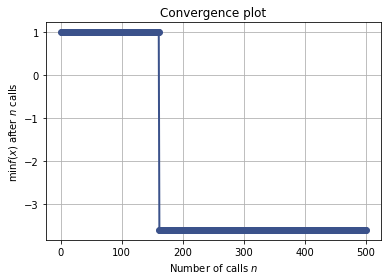

In [84]:
#convergence plot
from skopt.plots import plot_convergence
plot_convergence(res_gp)
print("Best parameters: \
\n jet_time_cuts = [{}] \
\n jet_tmf_cuts = [{}] \
\n jet_delta_r_cuts = [{}]\
 \n jet_chef_cuts = [{}]".format(res_gp.x[0],
                                 res_gp.x[1],
                                 res_gp.x[2],
                                 res_gp.x[3]))